In [1]:
import copy
import functools
import itertools as it
import logging
import random
import os
import sys
import typing

from hstrat import _auxiliary_lib as hstrat_aux
import interval_search as inch
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
import matplotlib as mpl
from nbmetalog import nbmetalog as nbm
import numpy as np
import opytional as opyt
import pandas as pd
import pytest
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from hsurf.hsurf import stretched_algo as stretched_algo
from hsurf import site_selection_strategy
import pylib

random.seed(1)

logging.basicConfig(
    format="[%(funcName)s:%(lineno)d] %(message)s",
)
logger = logging.getLogger()

pylib.jupyter_hide_toggle(hide=True)


/usr/local/lib/python3.10/dist-packages/hstrat/_auxiliary_lib/_check_testing_requirements.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/usr/local/lib/python3.10/dist-packages/pandera/__init__.py:40: UserWarning: Pandas and numpy have been removed from the base pandera
dependencies. Please install pandas as part of your environment's
dependencies or install the pandas extra with:

```bash
pip install pandas pandera

# or
pip install 'pandera[pandas]'
```

  warnings.warn(_warning_msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  w

<IPython.core.display.Javascript object>

In [2]:
nbm.print_metadata()

pylib.jupyter_hide_toggle(hide=True)


context: ci
hostname: fv-az732-822
interpreter: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
nbcellexec: null
nbname: 40-stetched
nbpath: /home/runner/work/hstrat-surface-concept/hstrat-surface-concept/binder/40-stetched.ipynb
revision: null
session: f42d733e-9726-489b-bf69-6b3beecf81c1
timestamp: 2025-07-06T00:39:09Z00:00


IPython==7.31.1
keyname==0.6.0
yaml==6.0.2
hstrat==1.11.1
hsurf==1.0.2
interval_search==0.5.2
logging==0.5.1.2
matplotlib==3.8.3
nbmetalog==0.2.6
numpy==1.23.5
opytional==0.1.0
pandas==1.5.2
pytest==7.2.2
scipy==1.10.1
seaborn==0.13.2
teeplot==__version__ = '1.4.2'
re==2.2.1
comm==0.2.2
psutil==7.0.0
zmq==27.0.0
json==2.0.9
ipykernel==6.29.5


<IPython.core.display.Javascript object>

## Visualize Reservations


100%|██████████| 128/128 [00:00<00:00, 28074.62it/s]
3it [00:06,  2.16s/it]
3it [00:01,  2.37it/s]


teeplots/40/num-generations=128+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.pdf
teeplots/40/num-generations=128+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.png


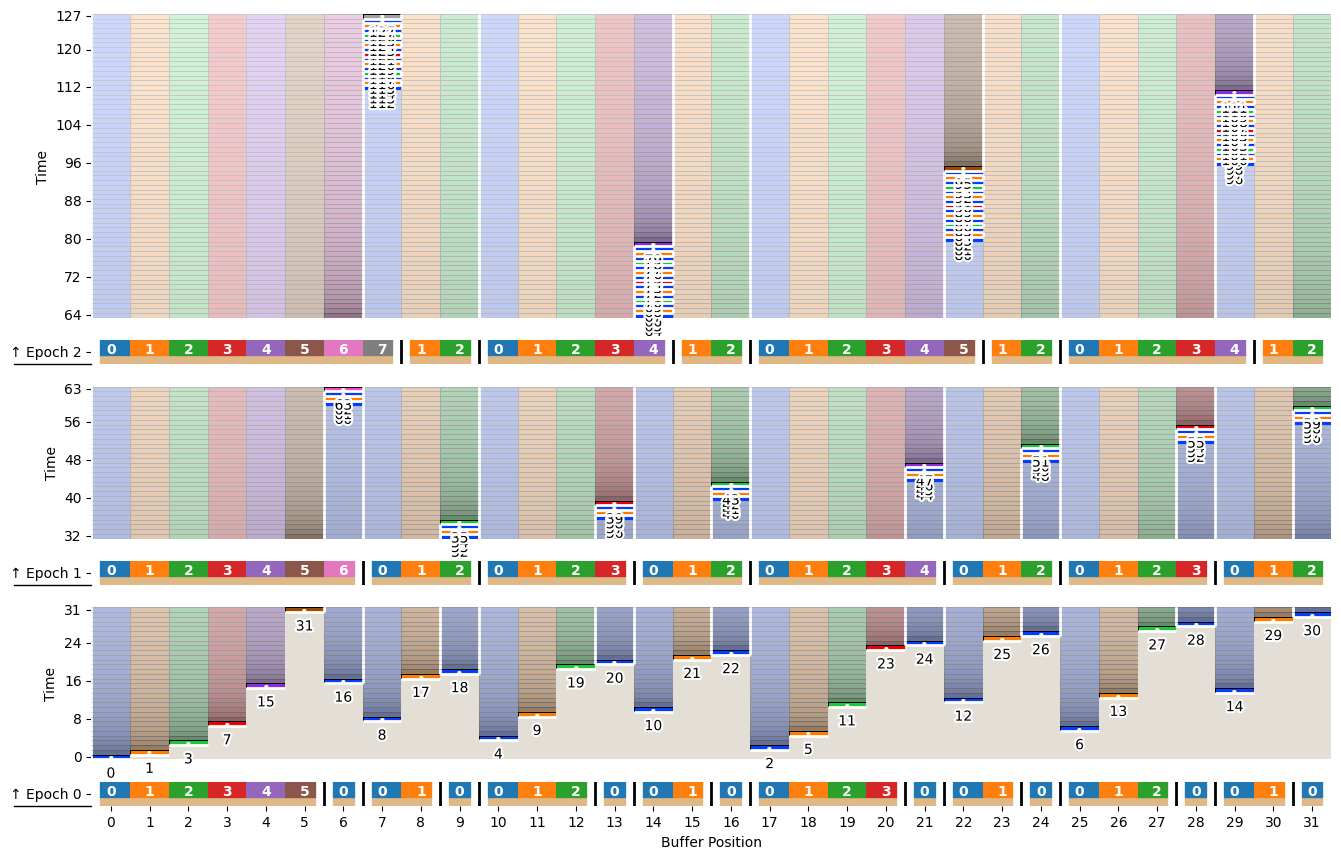

100%|██████████| 256/256 [00:00<00:00, 30221.56it/s]
4it [00:16,  4.10s/it]
4it [00:03,  1.23it/s]


teeplots/40/num-generations=256+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.pdf
teeplots/40/num-generations=256+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.png


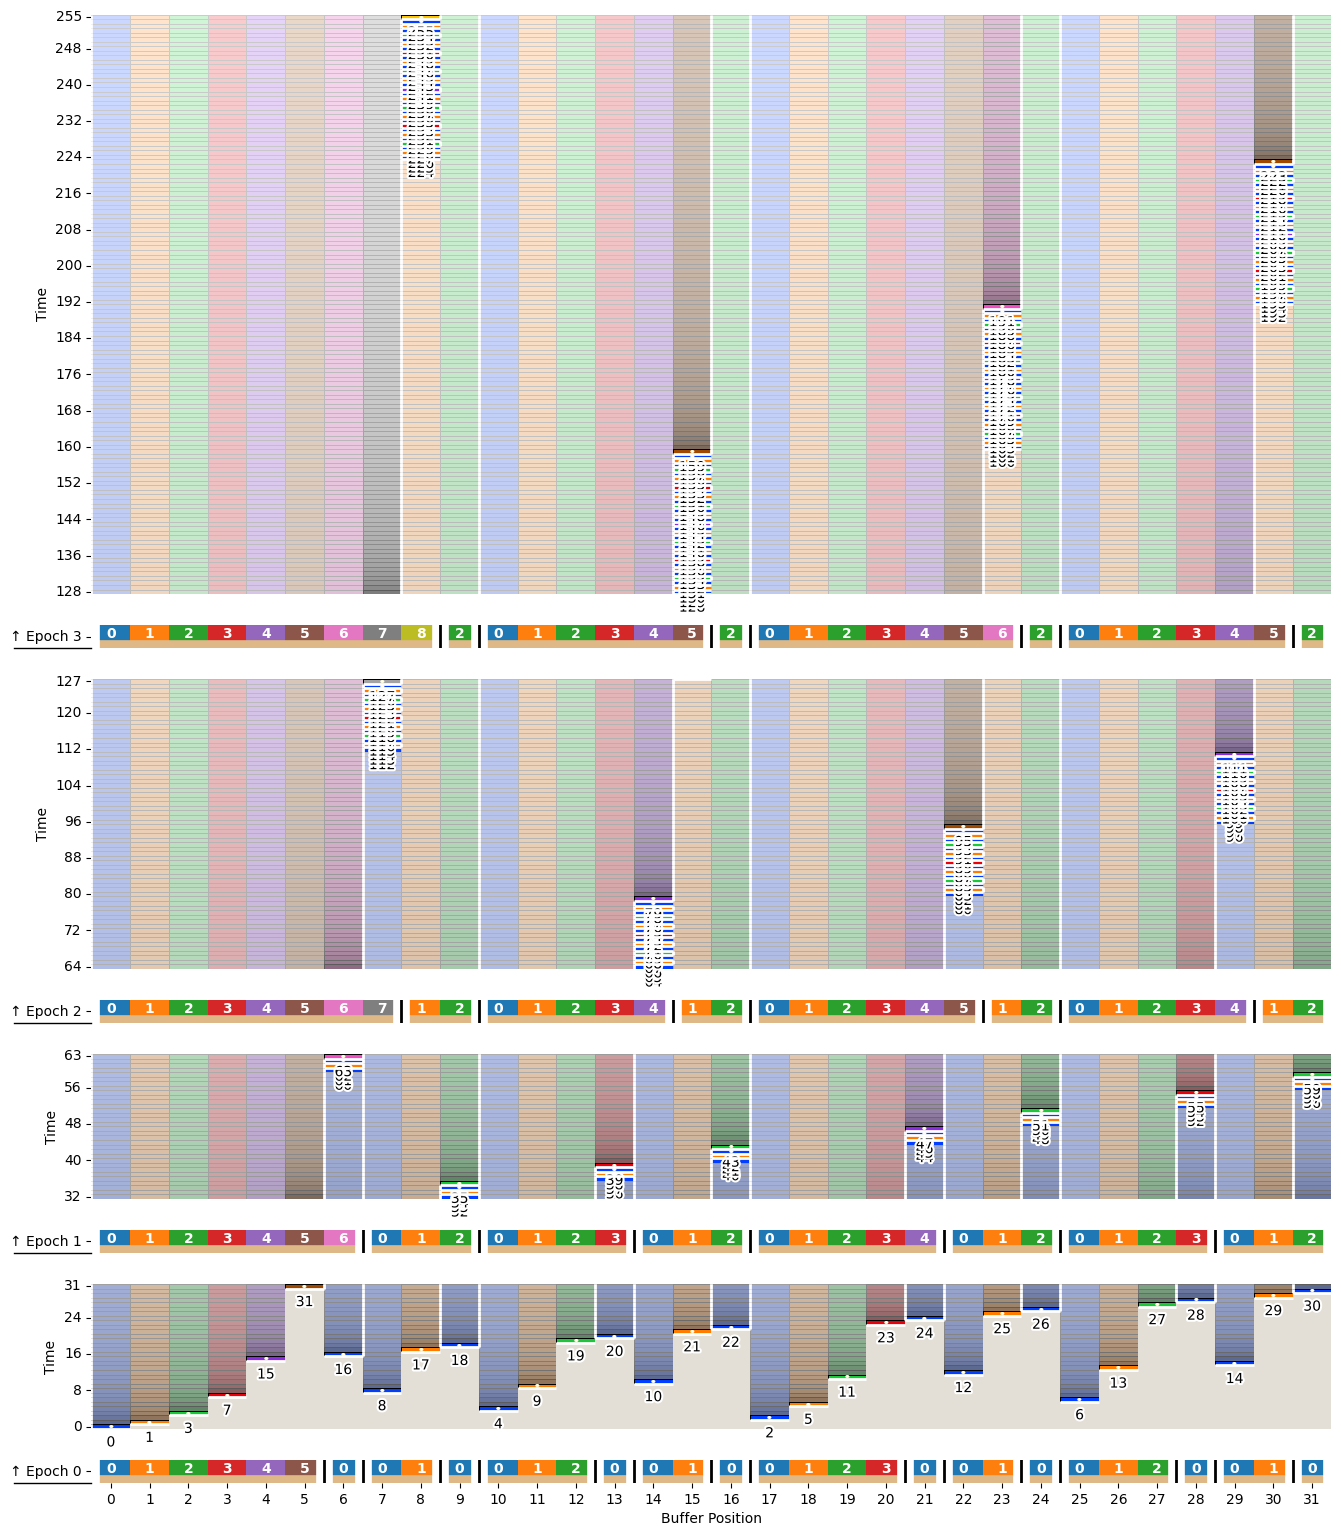

In [3]:
for num_generations, surface_size in [
    (128, 32),
    (256, 32),
]:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        stretched_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    ).replace(-1, np.nan)

    mpl.rcParams.update(
        {
            "figure.figsize": (surface_size / 4 + 1, num_generations / 15 + 1),
        },
    )
    candidate_ranks = [
        2**i - 1 for i in range(surface_size.bit_length() - 1, surface_size)
    ]
    maxrank = surface_history_df["rank"].max()
    splice_from_ranks= [
        rank
        for rank in candidate_ranks
        if rank <= maxrank  # in operator weird, nan?
    ]
    splice_to_ranks = np.array([-1, *splice_from_ranks[:-1]]) + 1
    pylib.tee_release(
        pylib.site_selection_viz.site_reservation_by_rank_spliced_at_heatmap,
        surface_history_df,
        splice_from_ranks=splice_from_ranks,
        splice_to_ranks=splice_to_ranks,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="40",
    )
    plt.show()


100%|██████████| 127/127 [00:00<00:00, 36347.77it/s]


teeplots/40/surface-size=8+viz=site-reservation-at-ranks-heatmap+ext=.pdf
teeplots/40/surface-size=8+viz=site-reservation-at-ranks-heatmap+ext=.png


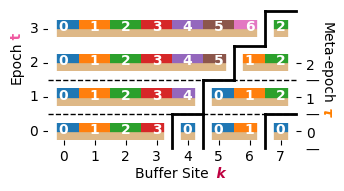

100%|██████████| 32767/32767 [00:01<00:00, 32350.50it/s]


teeplots/40/surface-size=16+viz=site-reservation-at-ranks-heatmap+ext=.pdf
teeplots/40/surface-size=16+viz=site-reservation-at-ranks-heatmap+ext=.png


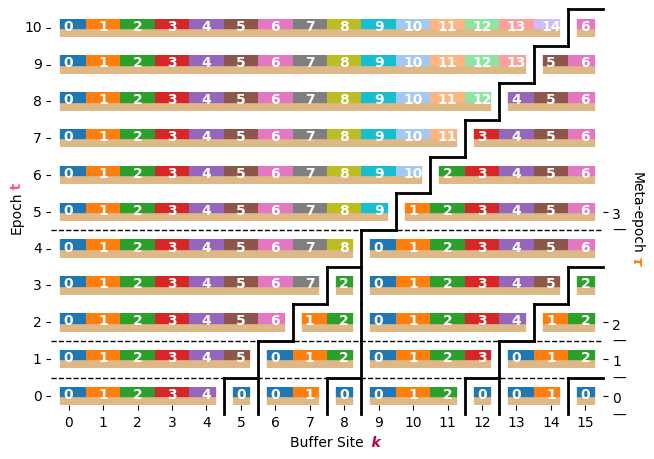

100%|██████████| 262144/262144 [00:09<00:00, 26723.06it/s]


teeplots/40/surface-size=32+viz=site-reservation-at-ranks-heatmap+ext=.pdf
teeplots/40/surface-size=32+viz=site-reservation-at-ranks-heatmap+ext=.png


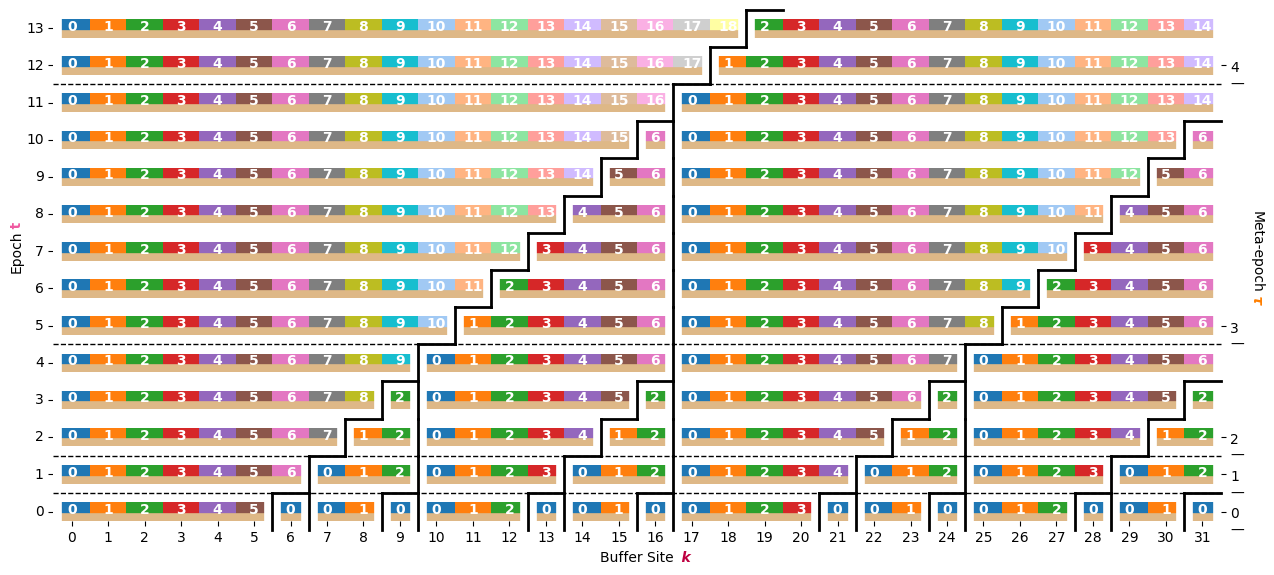

In [4]:
for surface_size in 8, 16, 32:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        stretched_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=min(2**(surface_size - 1) - 1, 2**18),
        progress_wrap=tqdm,
    ).replace(-1, np.nan)

    candidate_ranks = [
        2**i - 1 for i in range(surface_size.bit_length() - 1, surface_size)
    ]
    maxrank = surface_history_df["rank"].max()
    ranks = [
        rank
        for rank in candidate_ranks
        if rank <= maxrank  # in operator weird, nan?
    ]
    pylib.tee_release(
        pylib.site_selection_viz.site_reservation_at_ranks_heatmap,
        surface_history_df,
        ranks=ranks,
        teeplot_outattrs={"surface-size": surface_size},
        teeplot_subdir="40",
    )
    plt.show()


100%|██████████| 128/128 [00:00<00:00, 28105.48it/s]


teeplots/40/num-generations=128+surface-size=32+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=128+surface-size=32+viz=site-reservation-by-rank-heatmap+ext=.png


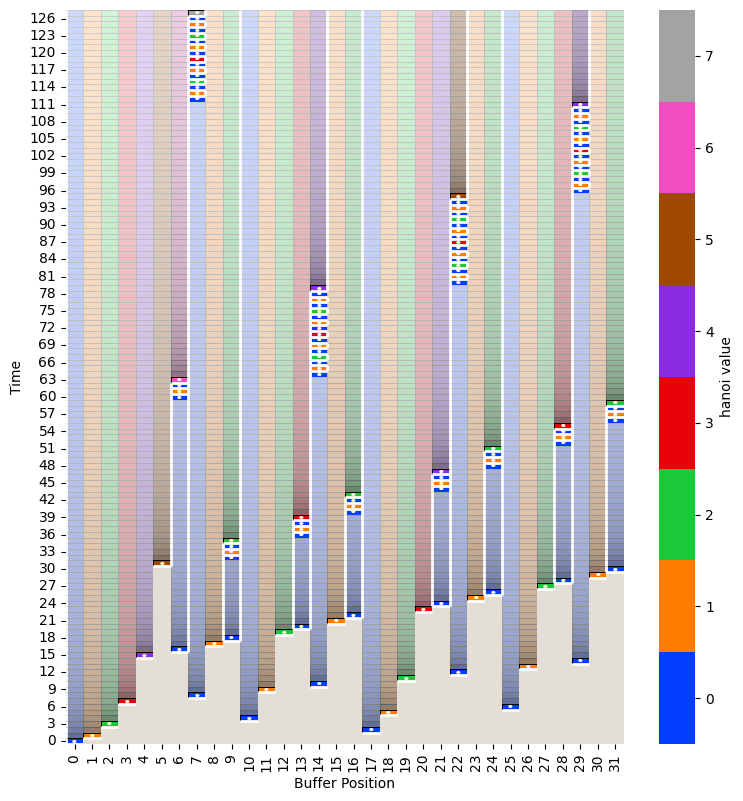

100%|██████████| 128/128 [00:00<00:00, 30631.08it/s]


teeplots/40/num-generations=128+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=128+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.png


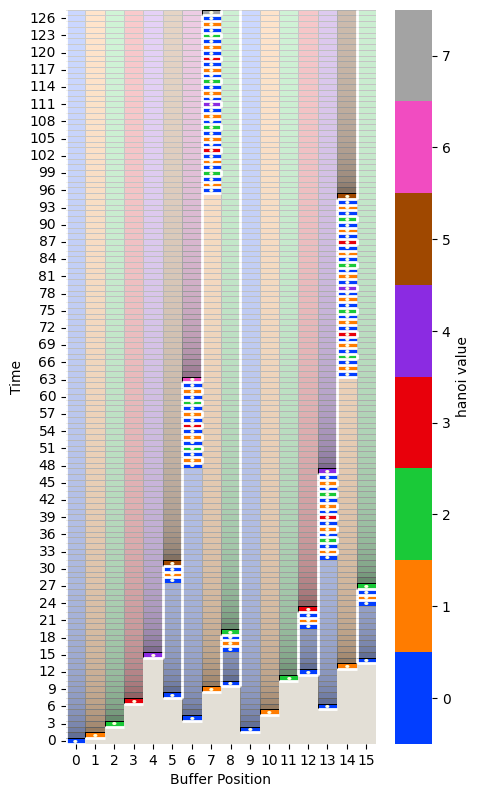

100%|██████████| 64/64 [00:00<00:00, 33596.43it/s]


teeplots/40/num-generations=64+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=64+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.png


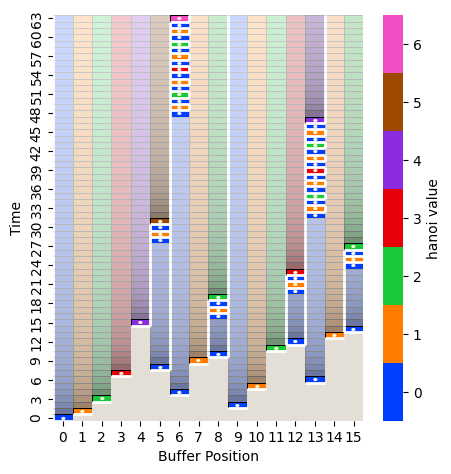

100%|██████████| 32/32 [00:00<00:00, 25115.59it/s]


teeplots/40/num-generations=32+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=32+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.png


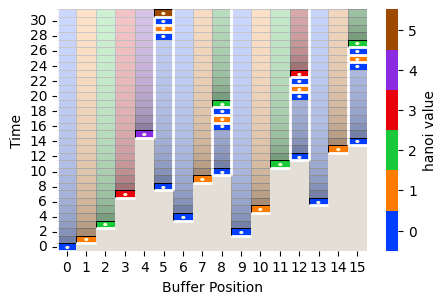

100%|██████████| 127/127 [00:00<00:00, 36424.82it/s]


teeplots/40/num-generations=127+surface-size=8+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=127+surface-size=8+viz=site-reservation-by-rank-heatmap+ext=.png


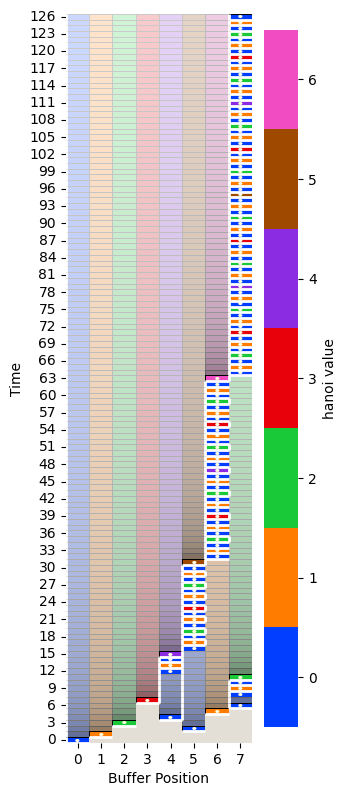

In [5]:
for num_generations, surface_size in [
    (128, 32),
    (128, 16),
    (64, 16),
    (32, 16),
    (127, 8),
]:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        stretched_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    ).replace(-1, np.nan)

    mpl.rcParams.update(
        {
            "figure.figsize": (surface_size / 4 + 1, num_generations / 15 + 1),
        },
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_reservation_by_rank_heatmap,
        surface_history_df,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="40",
    )
    plt.show()


In [6]:
mpl.rcParams.update(
    {
        "figure.figsize": (6, 1),
    },
)


## Visualize Stretched Criterion Satisfaction


100%|██████████| 127/127 [00:00<00:00, 5531.08it/s]


teeplots/40/hue=kind+surface-size=8+viz=criterion-satisfaction-lineplot+x=rank+y=stretched-criterion+ext=.pdf
teeplots/40/hue=kind+surface-size=8+viz=criterion-satisfaction-lineplot+x=rank+y=stretched-criterion+ext=.png


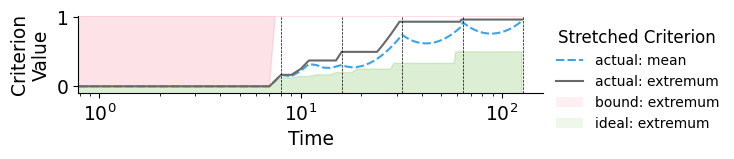

100%|██████████| 32767/32767 [00:05<00:00, 5594.07it/s]


teeplots/40/hue=kind+surface-size=16+viz=criterion-satisfaction-lineplot+x=rank+y=stretched-criterion+ext=.pdf
teeplots/40/hue=kind+surface-size=16+viz=criterion-satisfaction-lineplot+x=rank+y=stretched-criterion+ext=.png


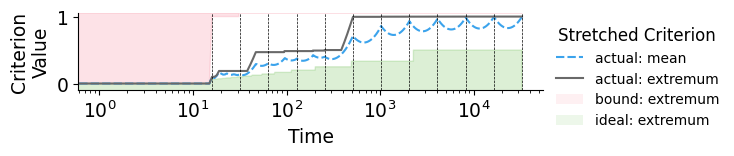

100%|██████████| 65536/65536 [00:12<00:00, 5433.45it/s]


teeplots/40/hue=kind+surface-size=32+viz=criterion-satisfaction-lineplot+x=rank+y=stretched-criterion+ext=.pdf
teeplots/40/hue=kind+surface-size=32+viz=criterion-satisfaction-lineplot+x=rank+y=stretched-criterion+ext=.png


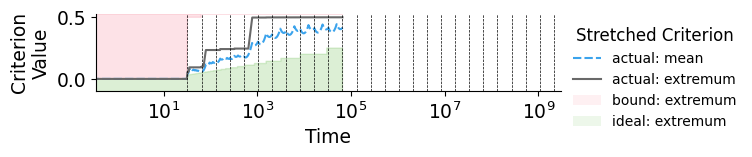

In [7]:
for surface_size in 8, 16, 32:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        stretched_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=min(2**(surface_size - 1) - 1, 2**16),
        progress_wrap=tqdm,
    )
    criteria_df = pylib.site_selection_eval.calc_surface_history_criteria(
        surface_history_df,
        stretched_algo,
        site_selection_strategy.site_selection_bounds,
        site_selection_strategy.site_selection_criteria,
        progress_wrap=tqdm,
    )
    pylib.tee_release(
        pylib.site_selection_viz.criterion_satisfaction_lineplot,
        data=criteria_df[
            ~criteria_df["kind"].isin(["naive lower bound"])
        ],
        x="rank",
        y="stretched criterion",
        hue="kind",
        surface_size=surface_size,
        teeplot_outinclude="surface_size",
        teeplot_subdir="40",
    )


## Visualize


100%|██████████| 32768/32768 [00:00<00:00, 36425.37it/s]


teeplots/40/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


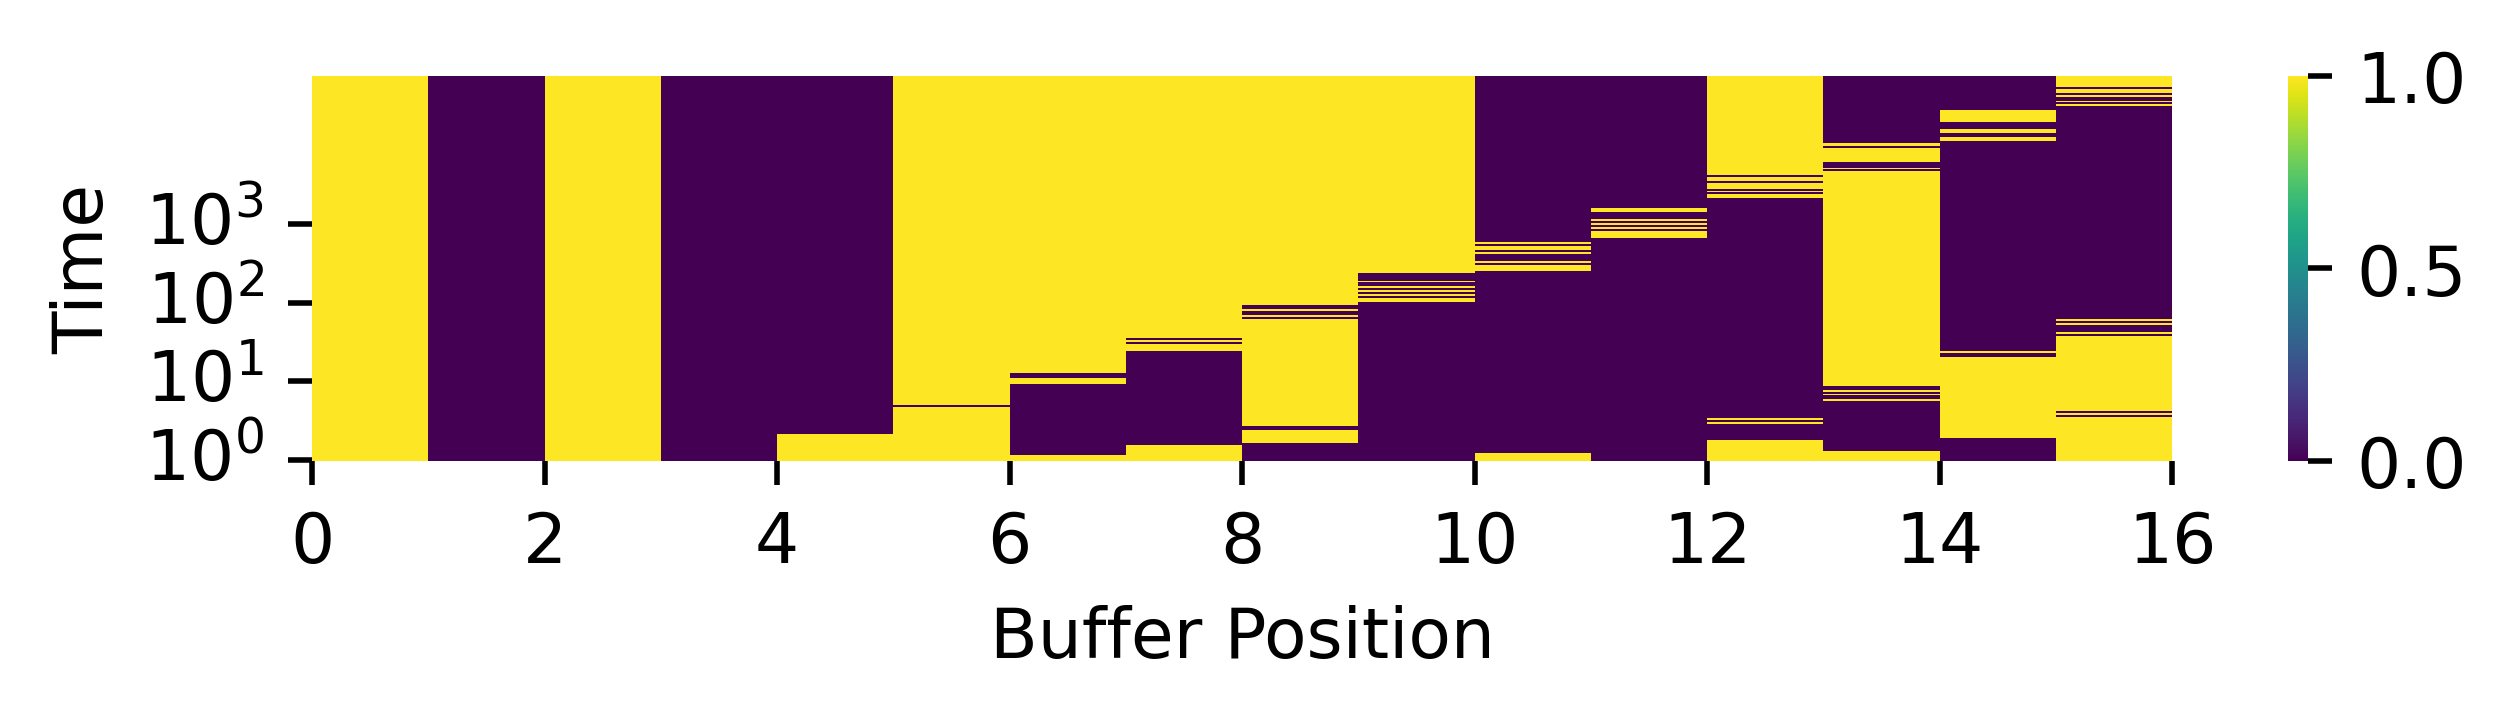

teeplots/40/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


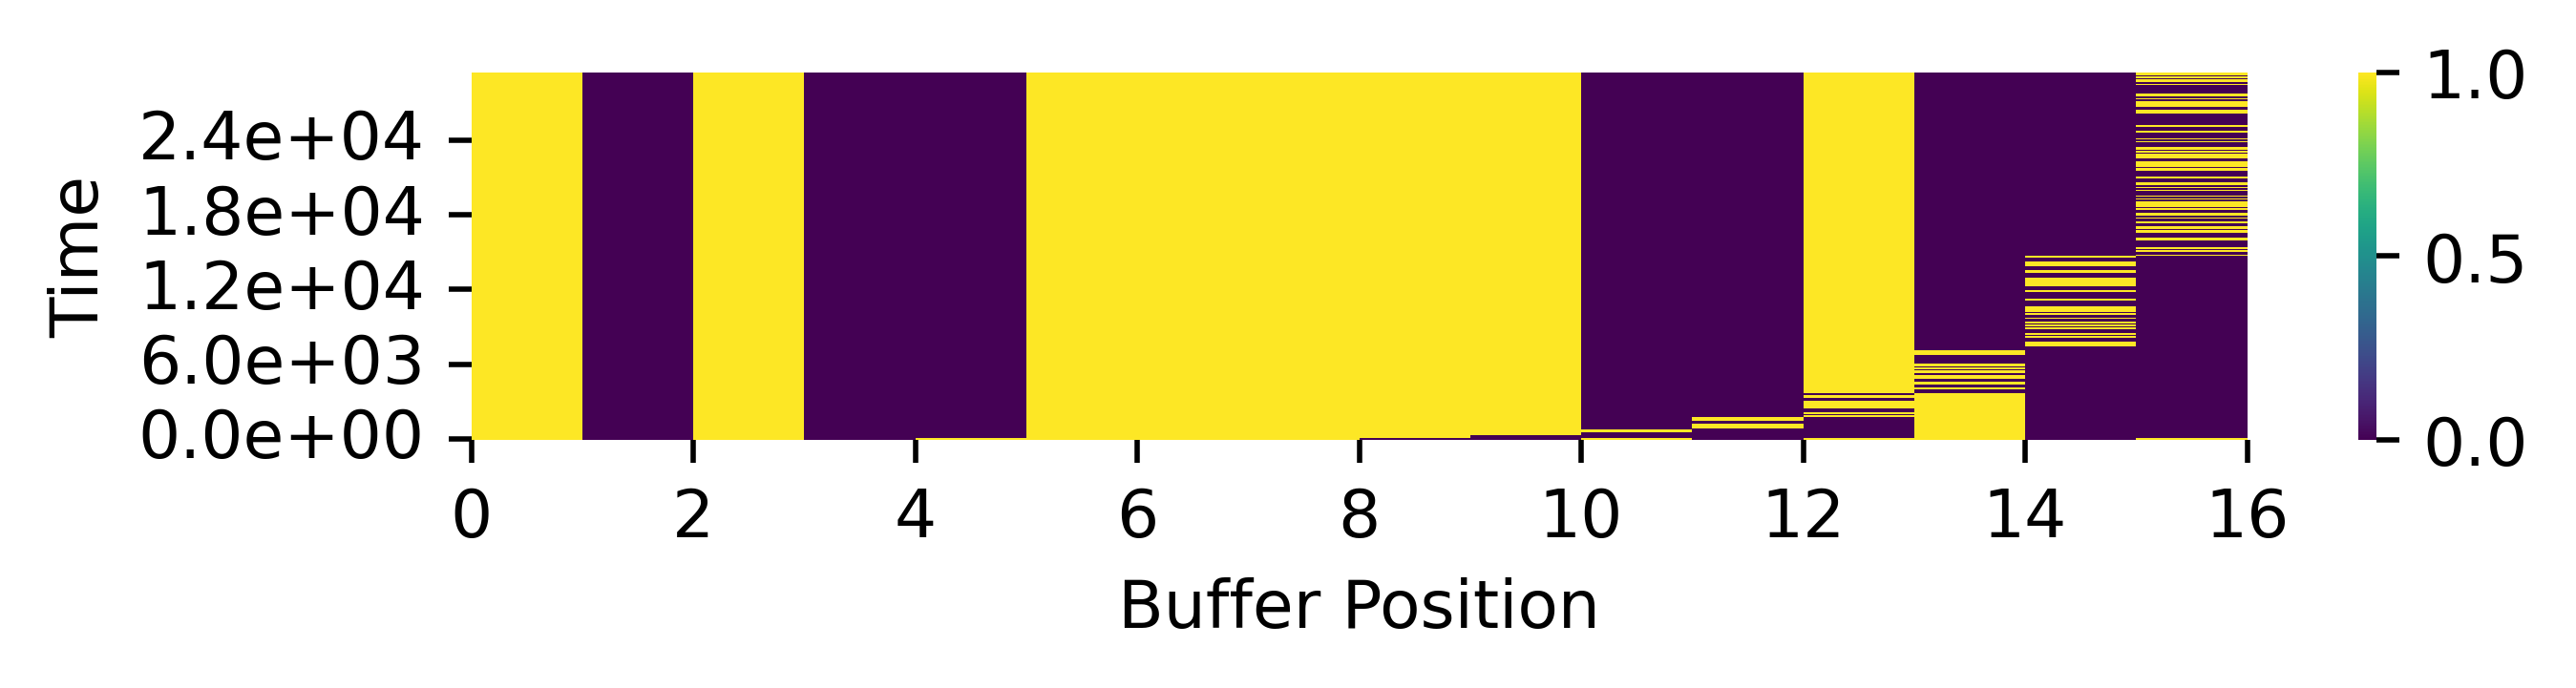

teeplots/40/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


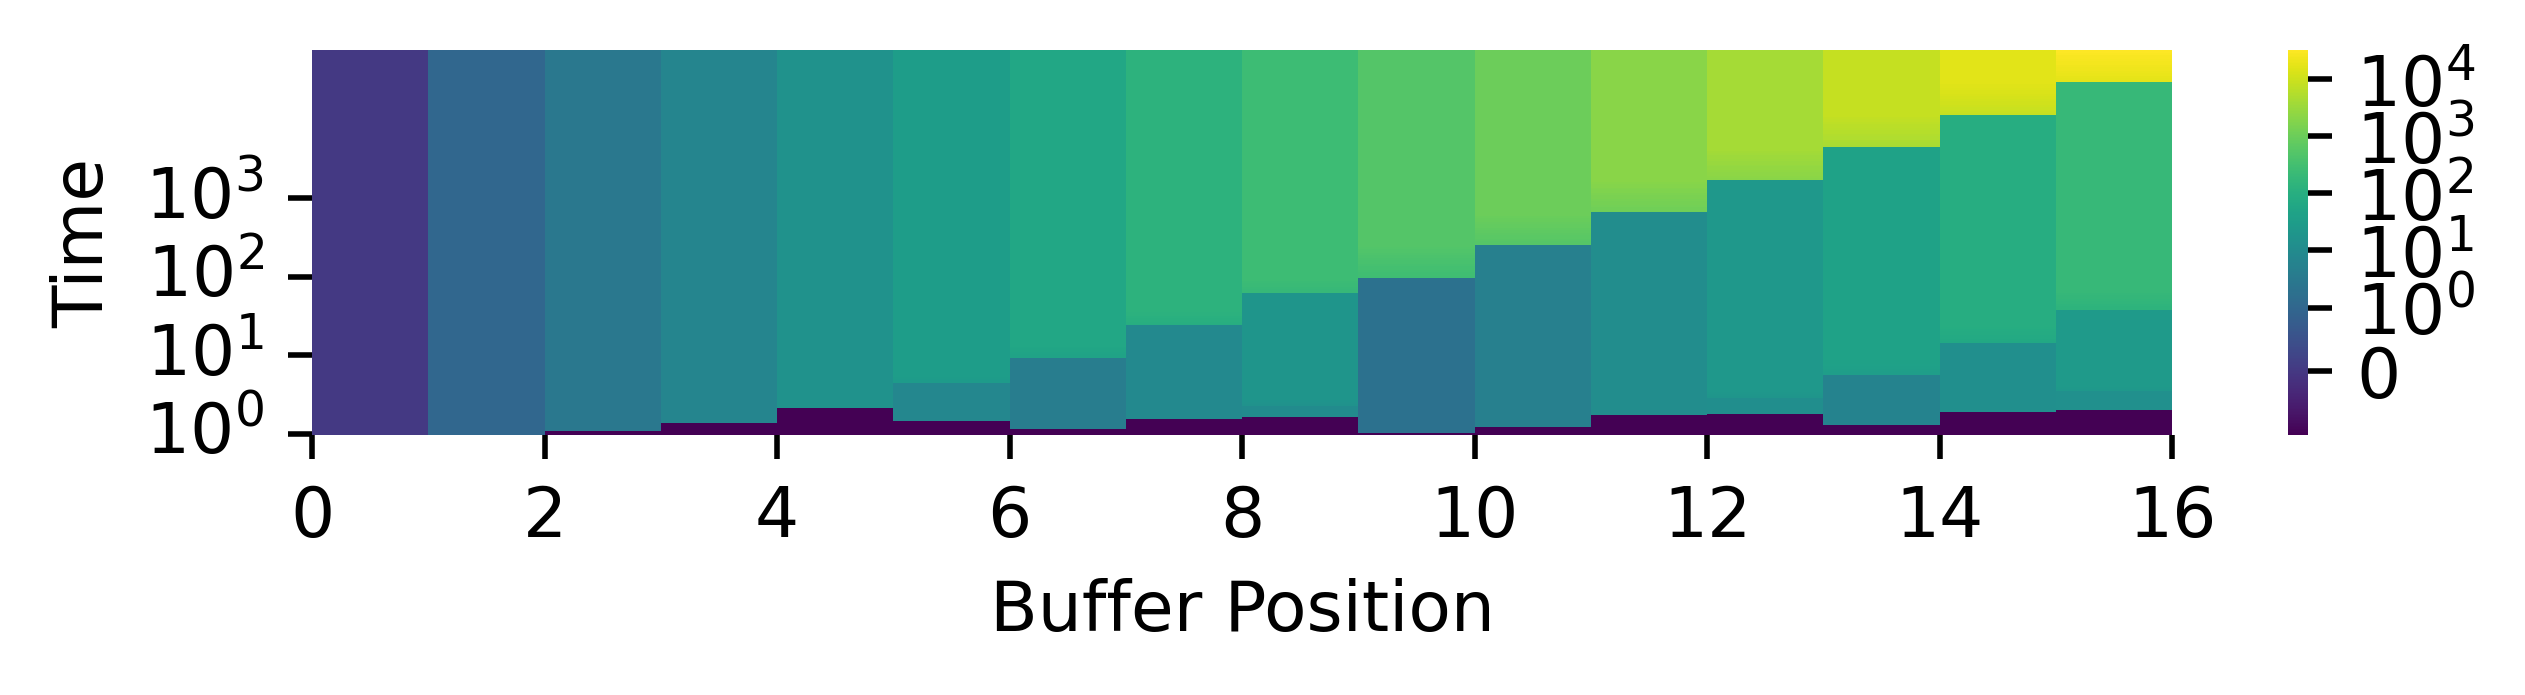

teeplots/40/cnorm=None+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=None+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


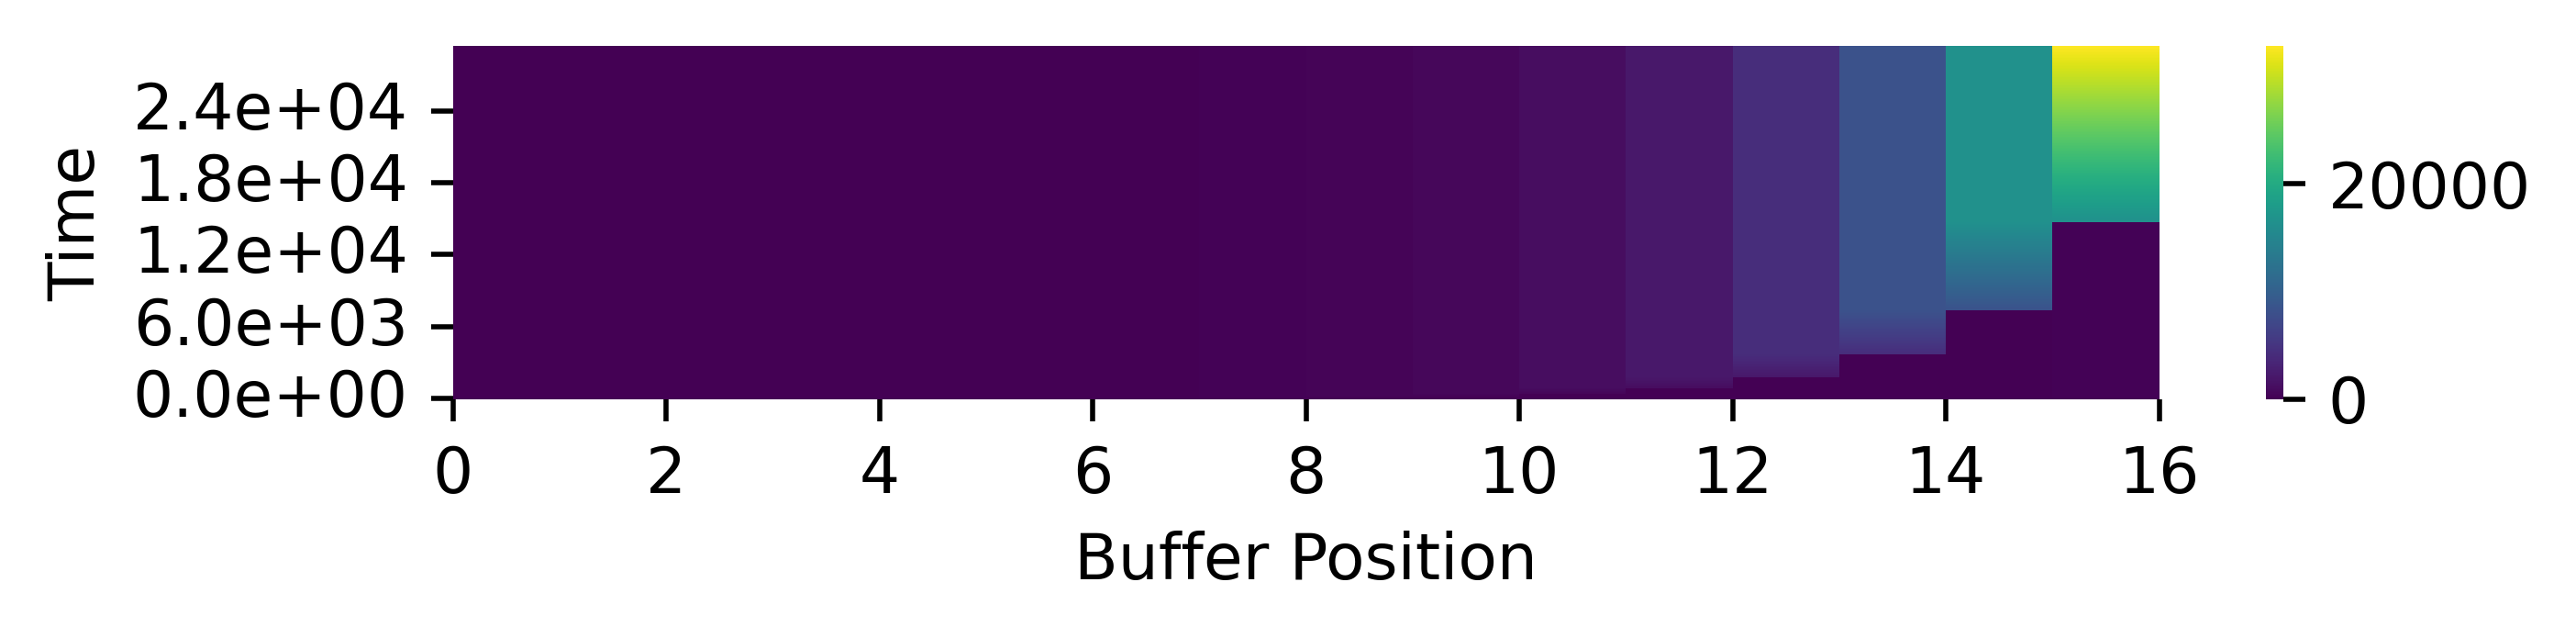

teeplots/40/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ext=.png


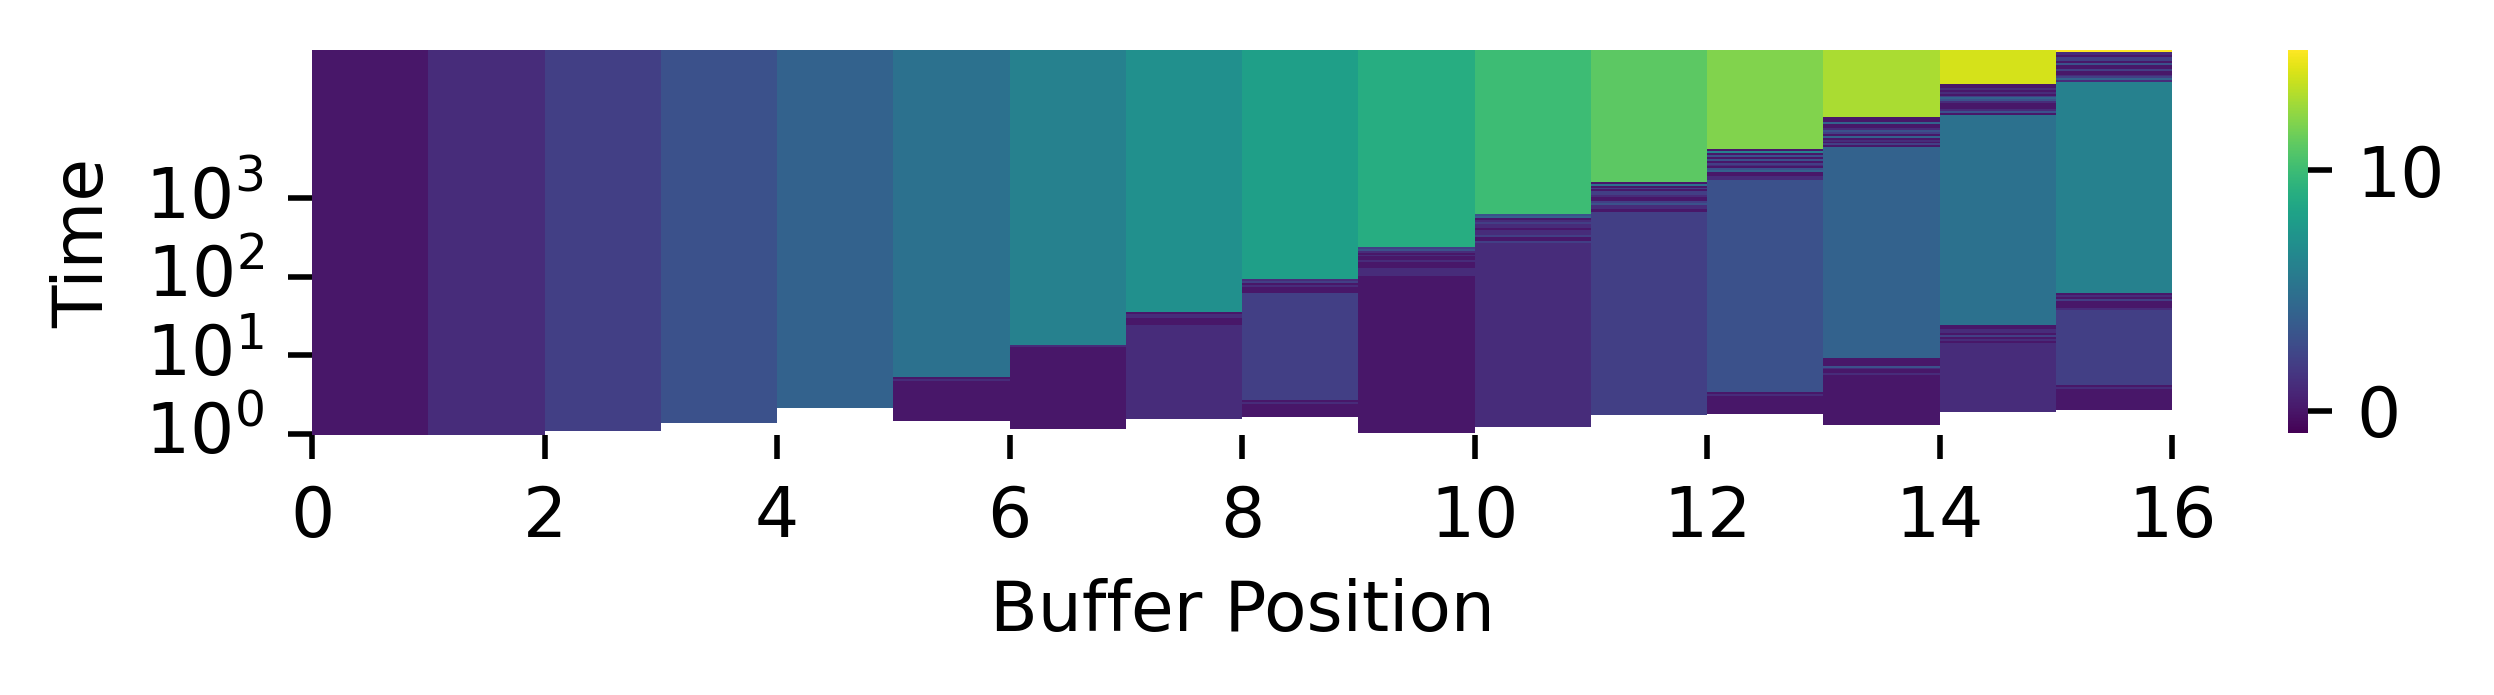

teeplots/40/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


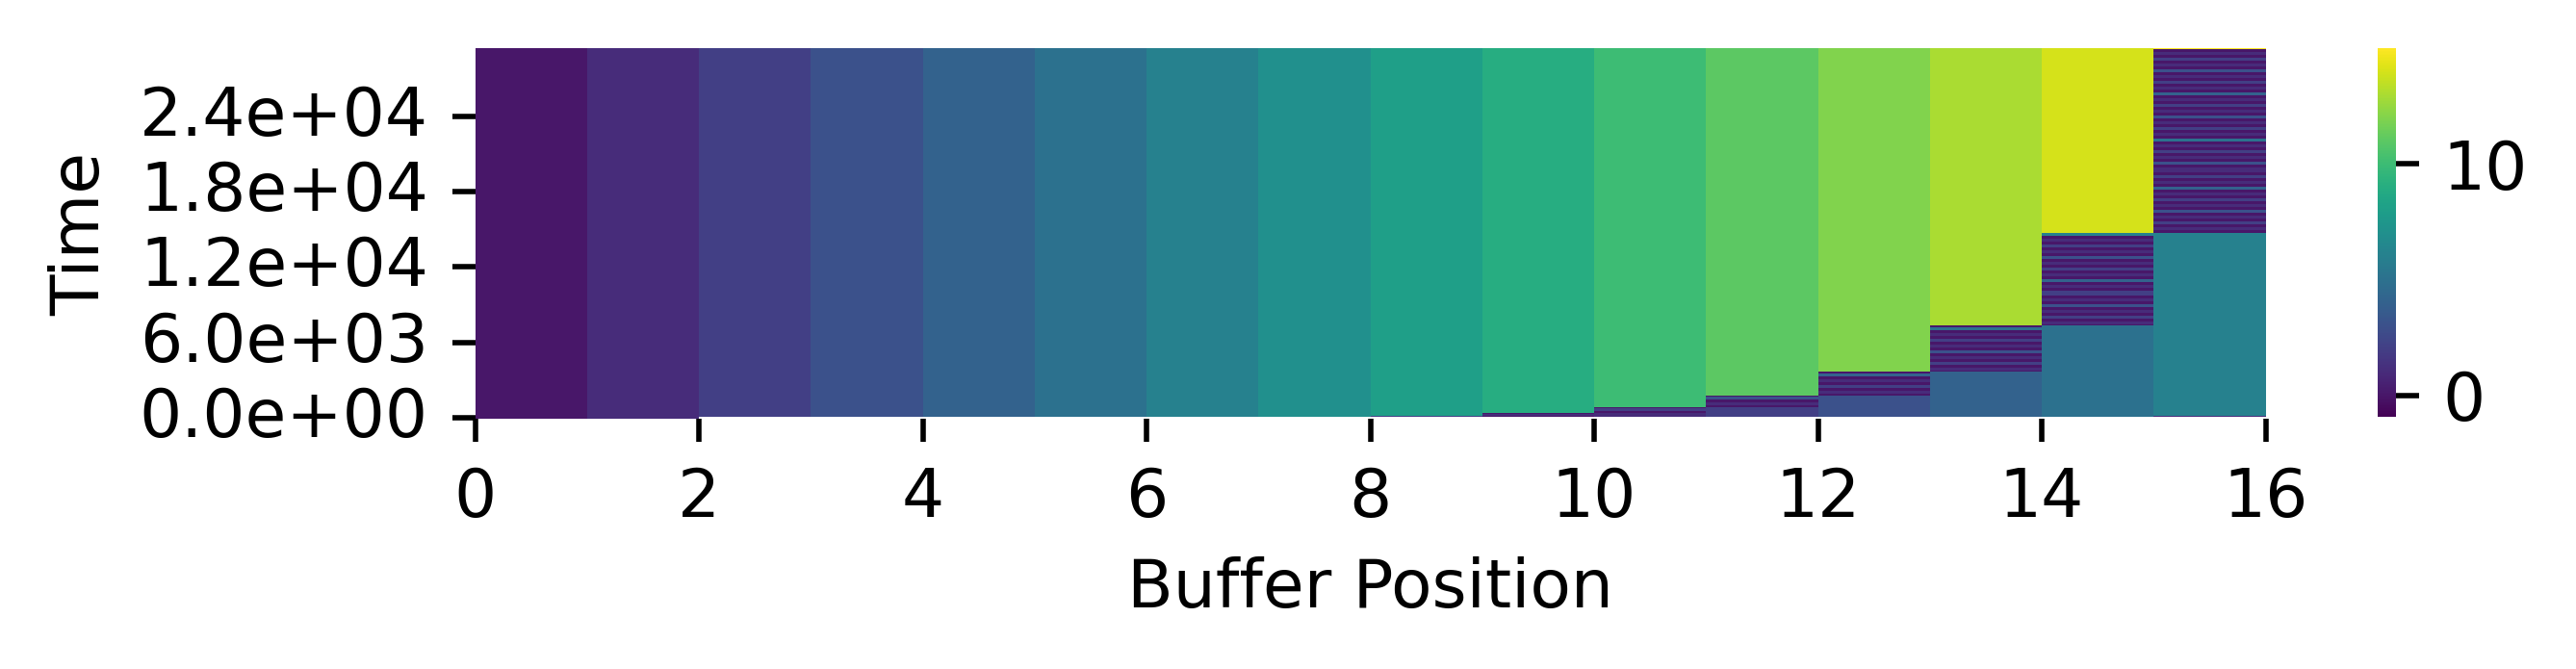

teeplots/40/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


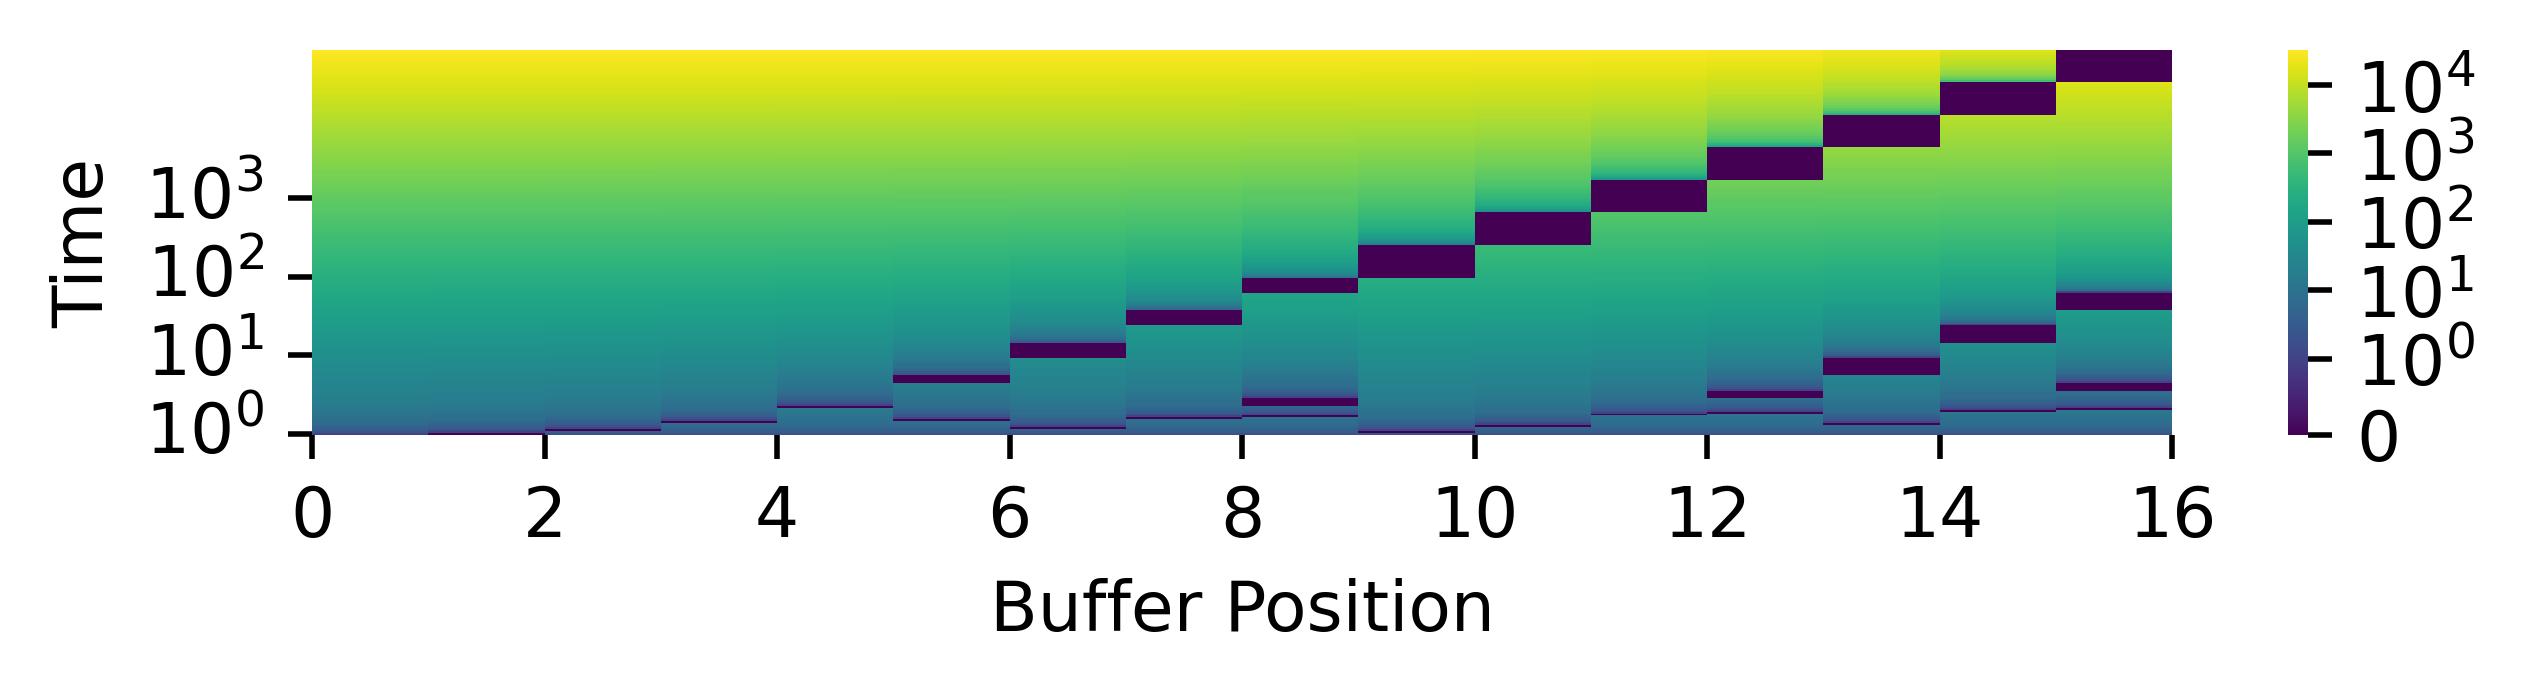

teeplots/40/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


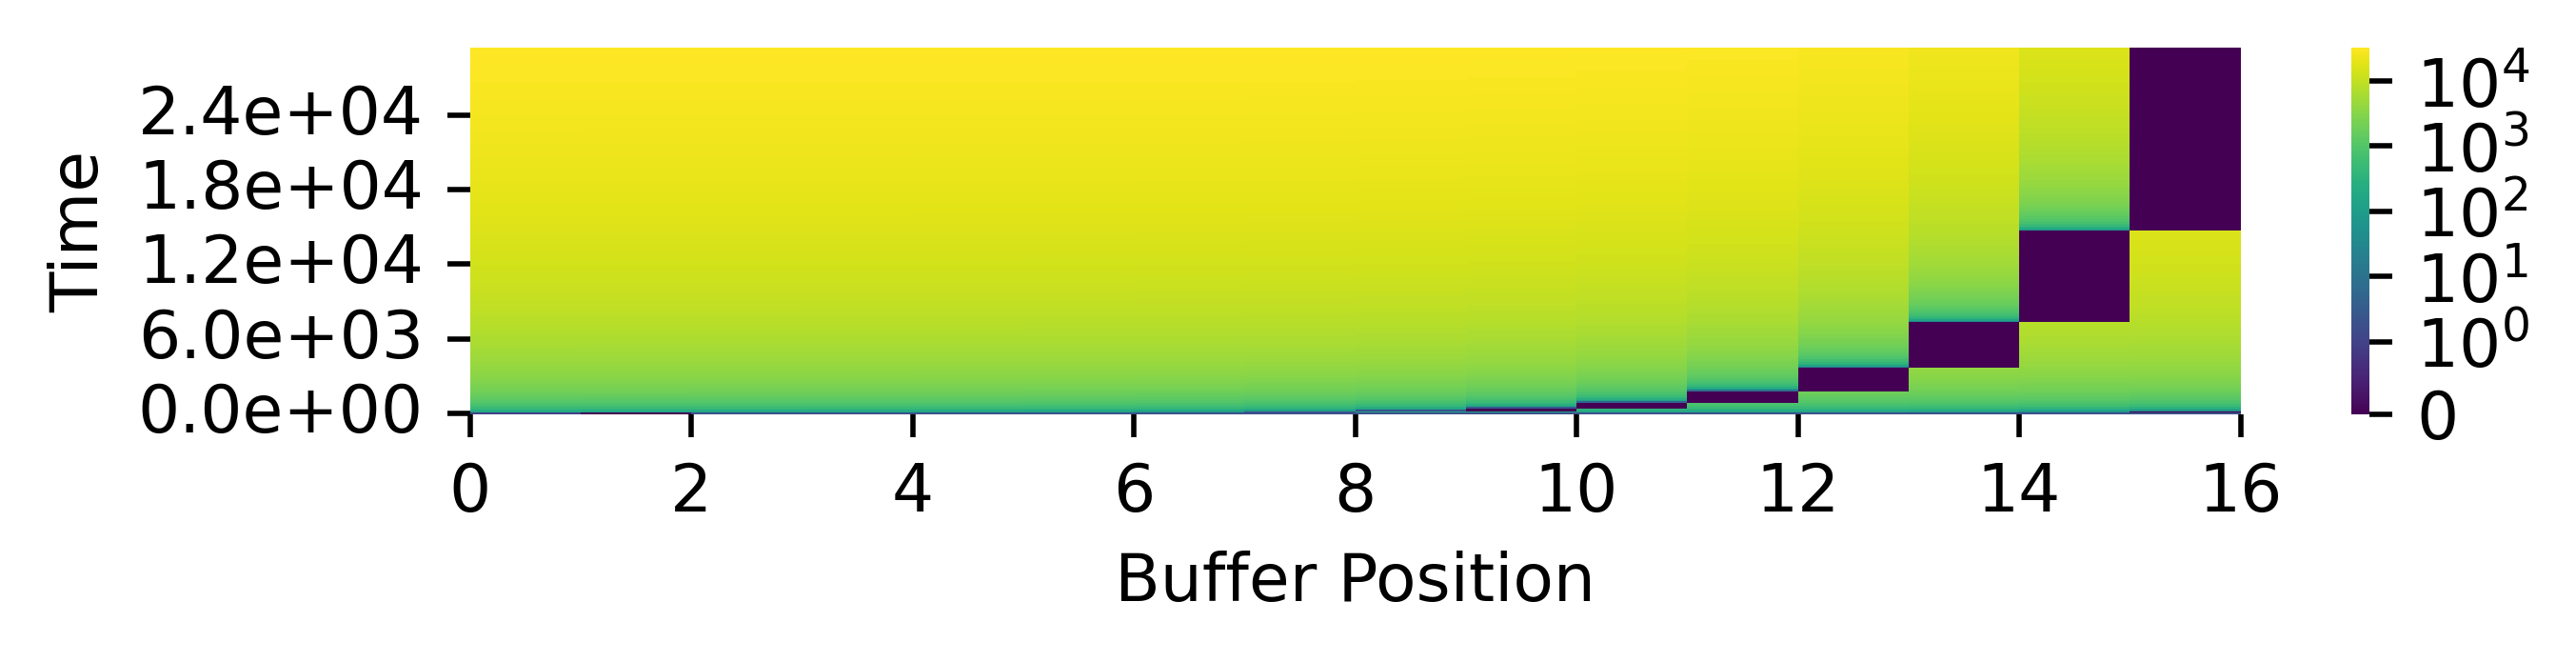

100%|██████████| 2998/2998 [00:07<00:00, 375.52it/s]


teeplots/40/num-generations=262144+surface-size=16+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/40/num-generations=262144+surface-size=16+viz=stratum-persistence-dripplot+ext=.png


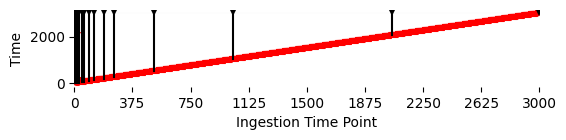

100%|██████████| 262144/262144 [00:09<00:00, 26884.05it/s]


teeplots/40/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


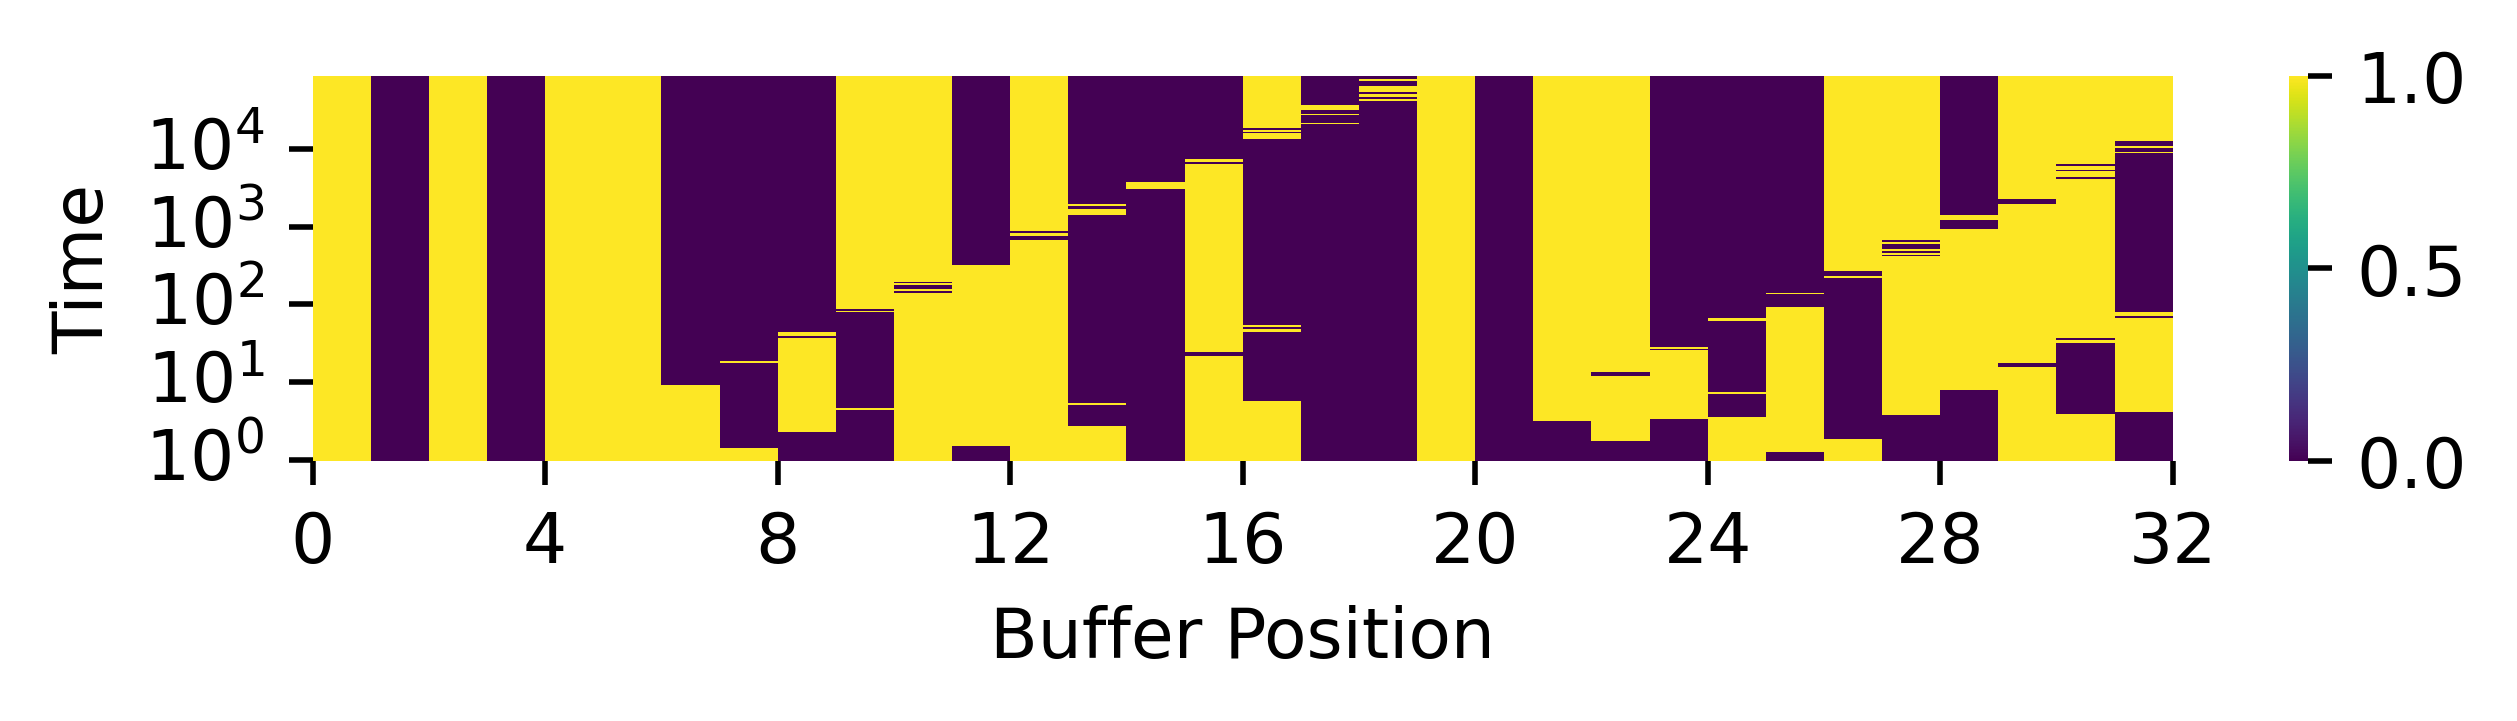

teeplots/40/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


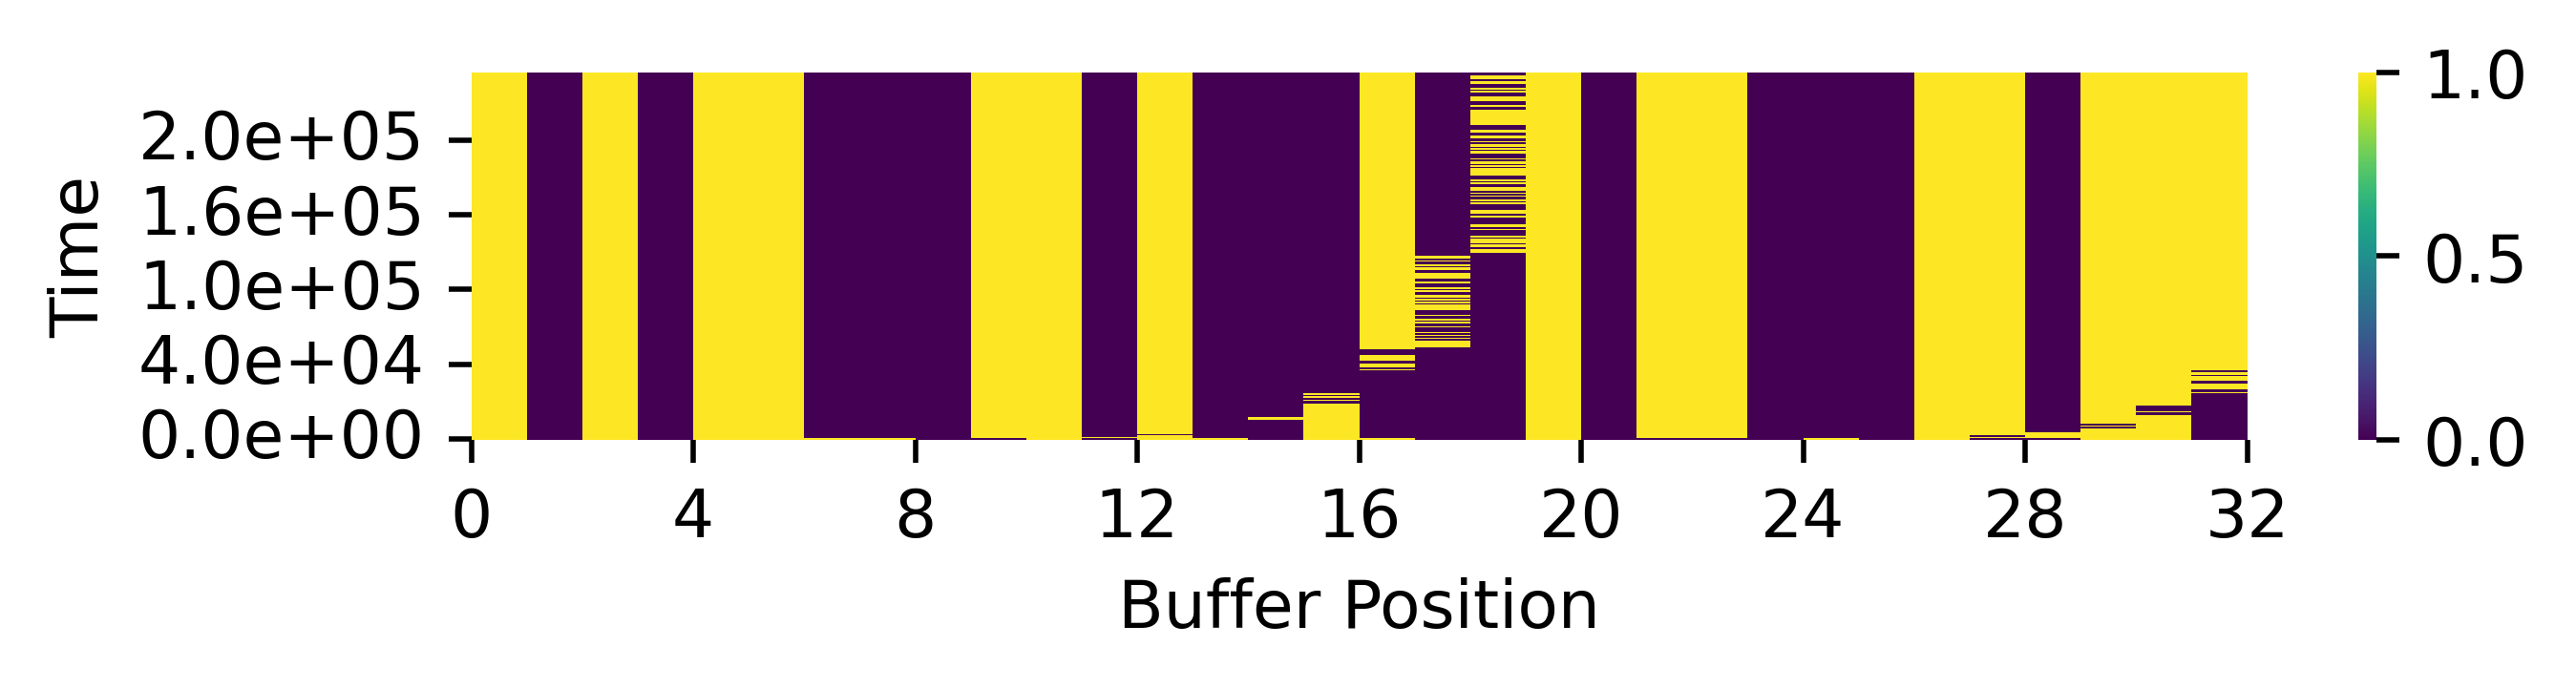

teeplots/40/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


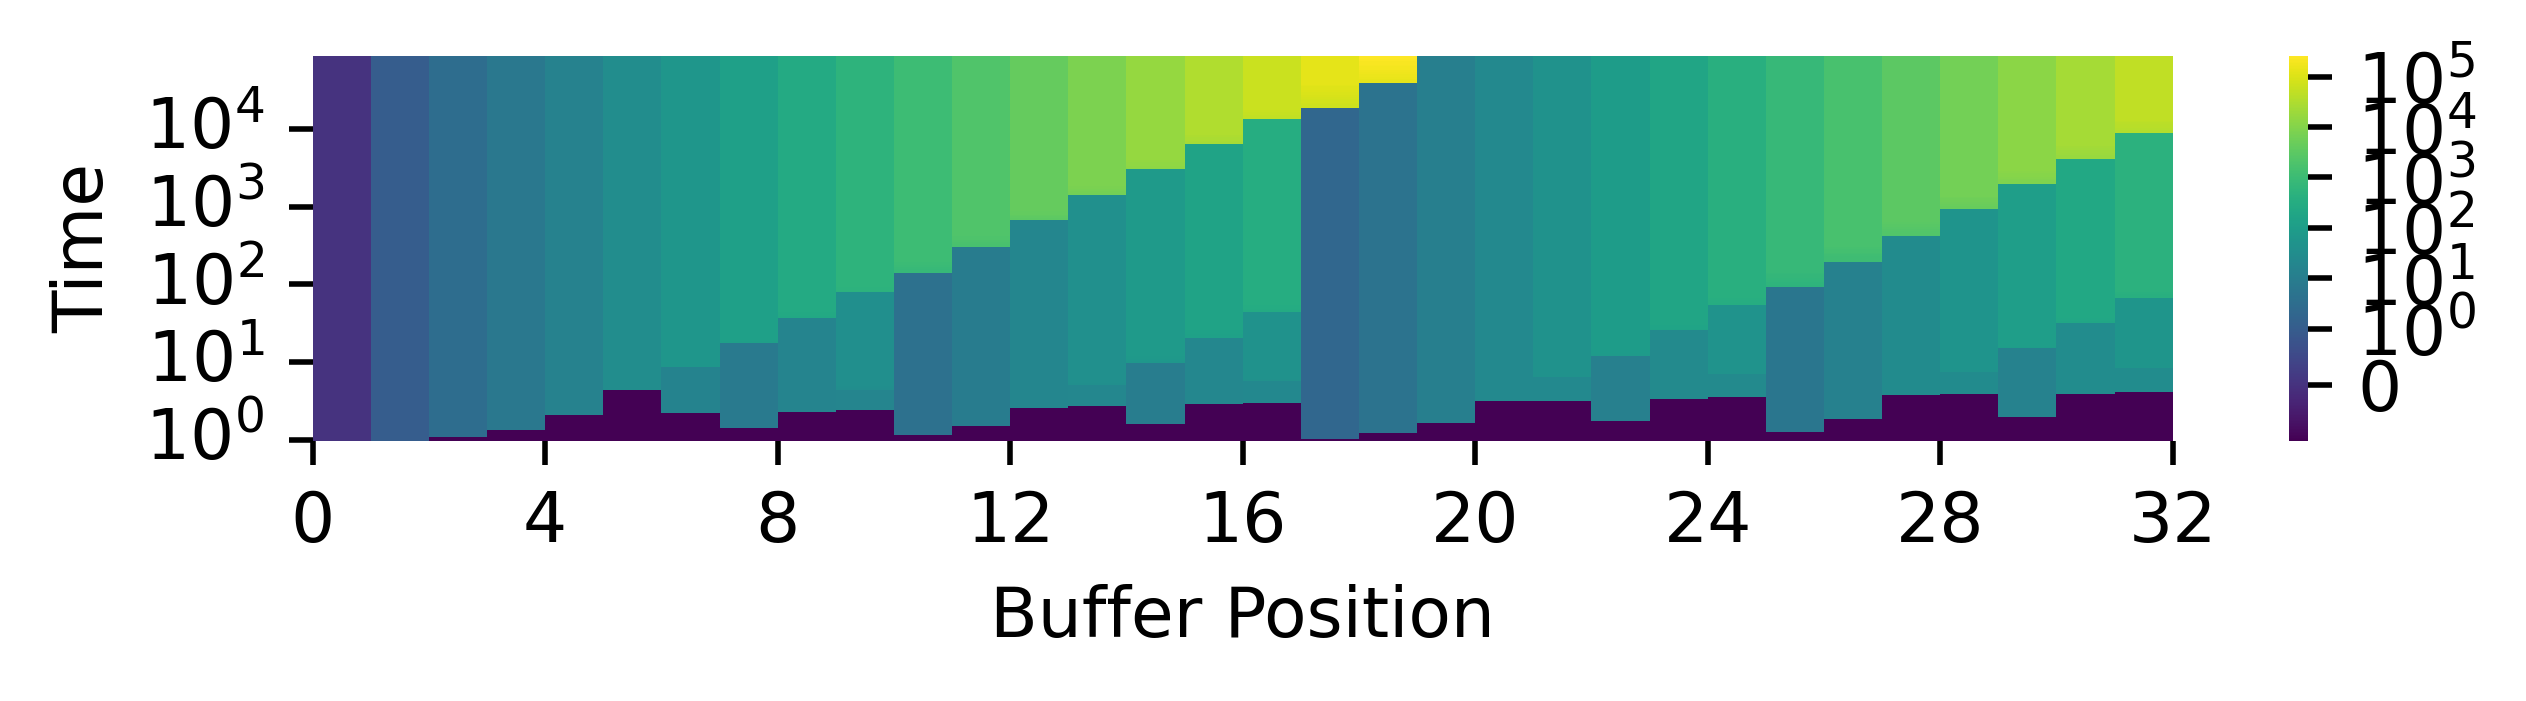

teeplots/40/cnorm=None+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=None+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


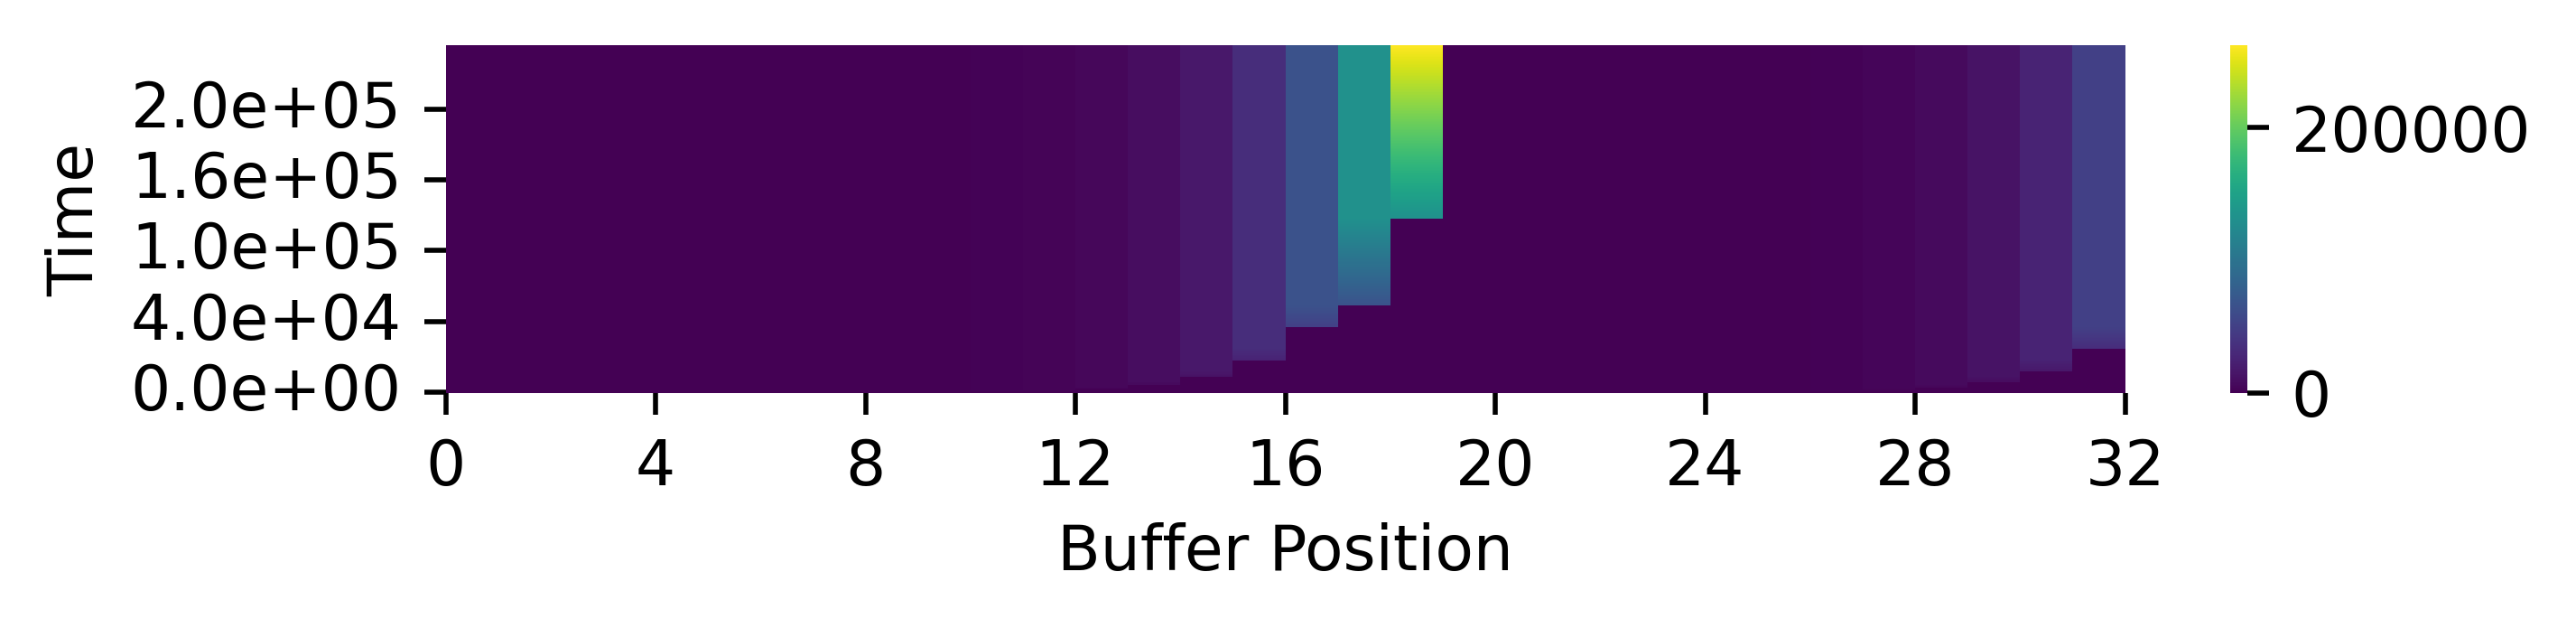

teeplots/40/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.png


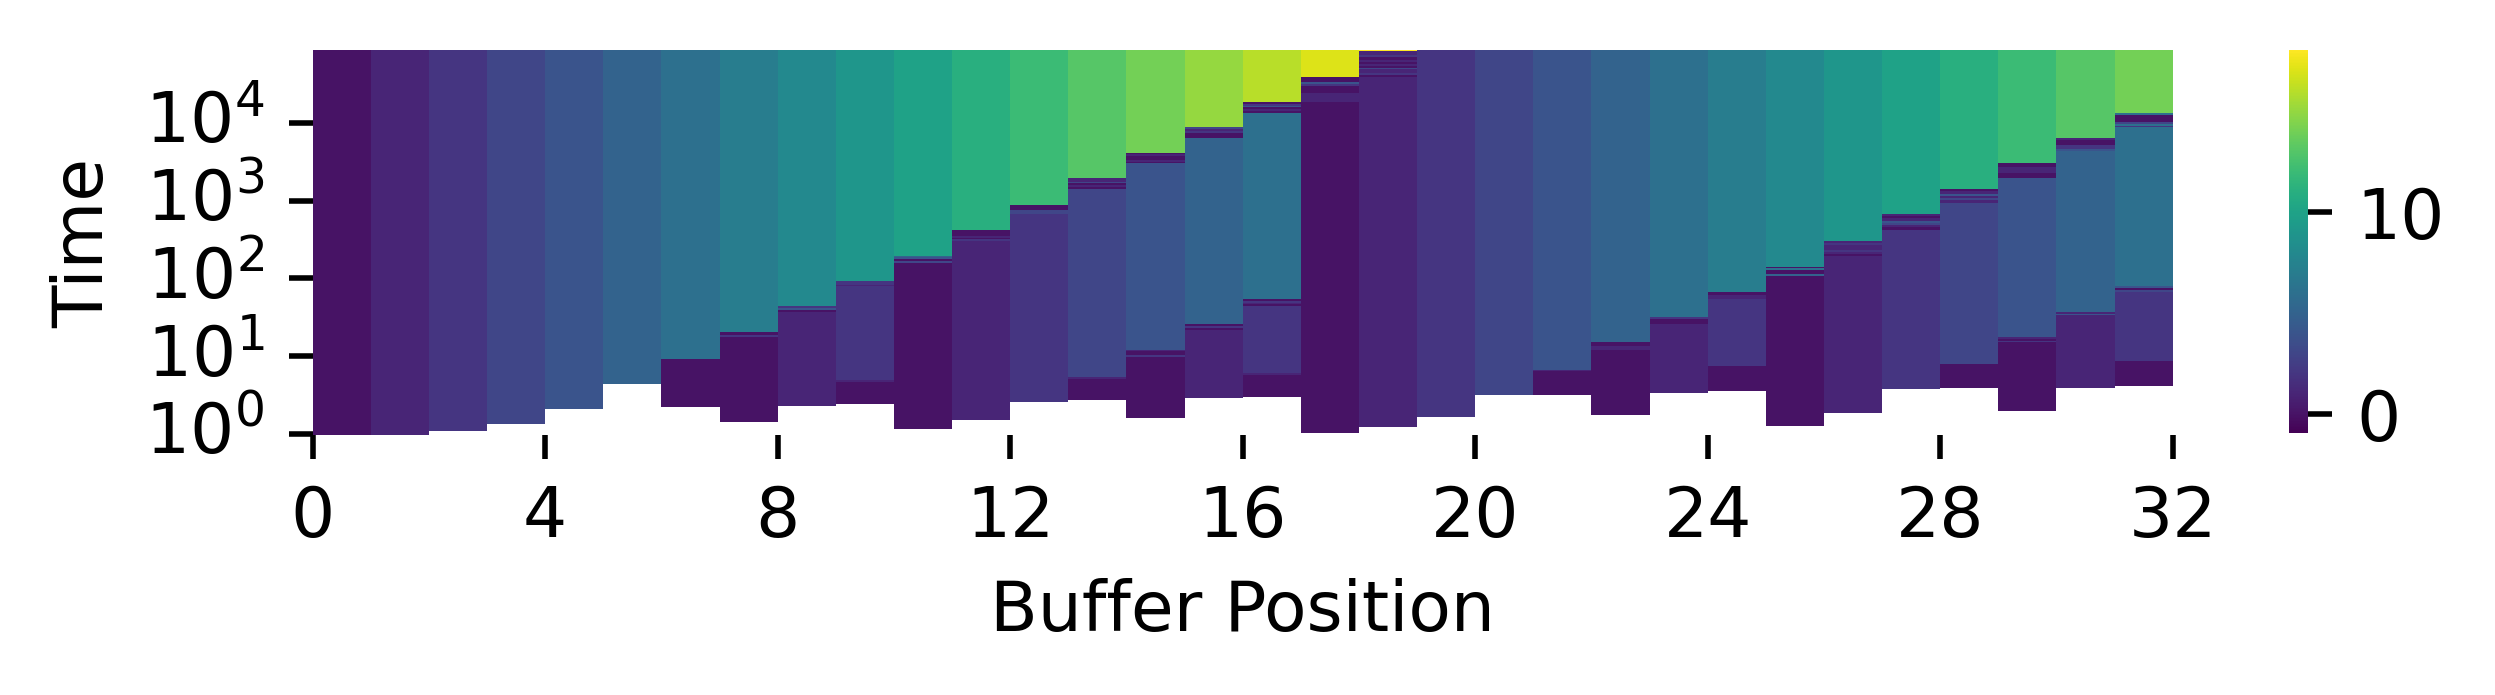

teeplots/40/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


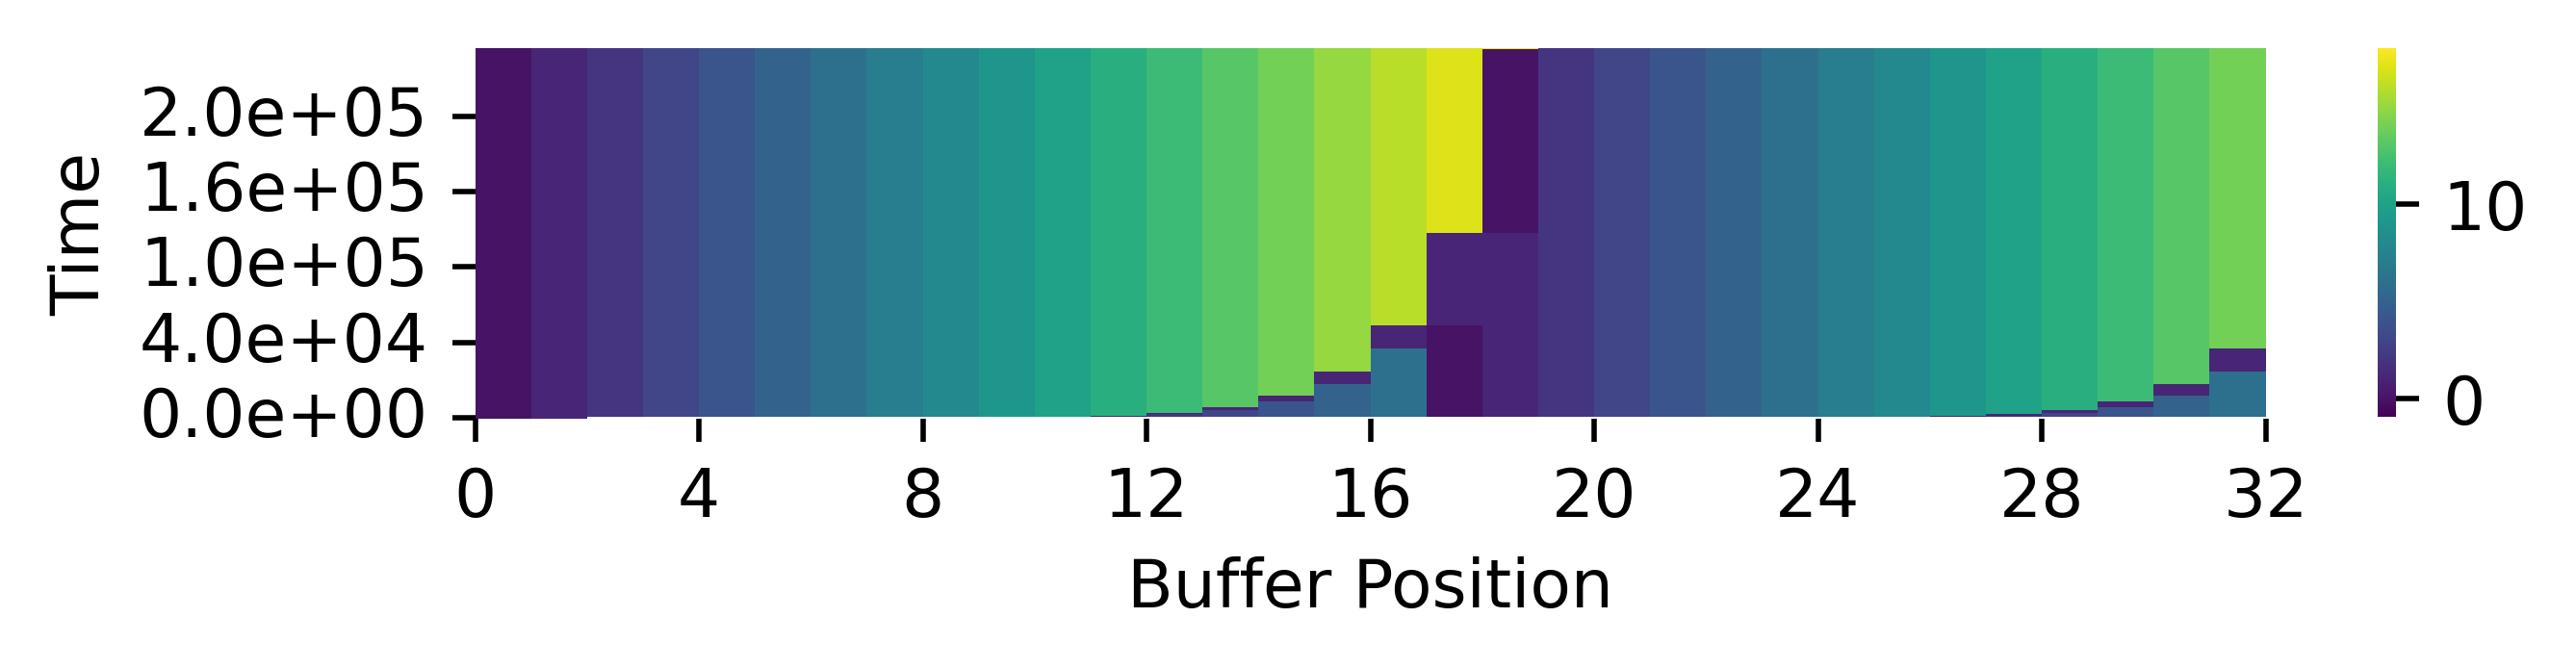

teeplots/40/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


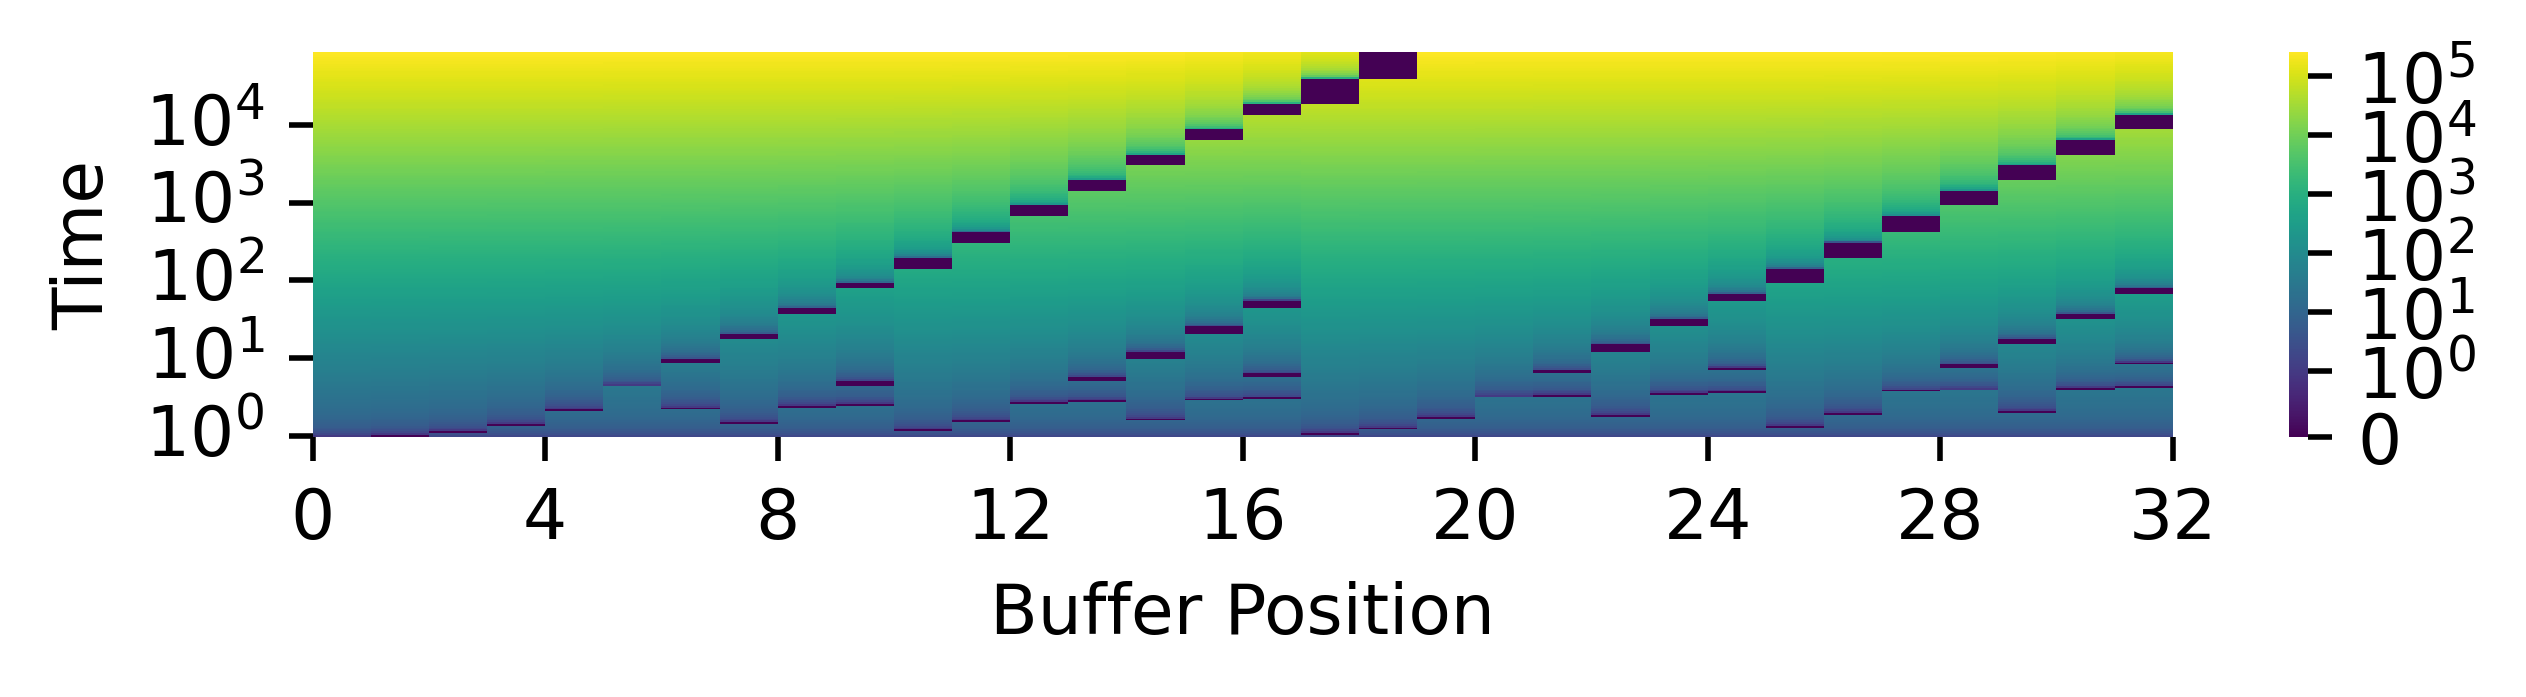

teeplots/40/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


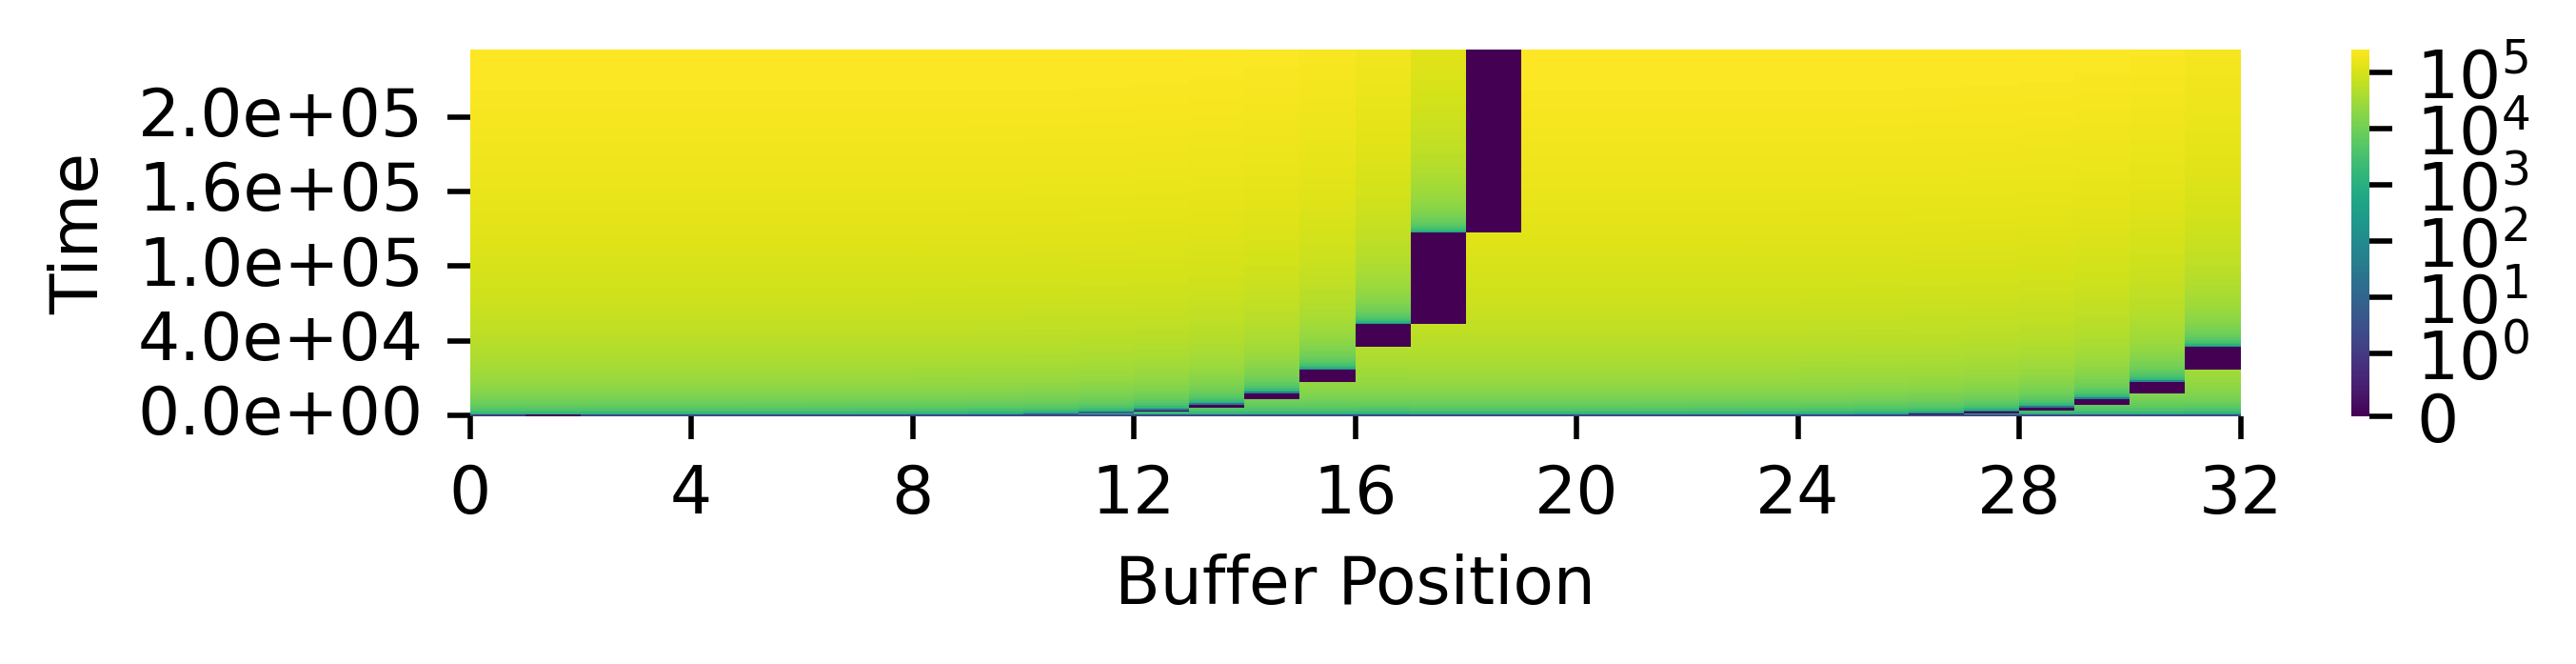

100%|██████████| 2998/2998 [00:08<00:00, 351.46it/s]


teeplots/40/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/40/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.png


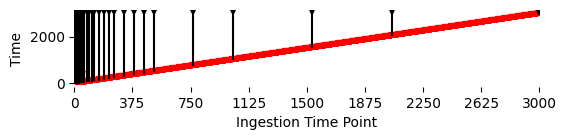

100%|██████████| 4096/4096 [00:00<00:00, 27384.13it/s]


teeplots/40/num-generations=4096+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/num-generations=4096+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


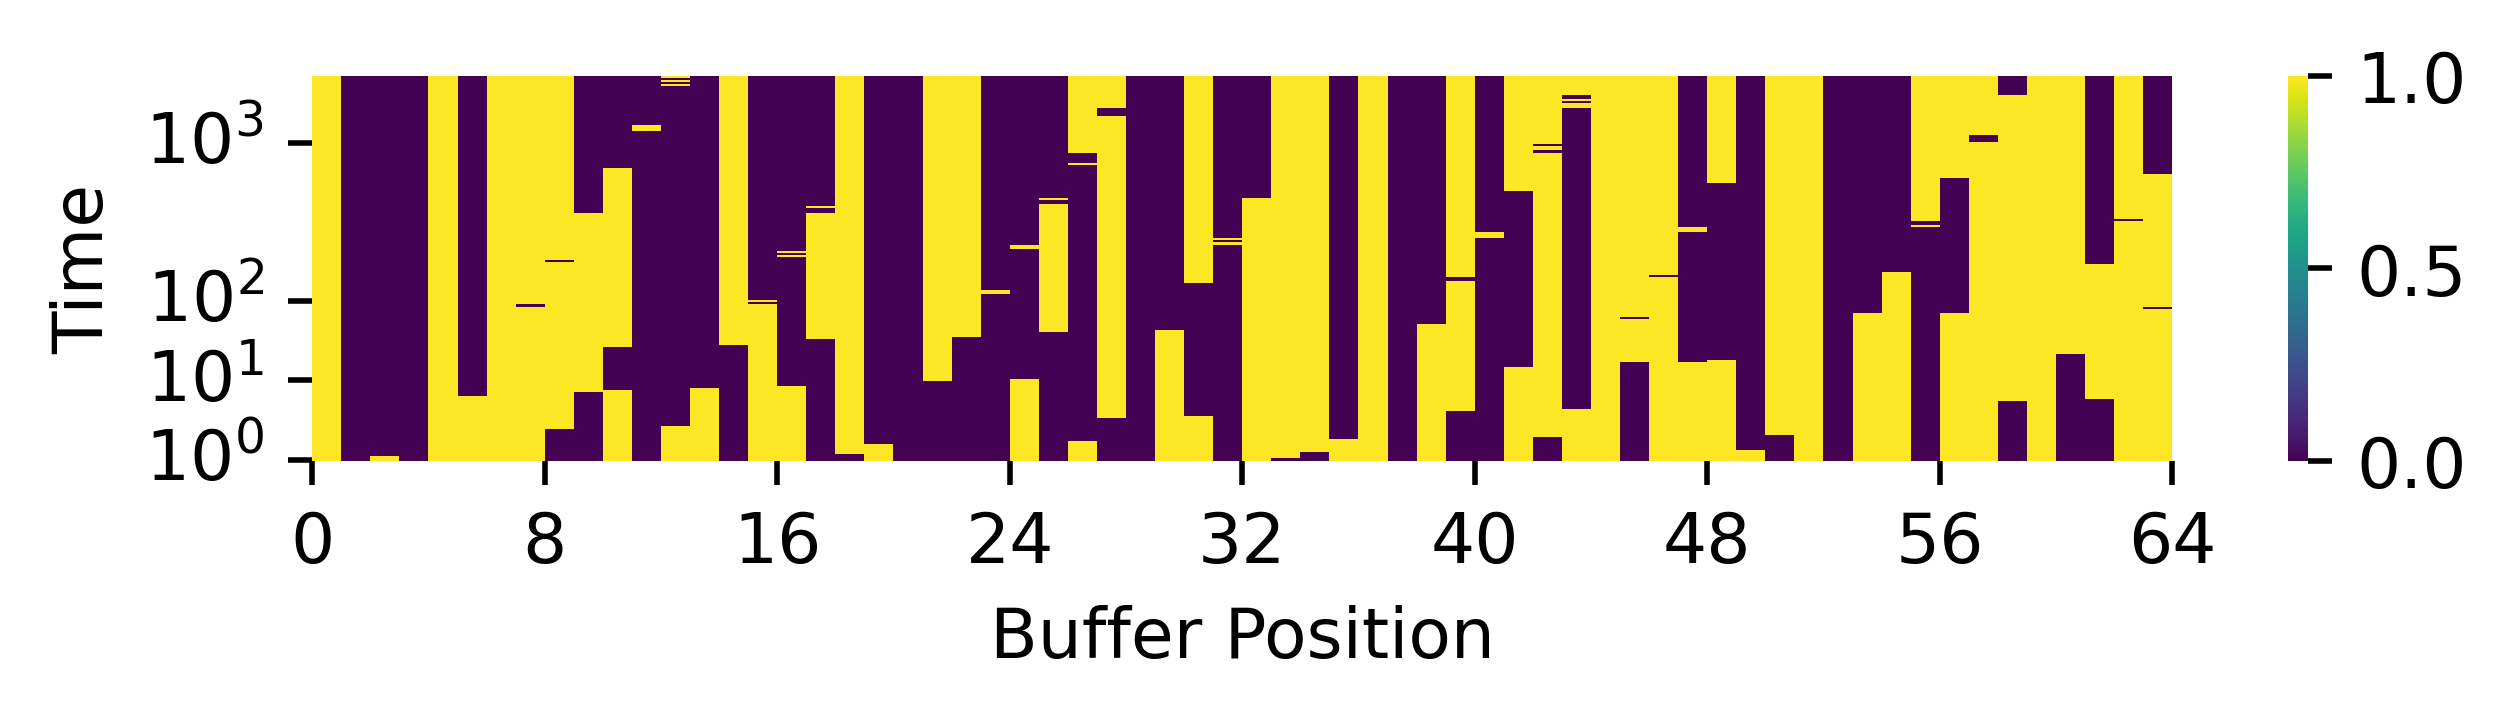

teeplots/40/num-generations=4096+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=4096+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


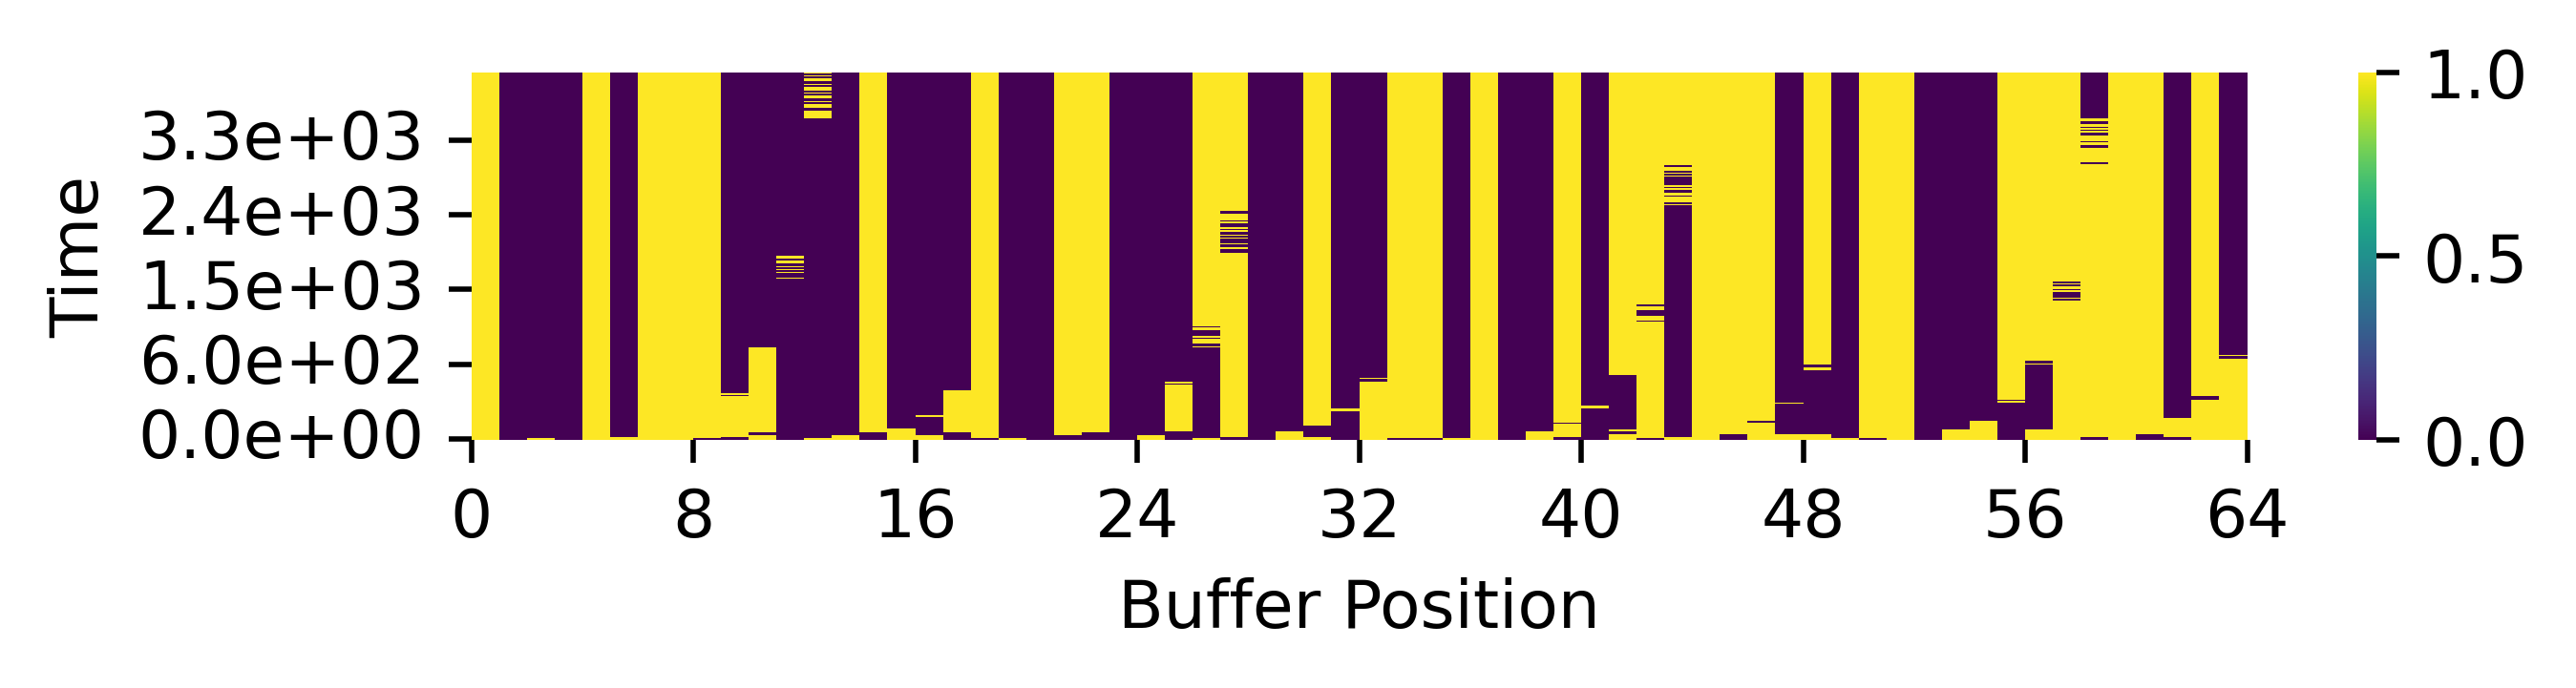

teeplots/40/cnorm=log+num-generations=4096+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


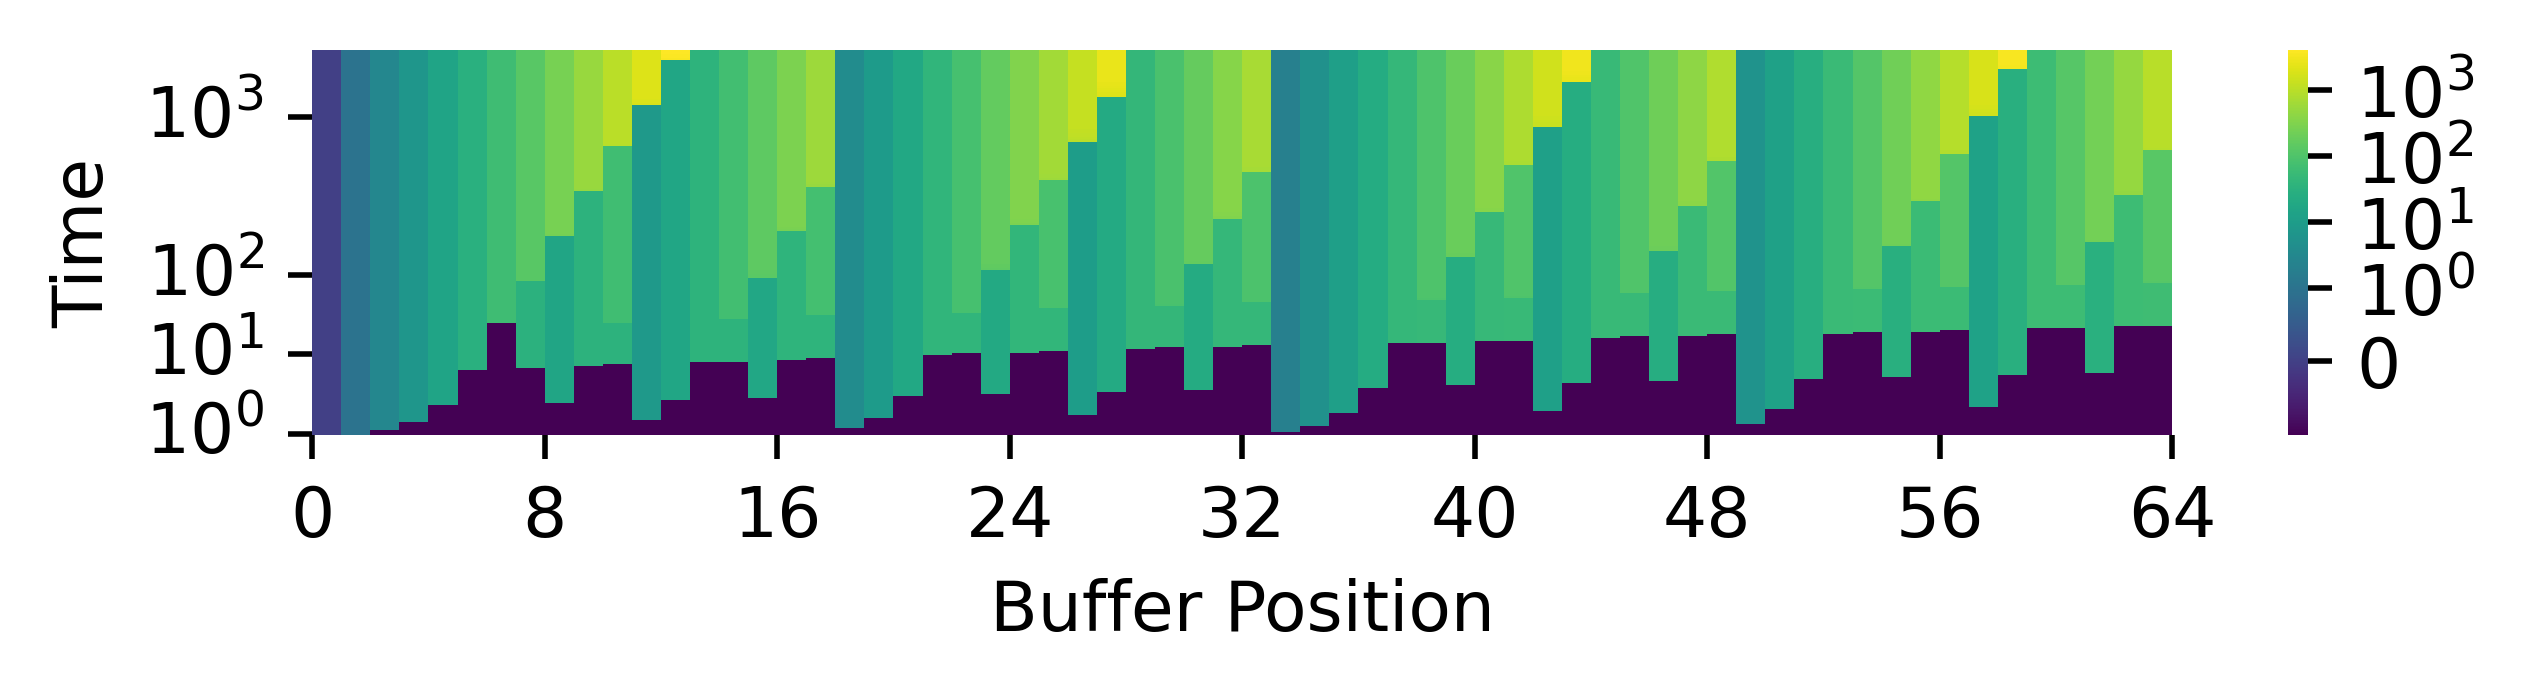

teeplots/40/cnorm=None+num-generations=4096+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=None+num-generations=4096+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


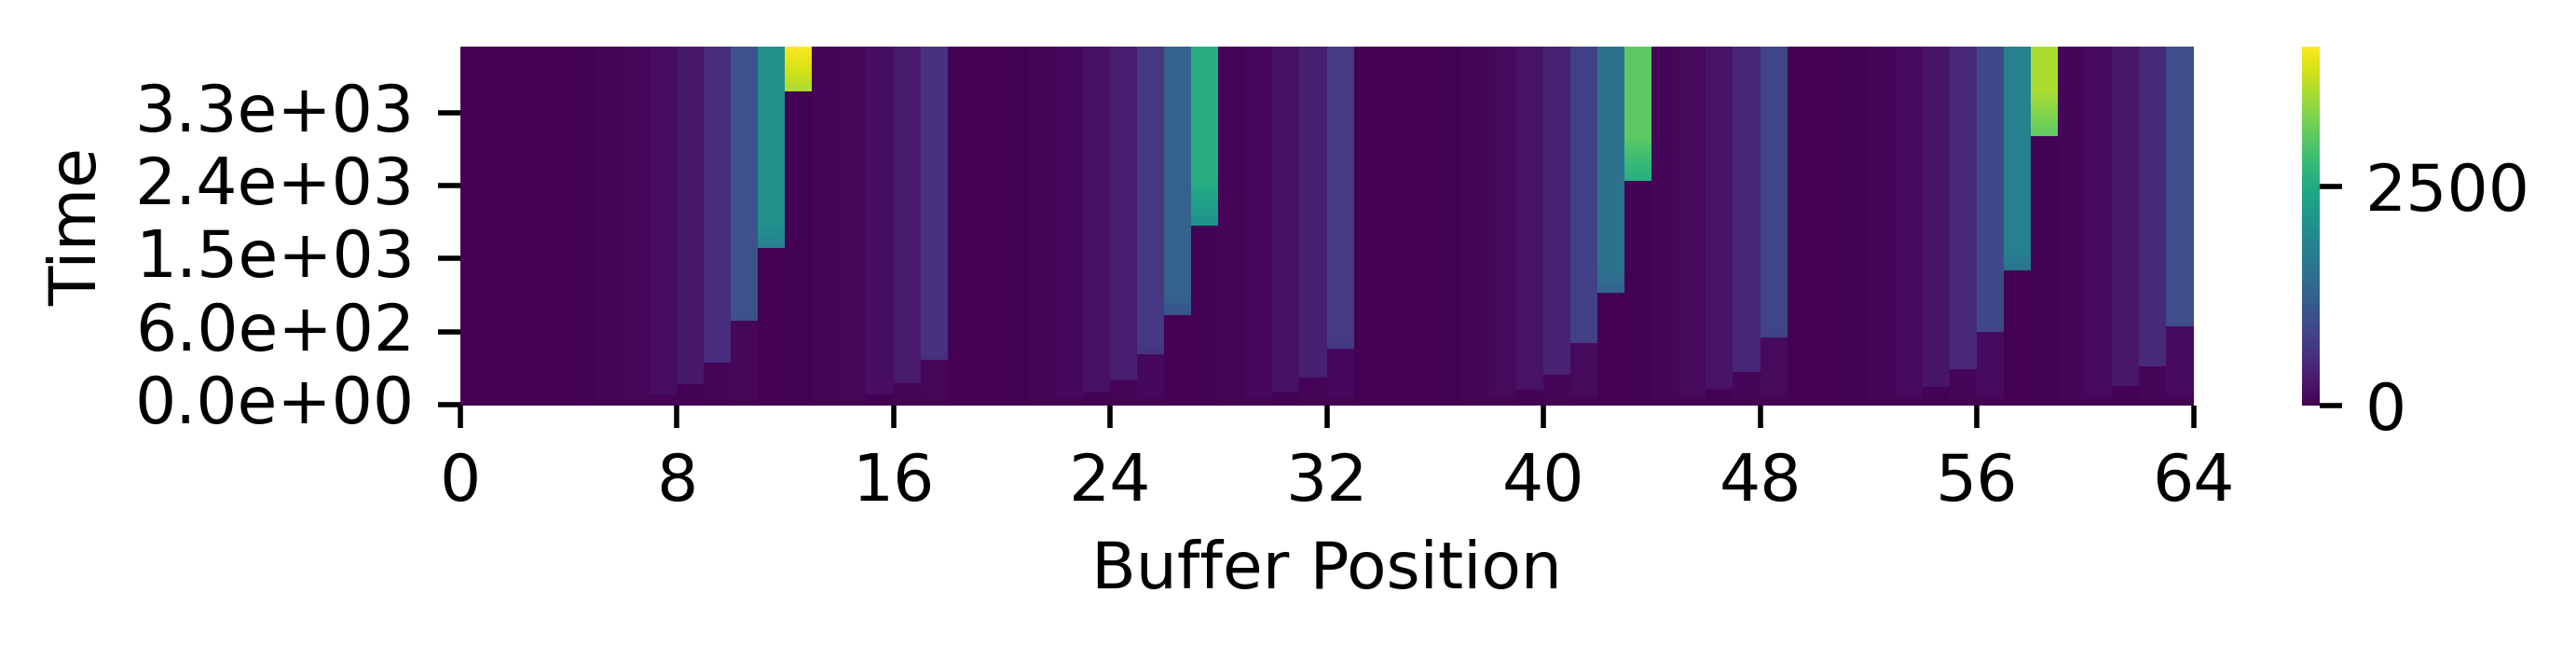

teeplots/40/num-generations=4096+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=4096+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ext=.png


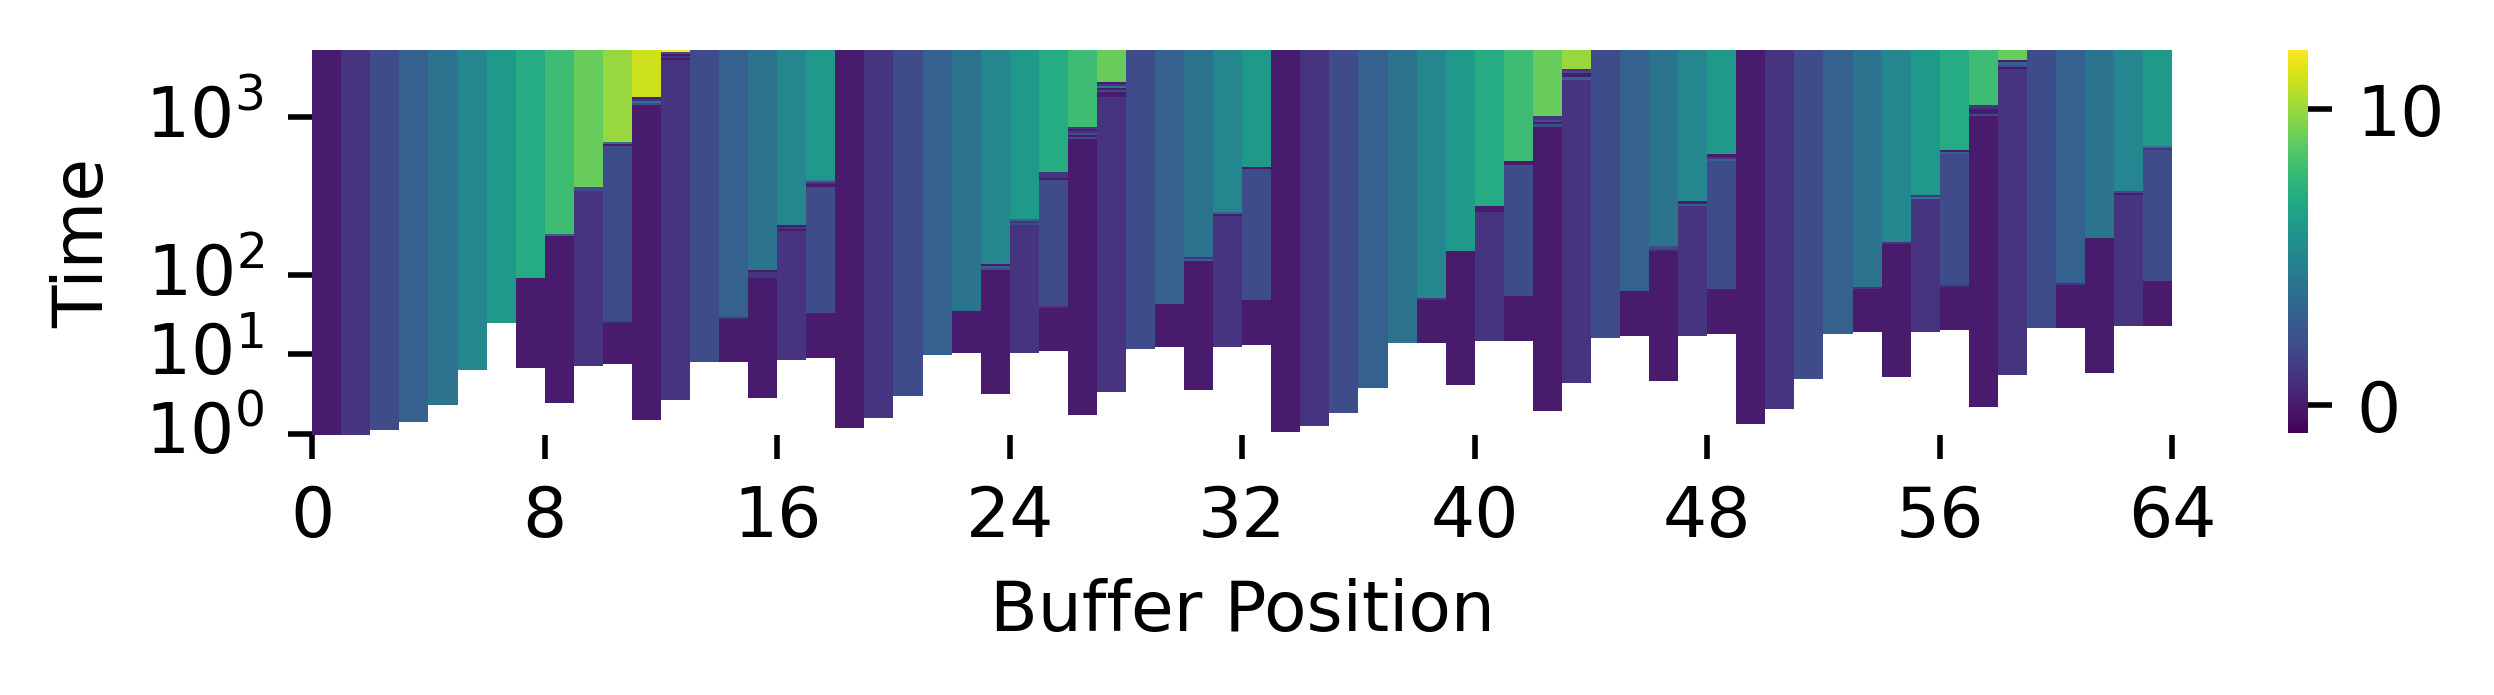

teeplots/40/num-generations=4096+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=4096+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


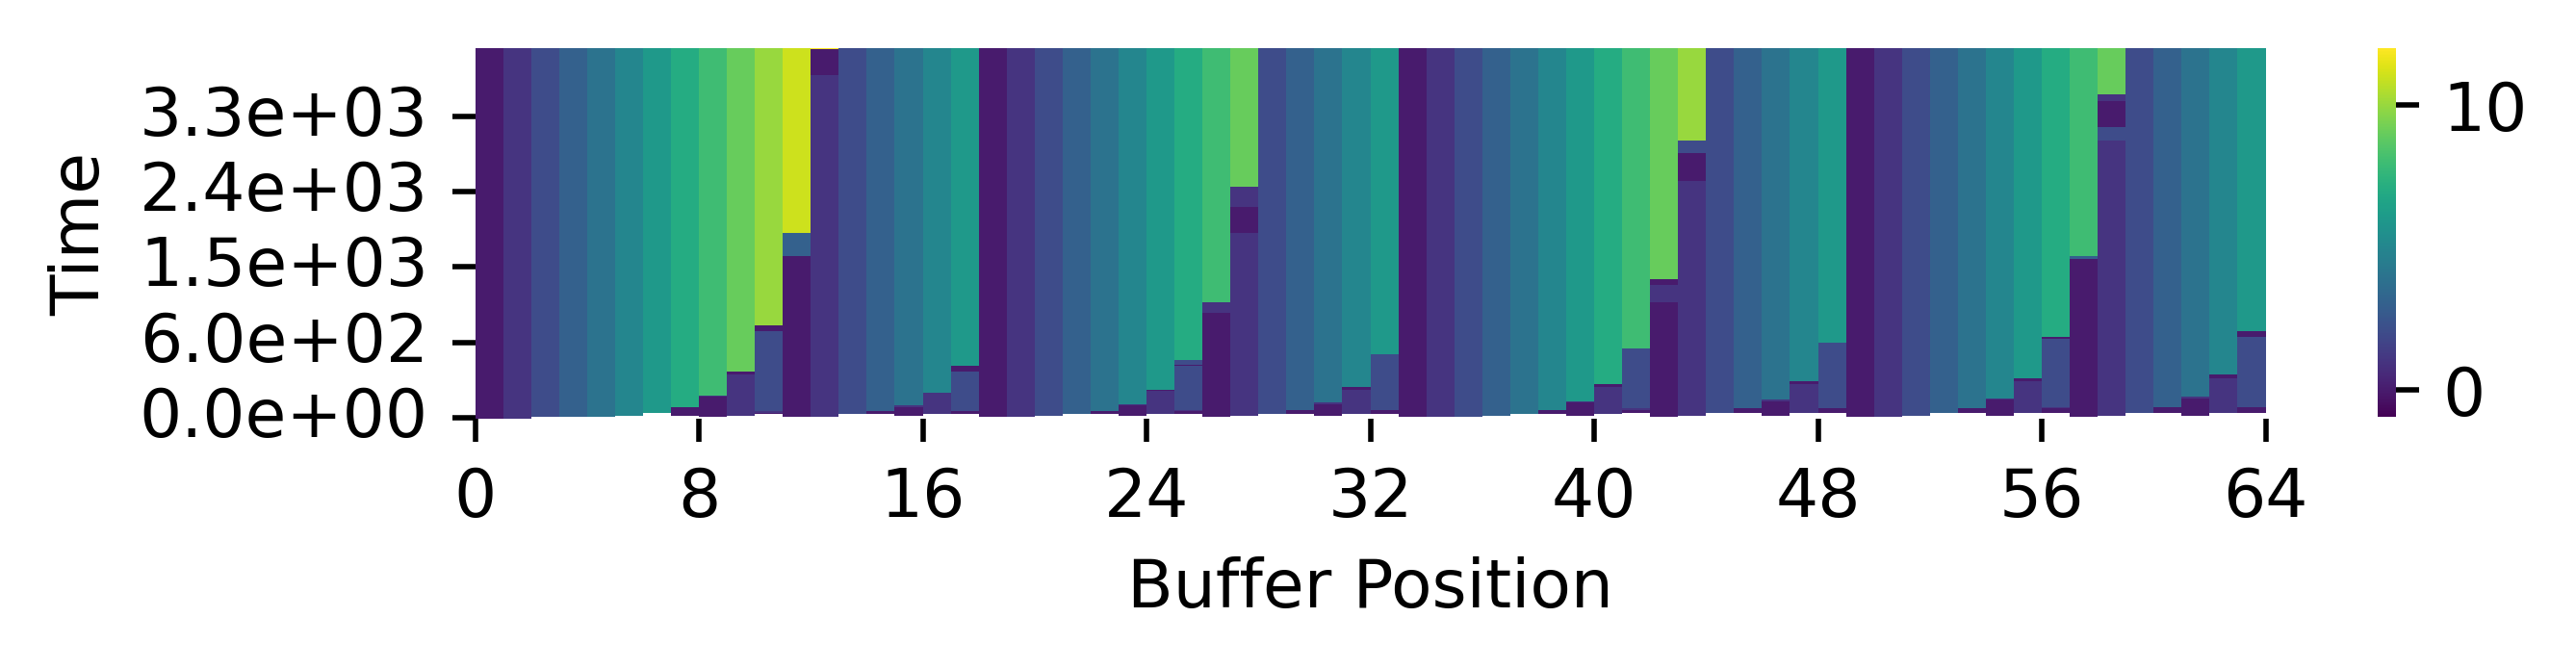

teeplots/40/cnorm=log+num-generations=4096+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


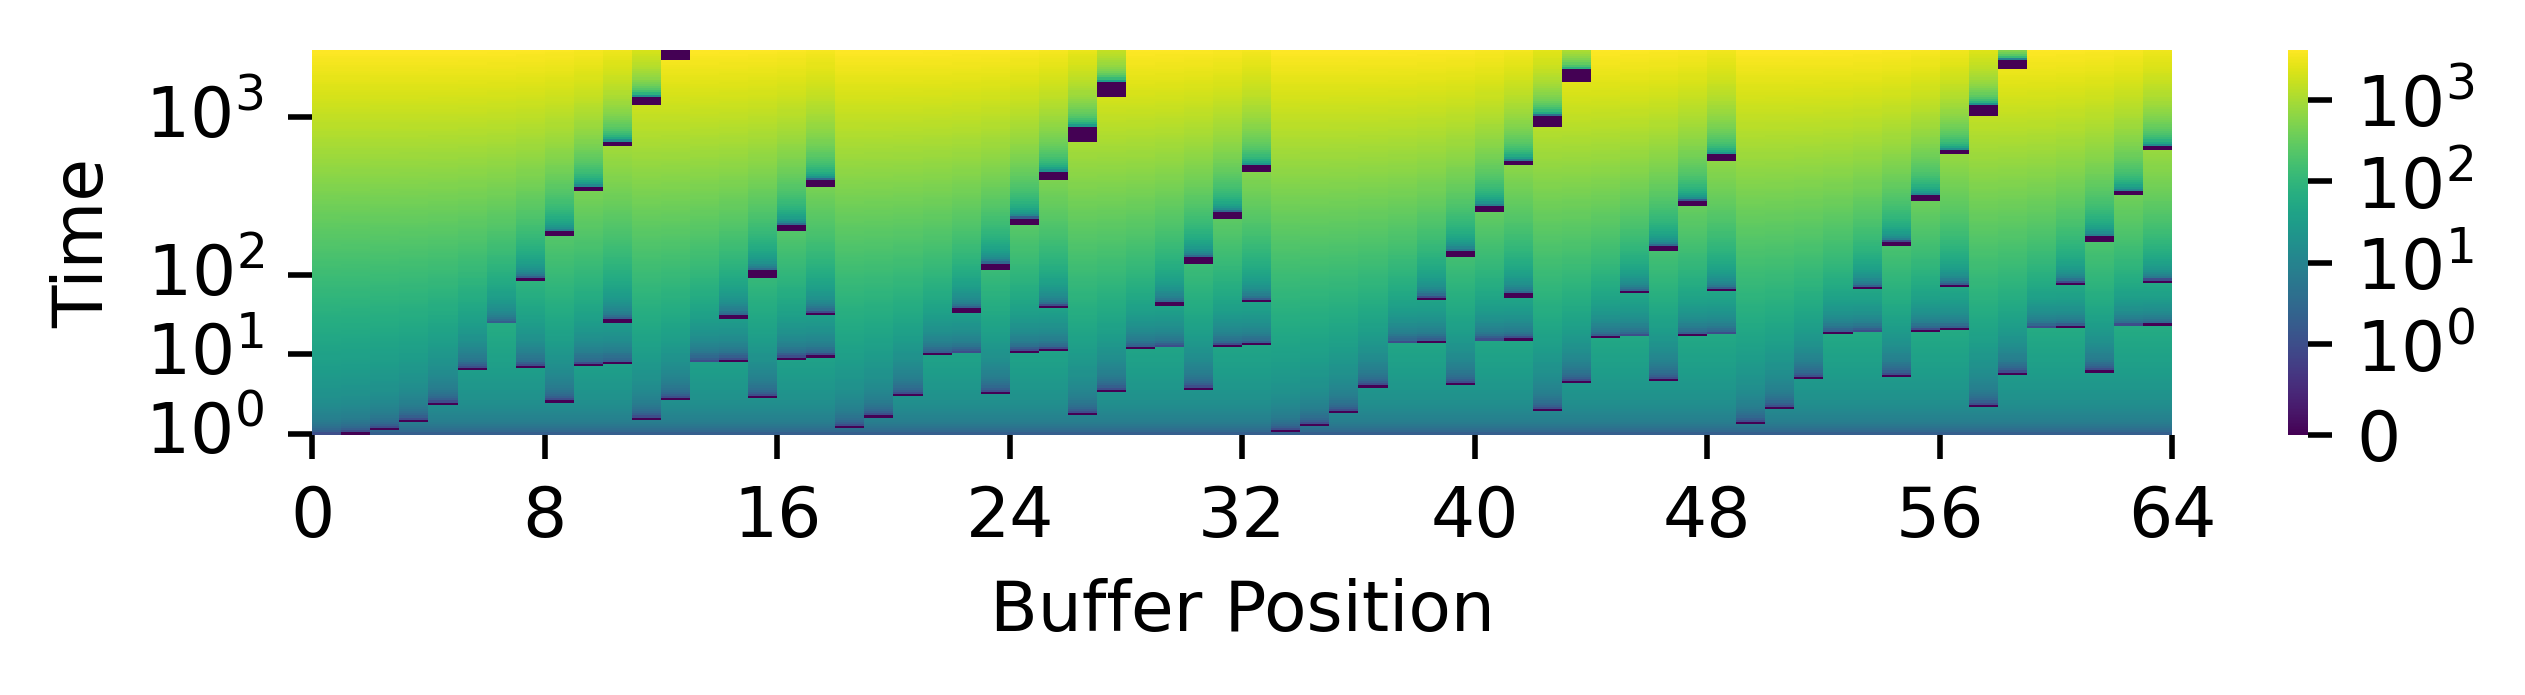

teeplots/40/cnorm=log+num-generations=4096+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


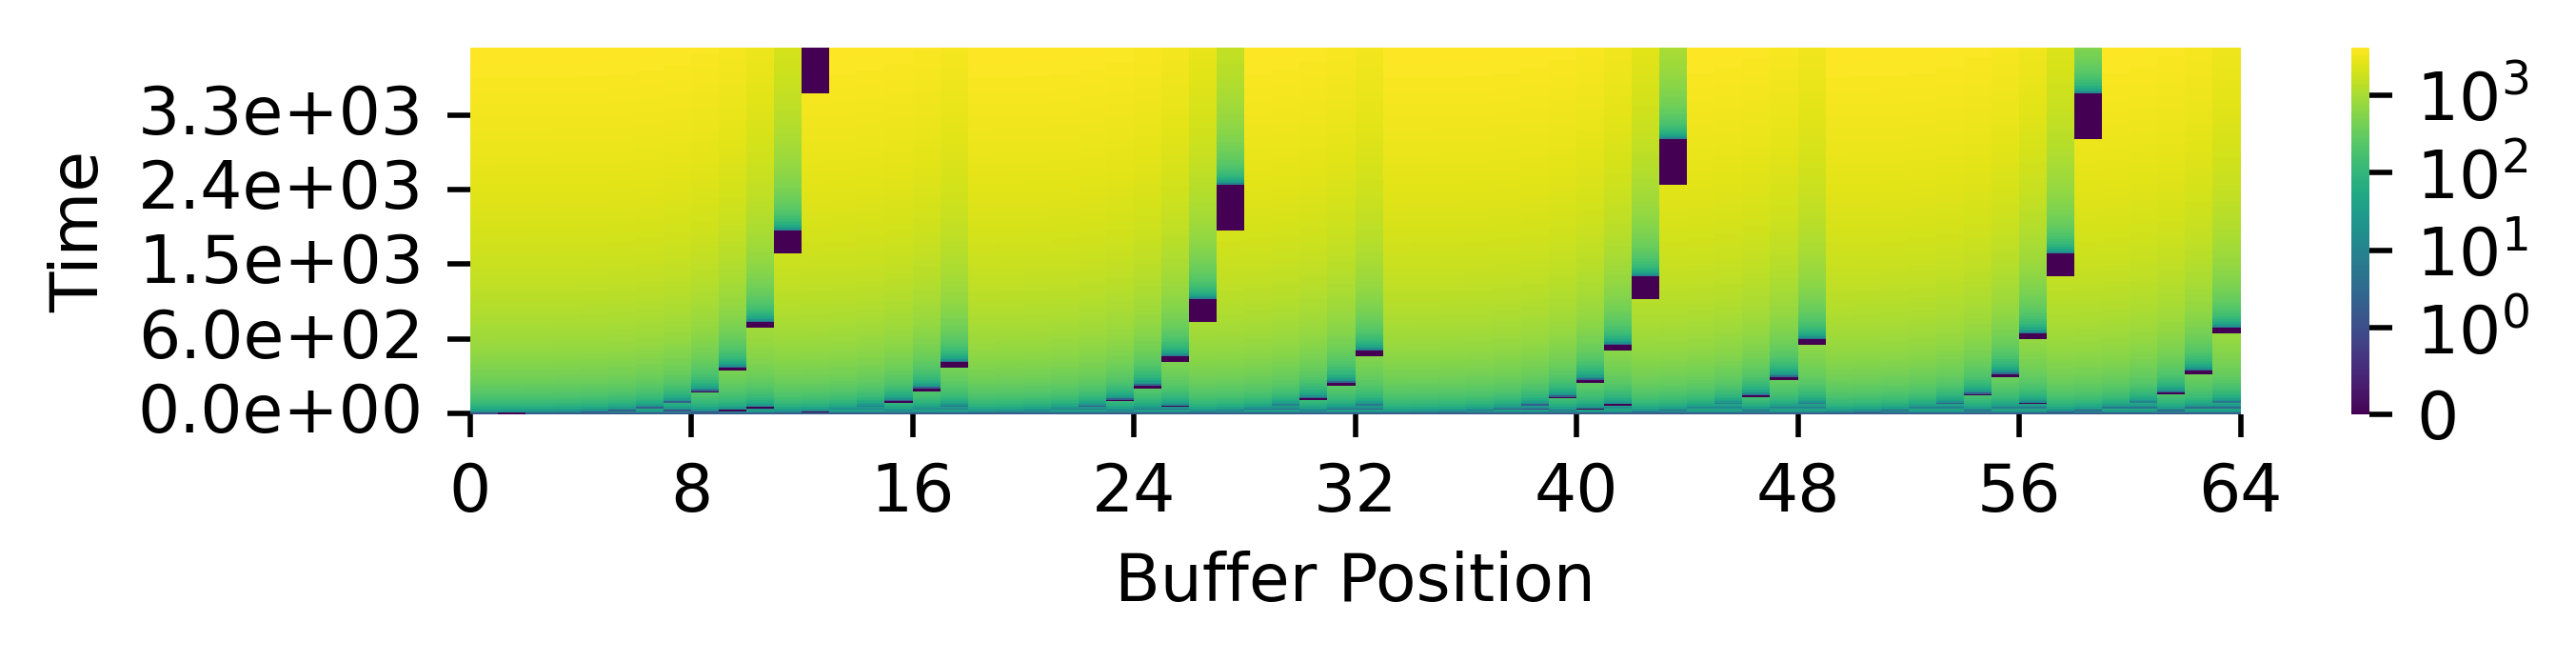

100%|██████████| 2998/2998 [00:08<00:00, 338.20it/s]


teeplots/40/num-generations=4096+surface-size=64+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/40/num-generations=4096+surface-size=64+viz=stratum-persistence-dripplot+ext=.png


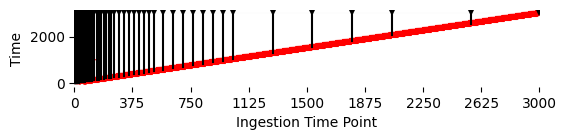

100%|██████████| 4096/4096 [00:00<00:00, 16936.61it/s]


teeplots/40/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


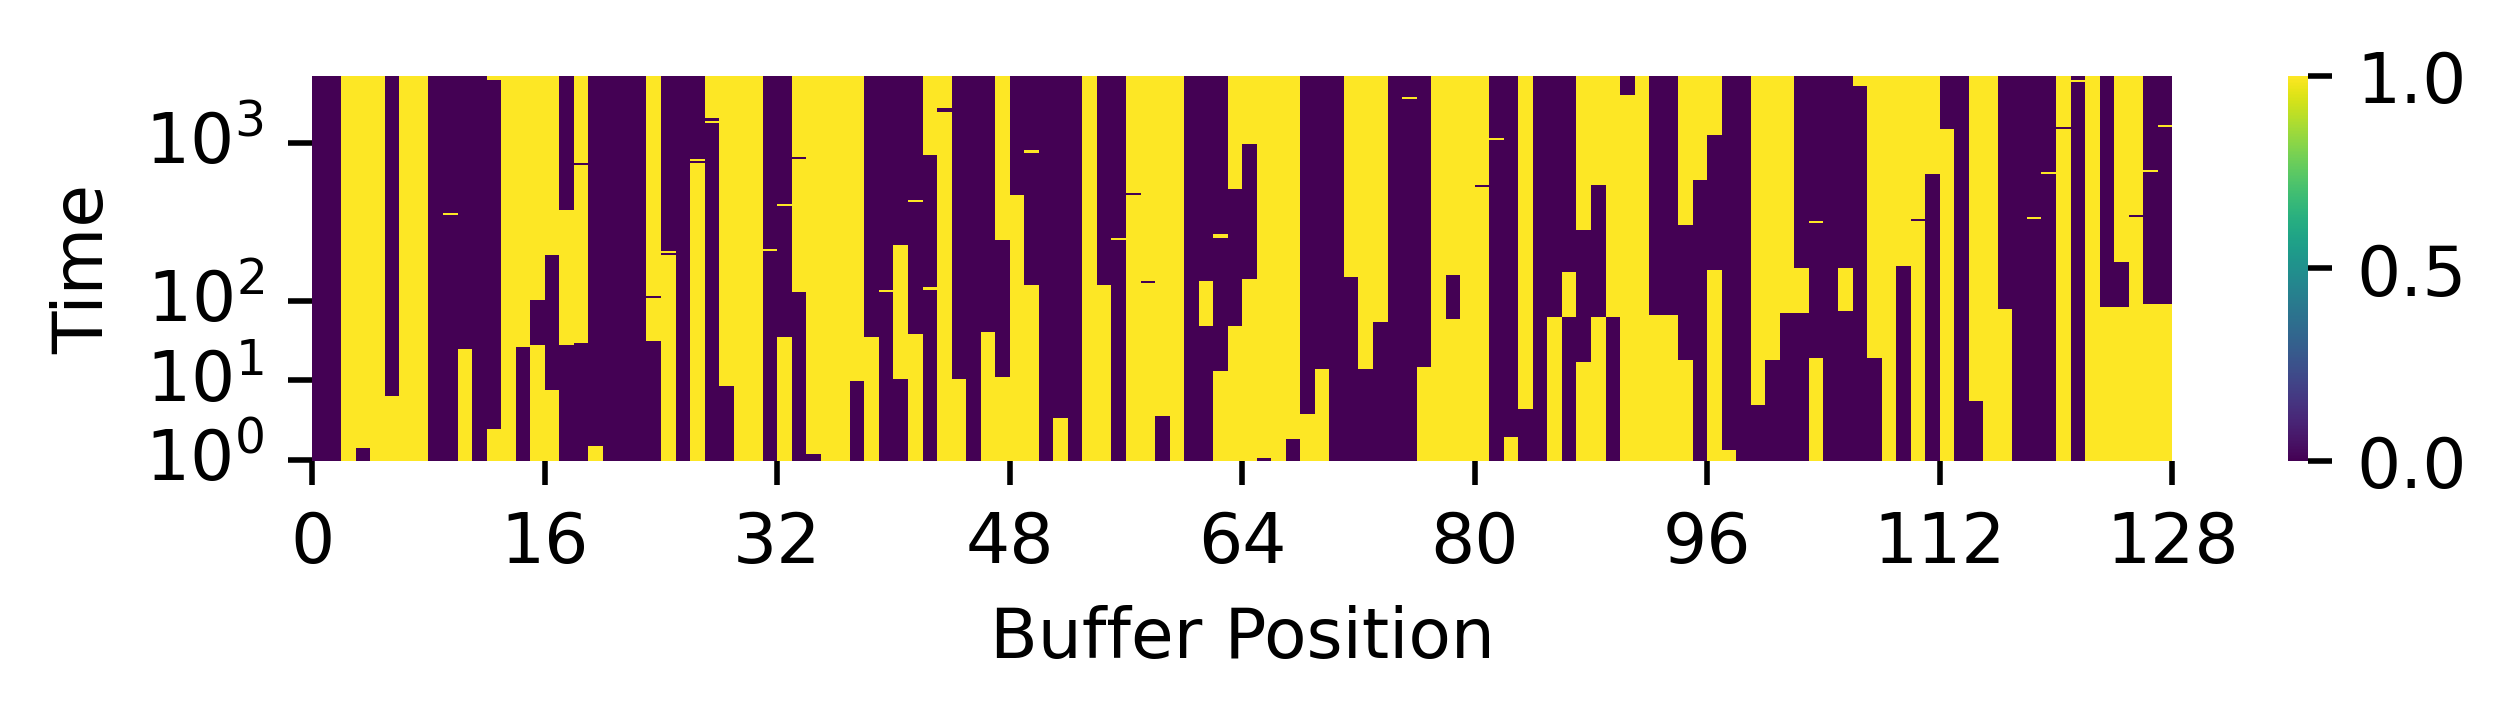

teeplots/40/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


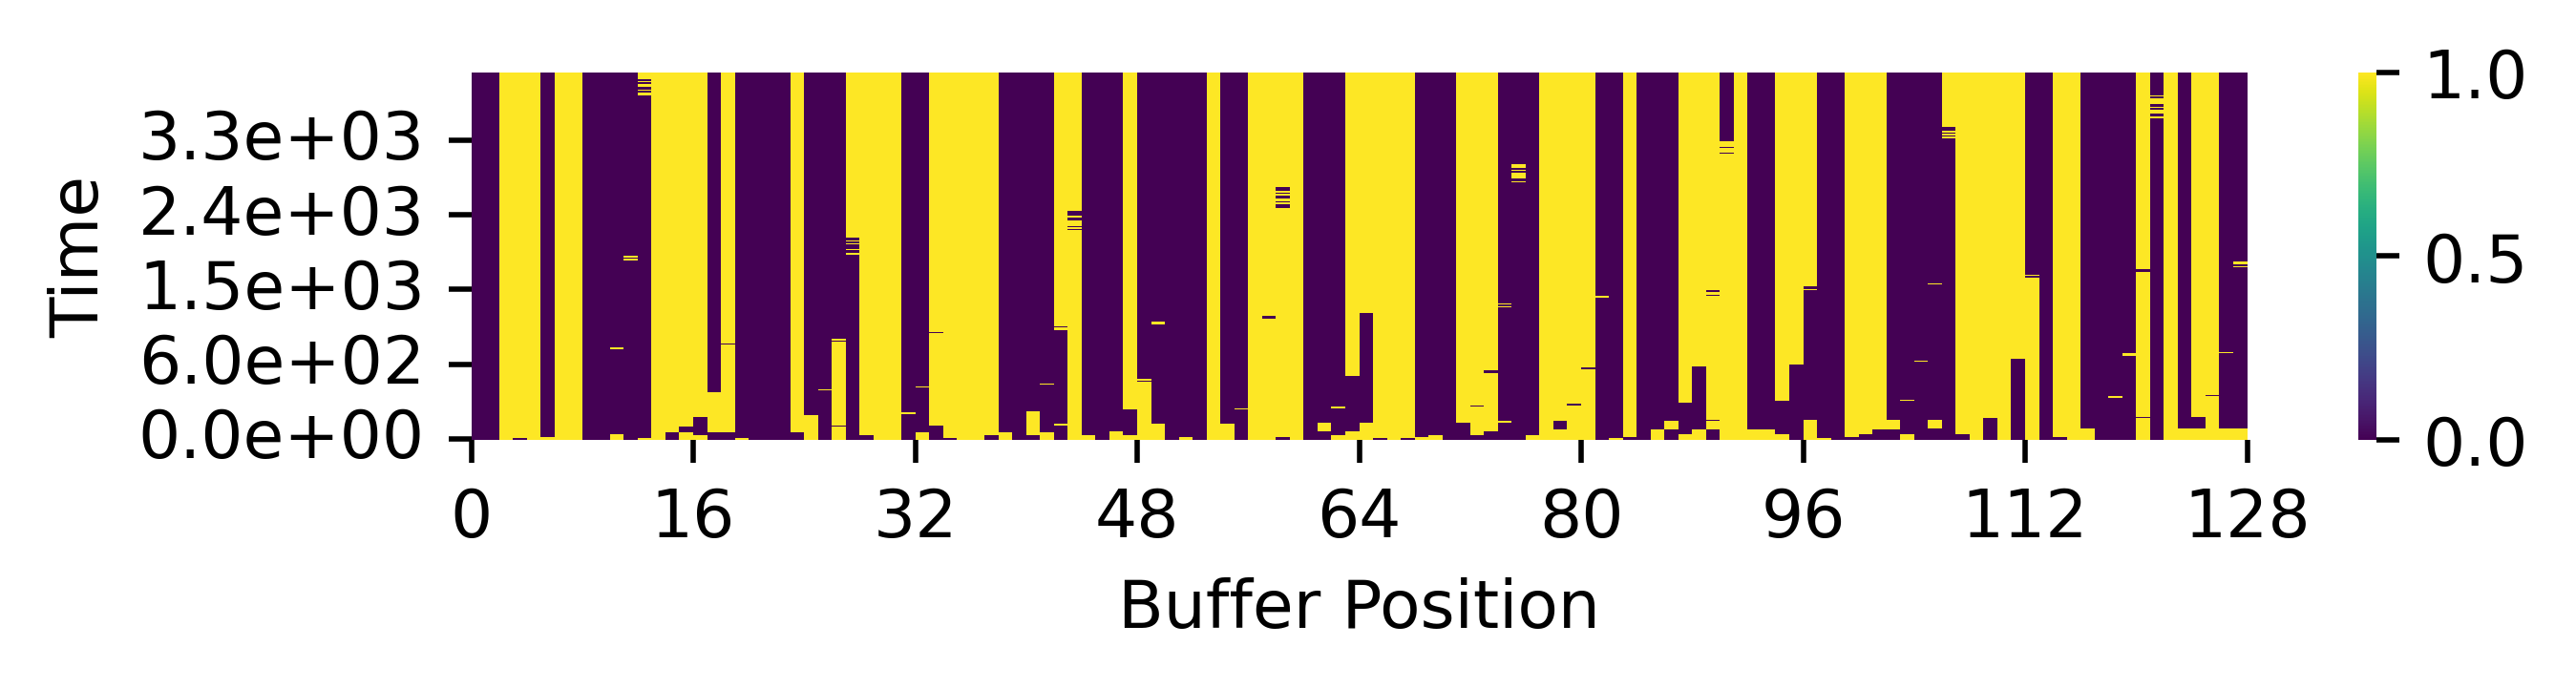

teeplots/40/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


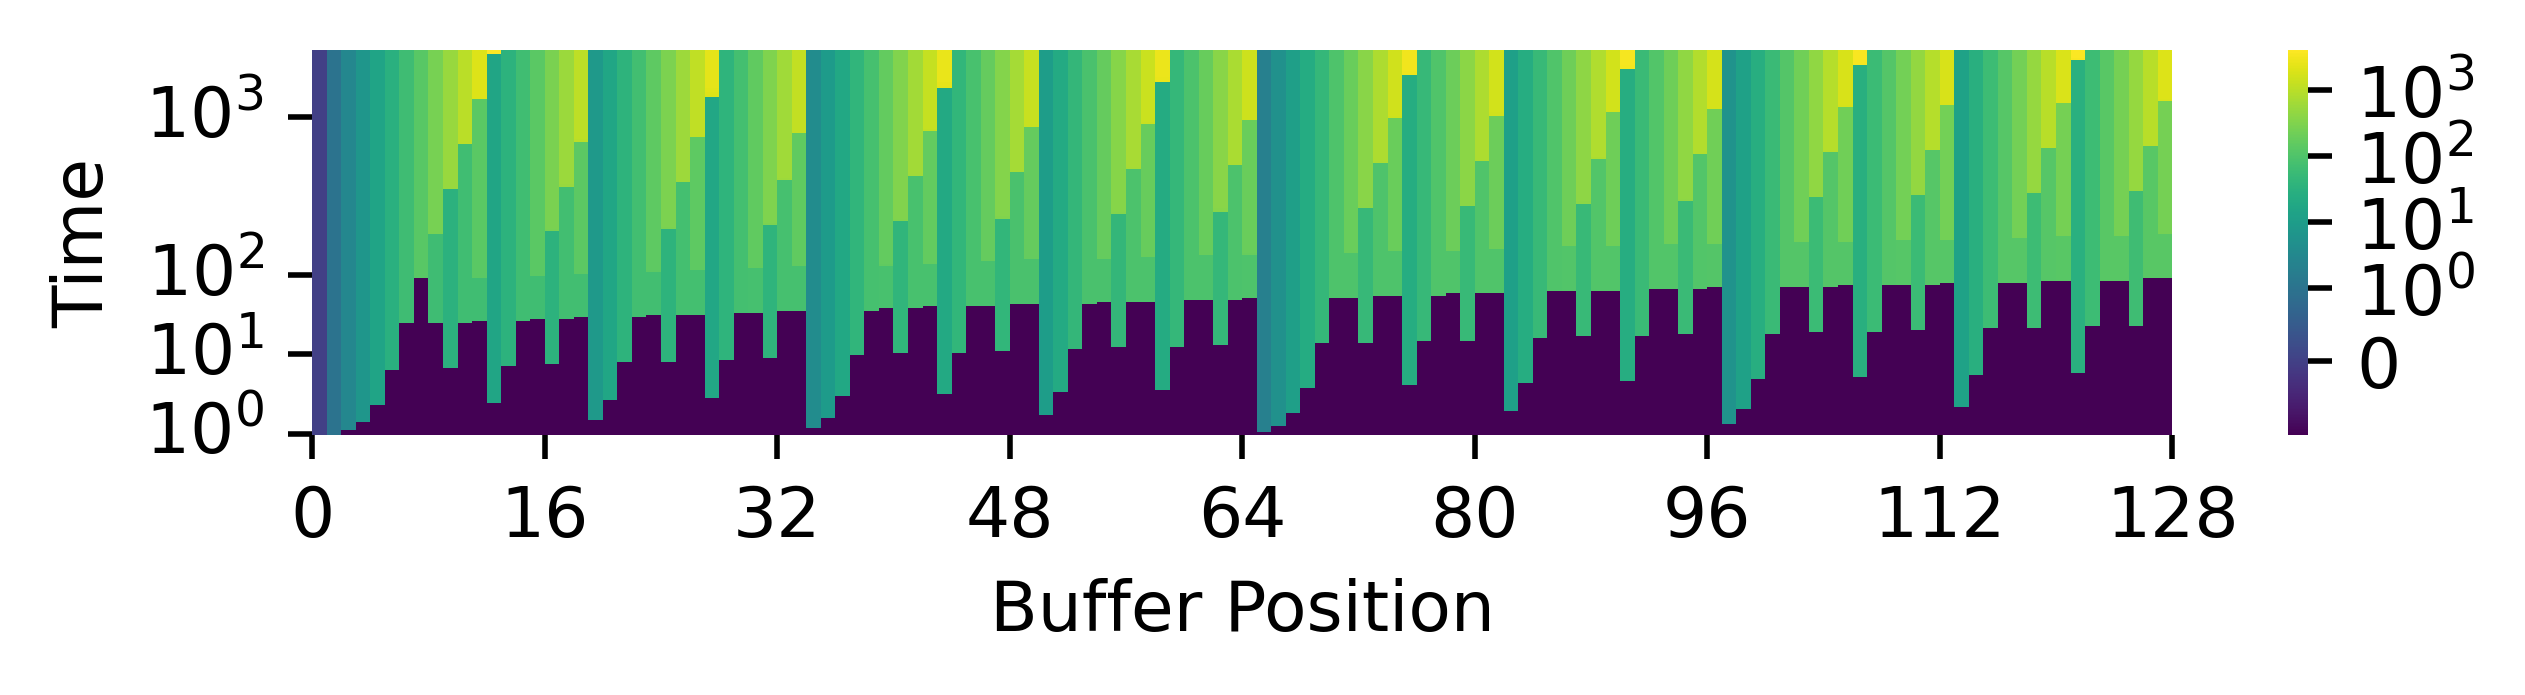

teeplots/40/cnorm=None+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=None+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


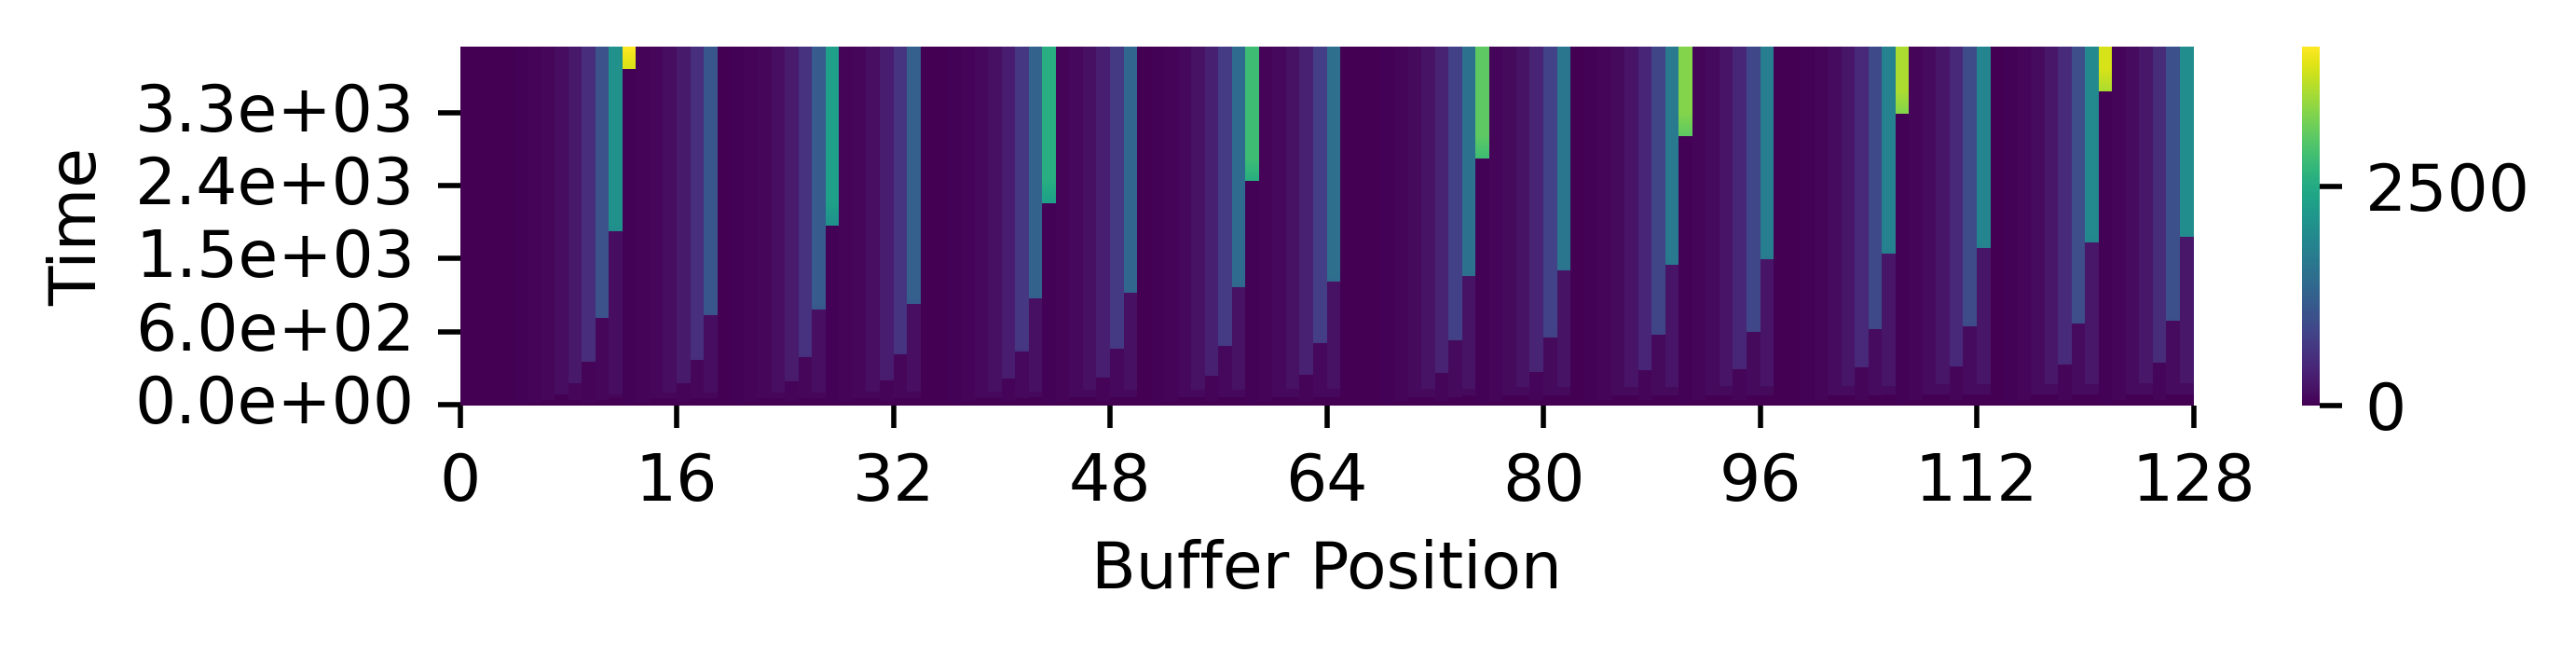

teeplots/40/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.png


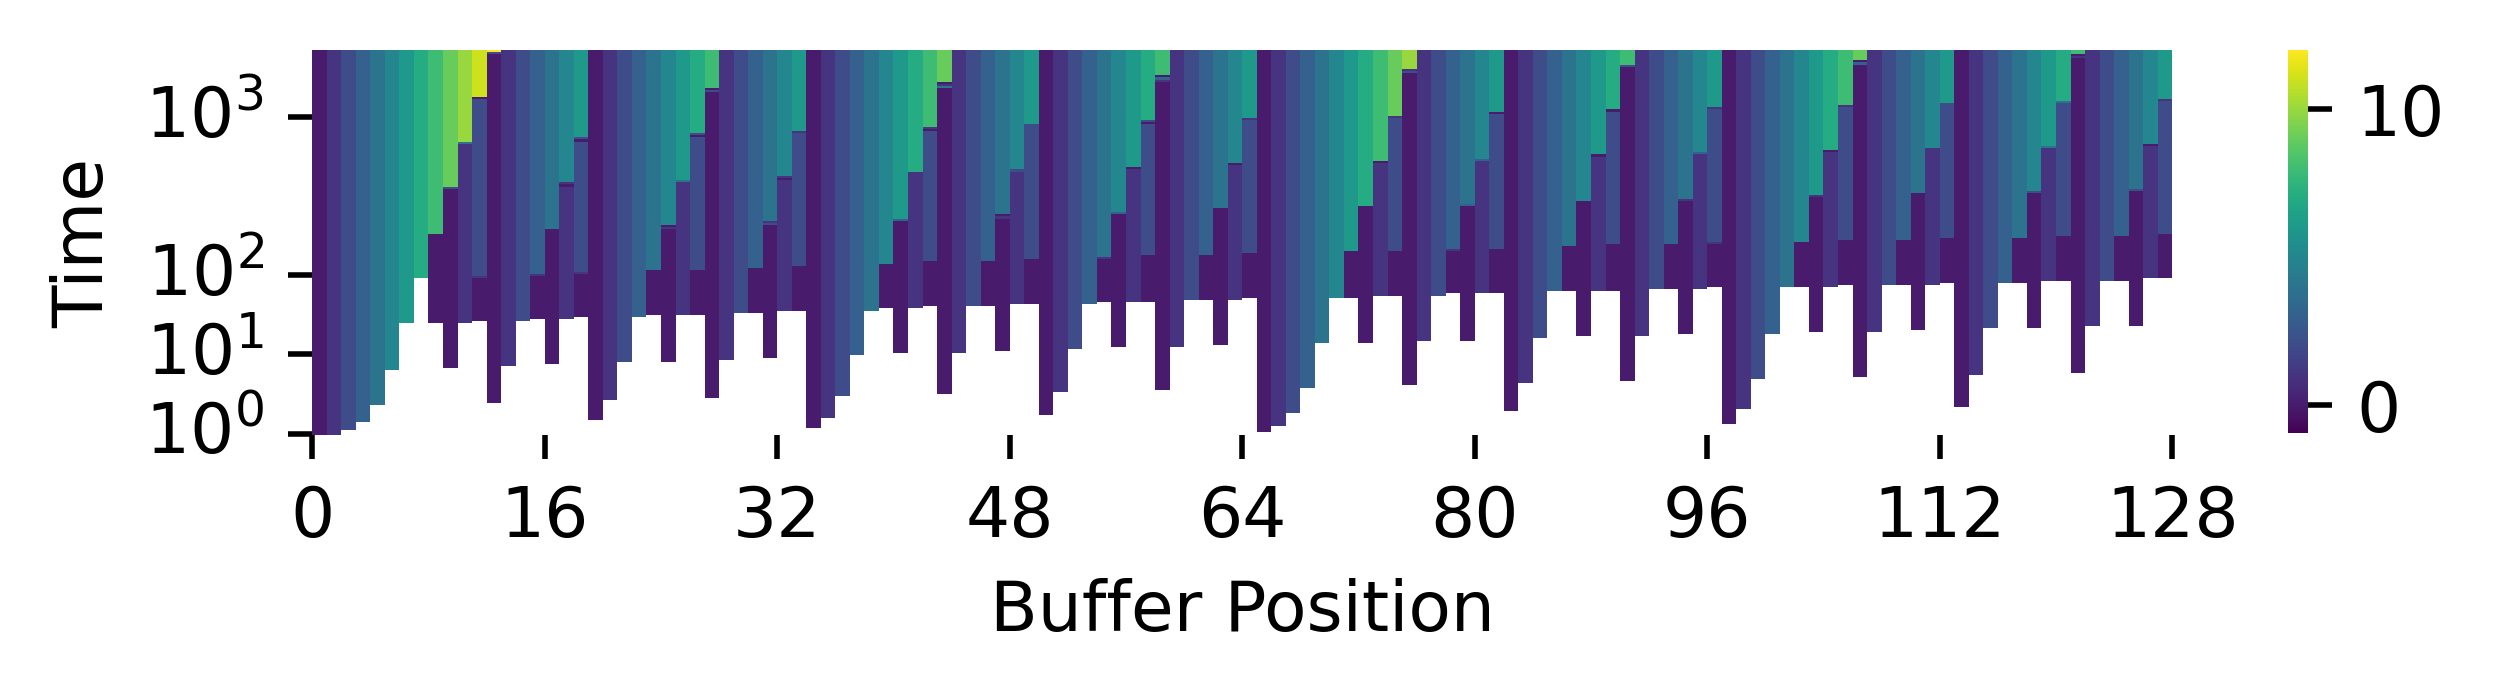

teeplots/40/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


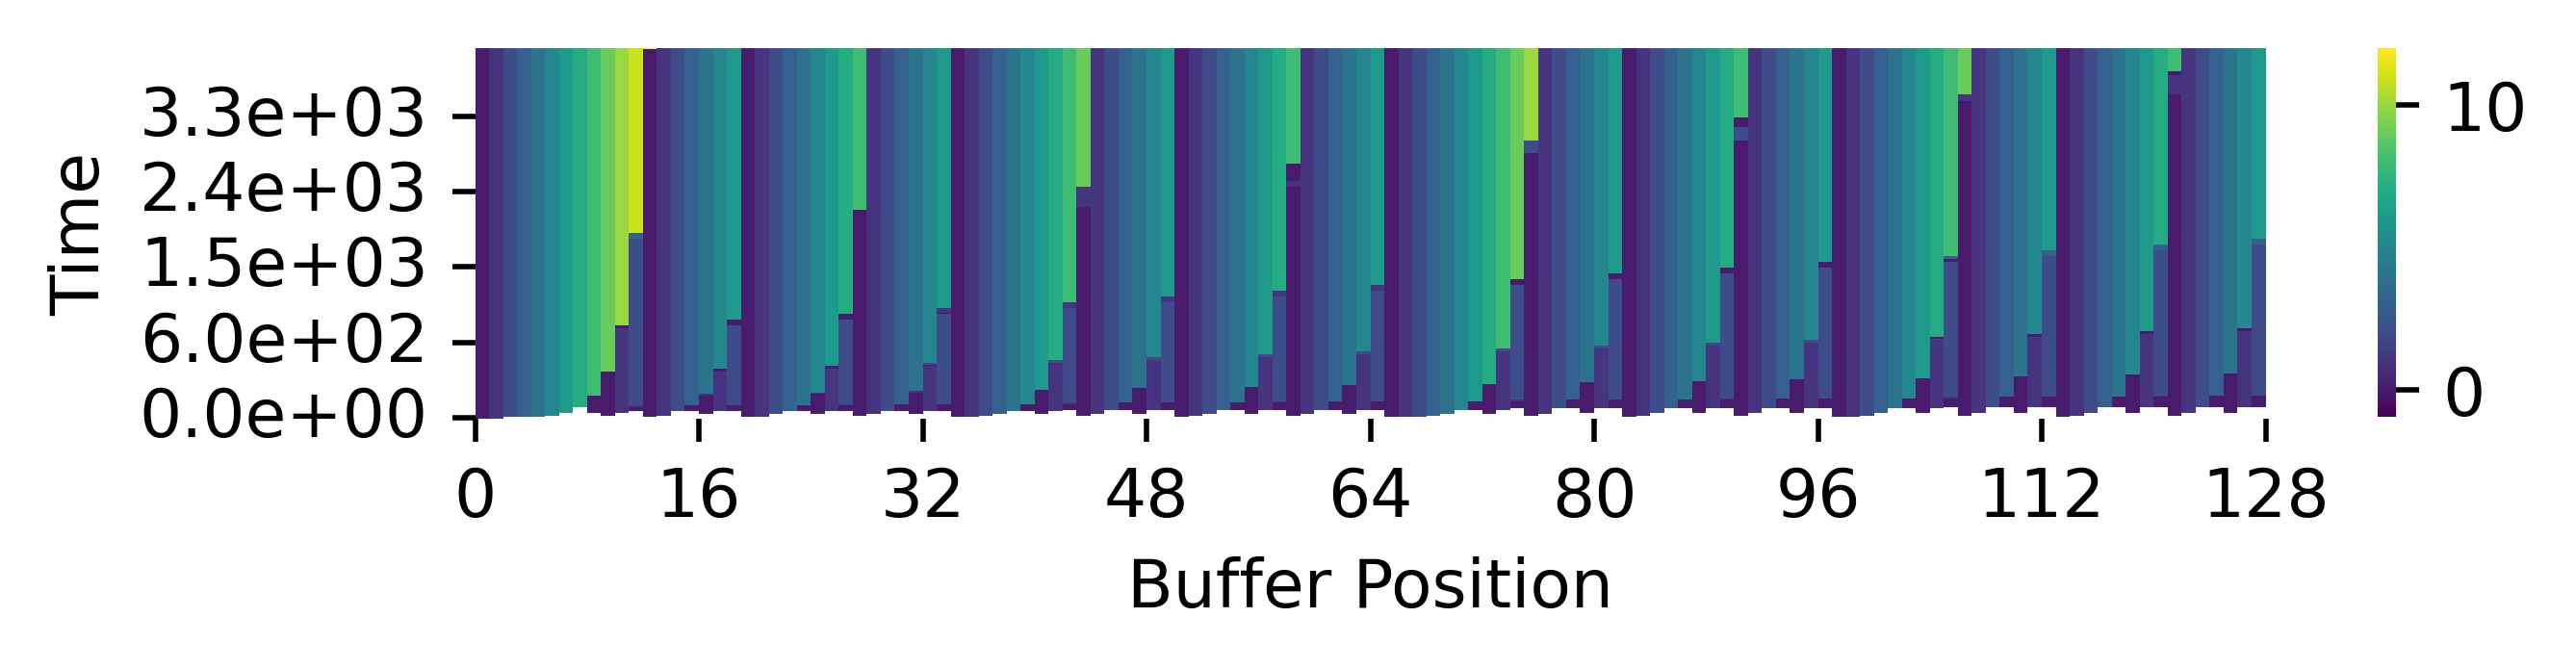

teeplots/40/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


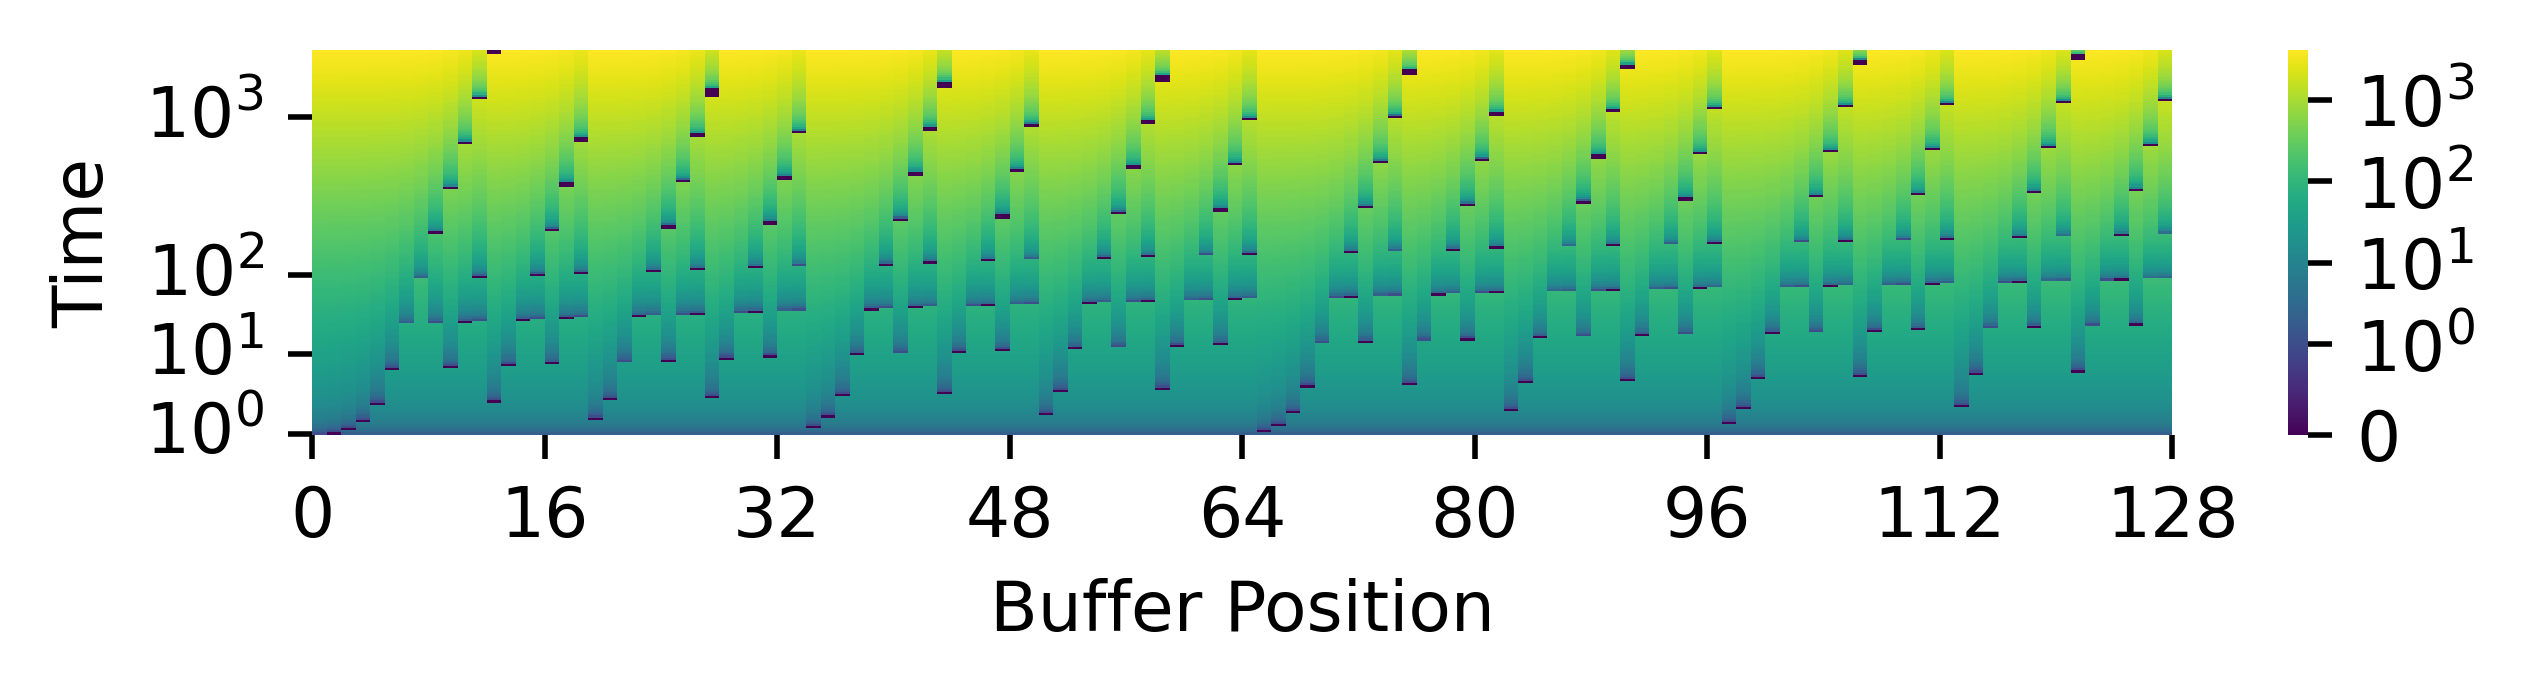

teeplots/40/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


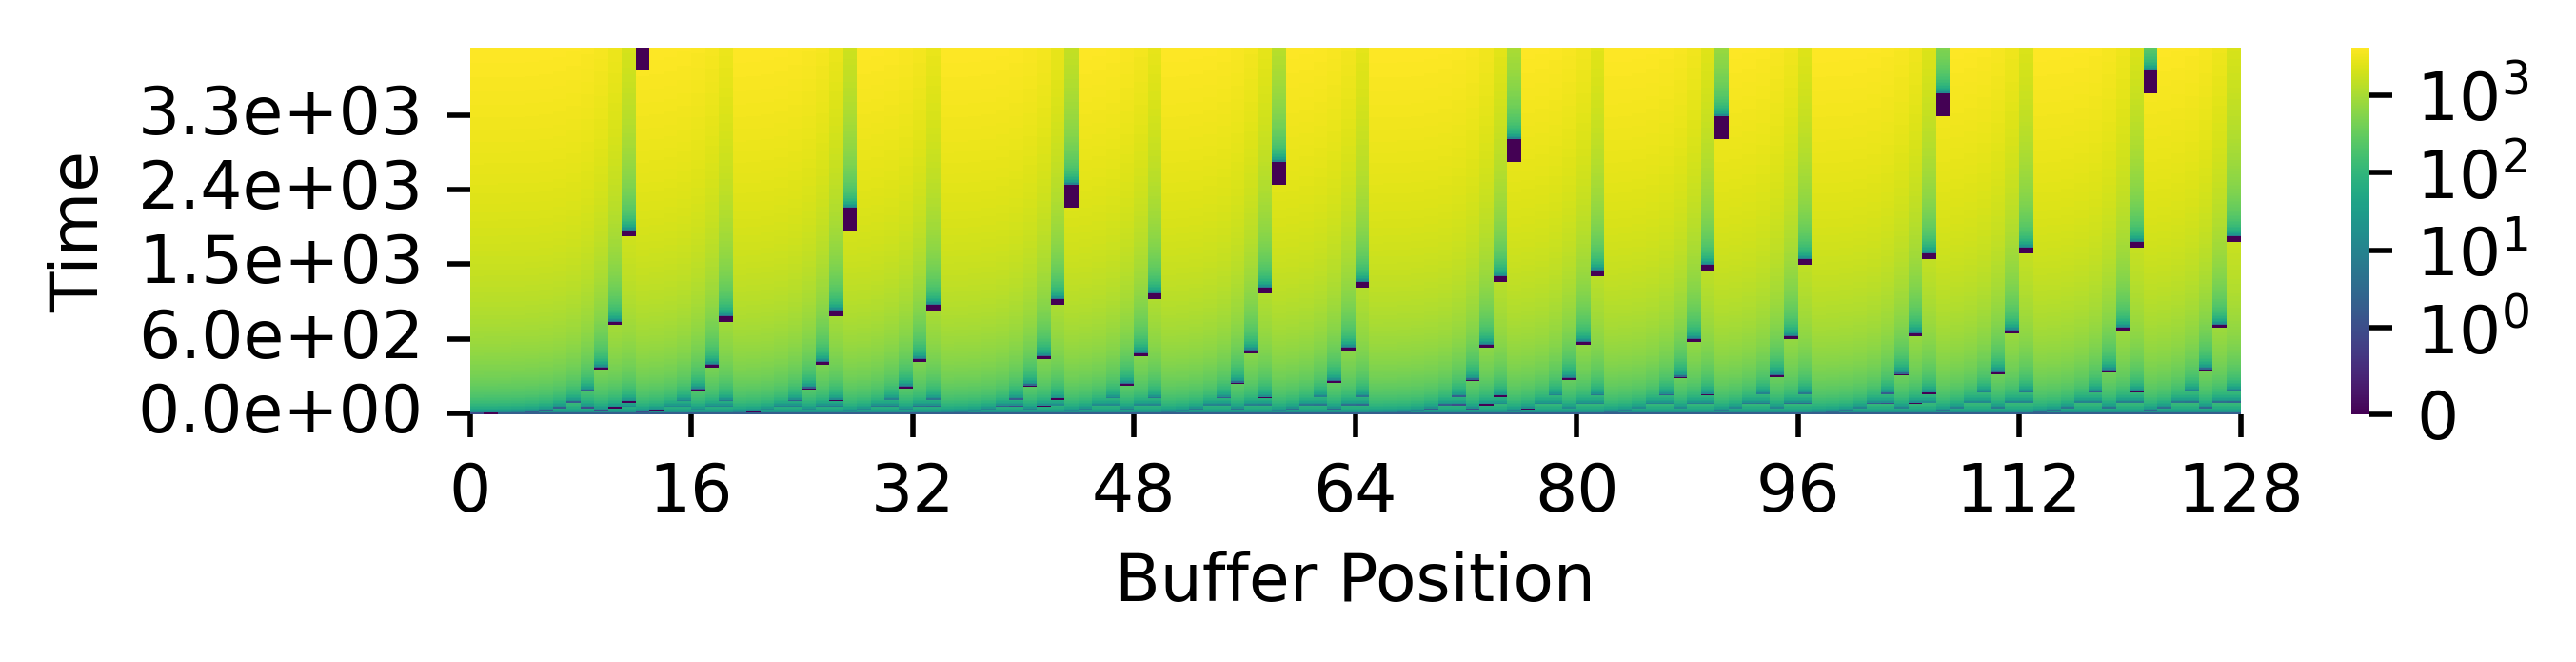

100%|██████████| 2998/2998 [00:09<00:00, 309.53it/s]


teeplots/40/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/40/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.png


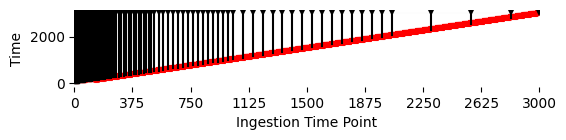

100%|██████████| 4096/4096 [00:00<00:00, 9106.42it/s]


teeplots/40/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


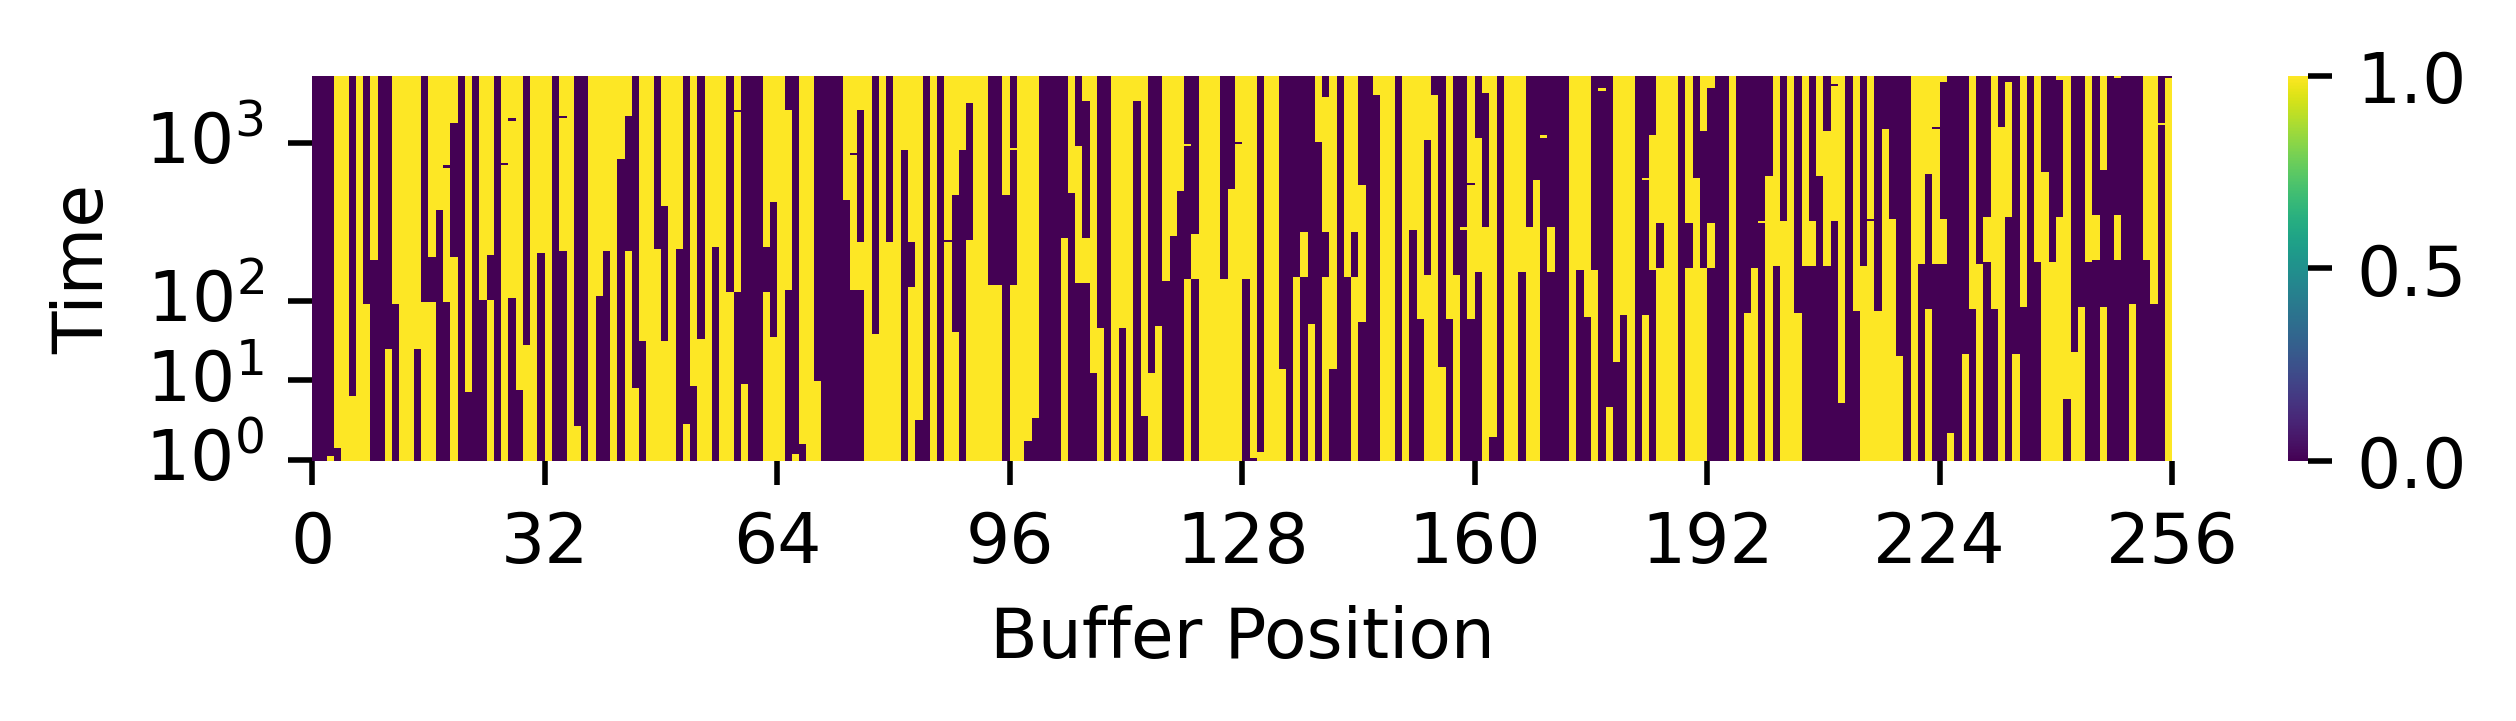

teeplots/40/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


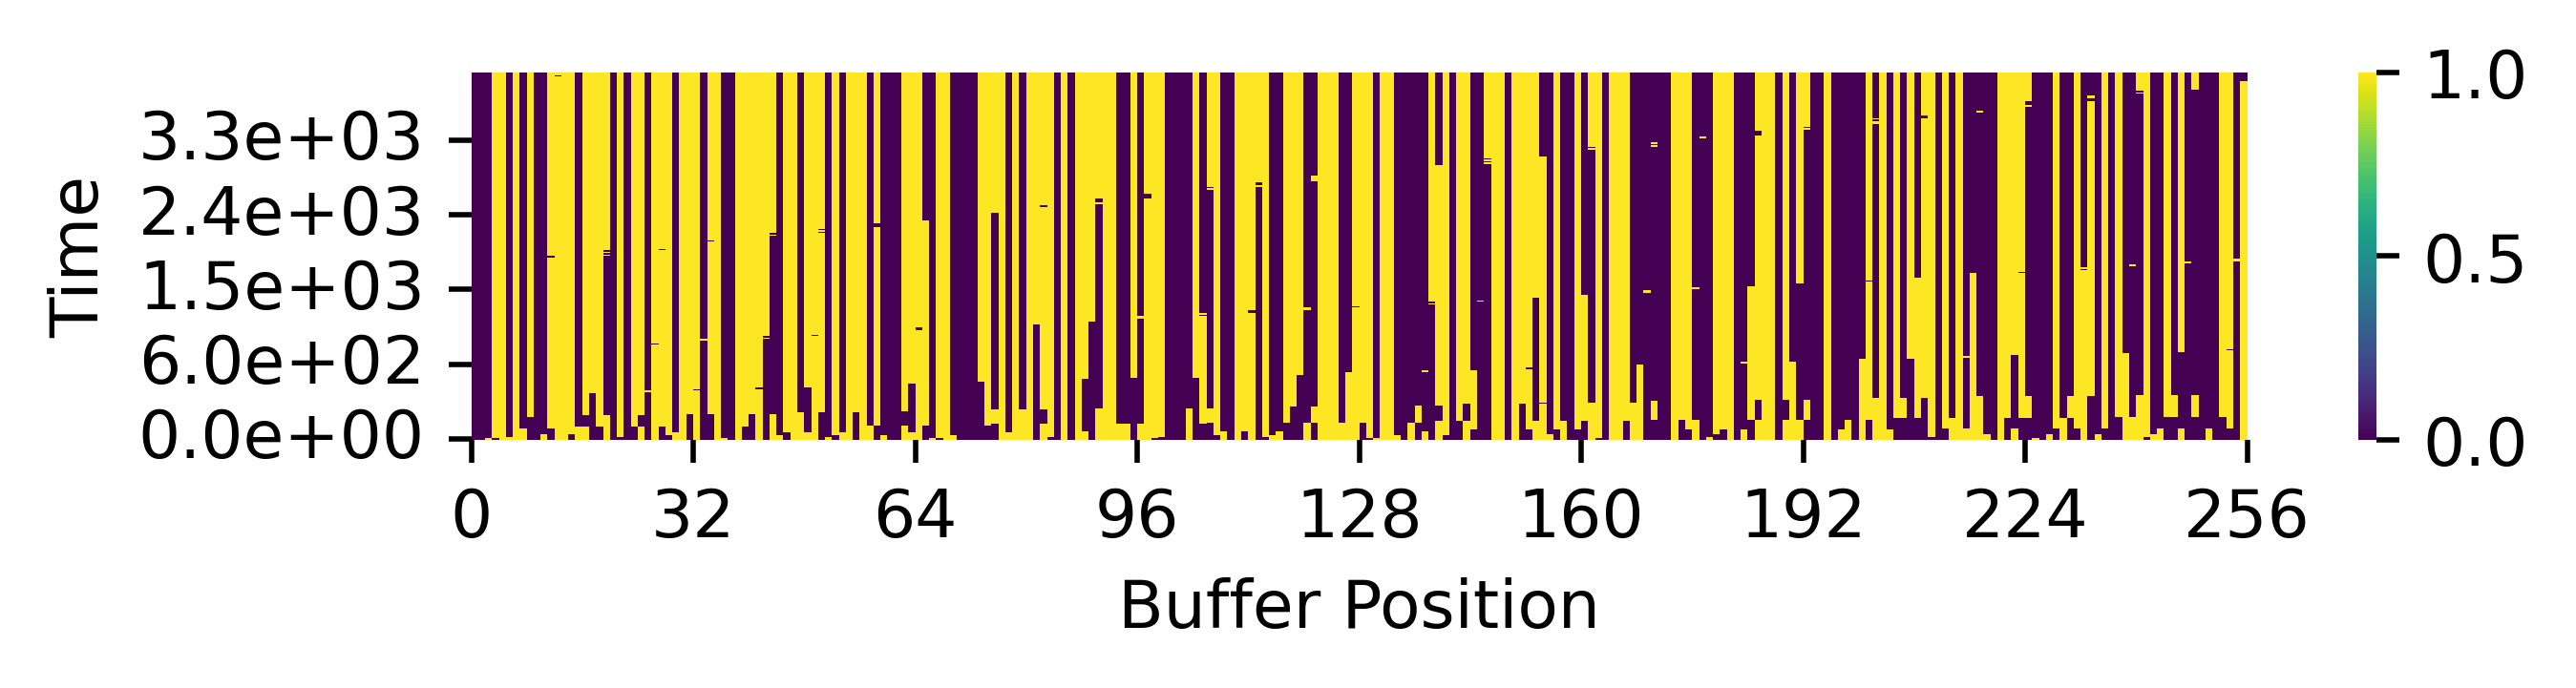

teeplots/40/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


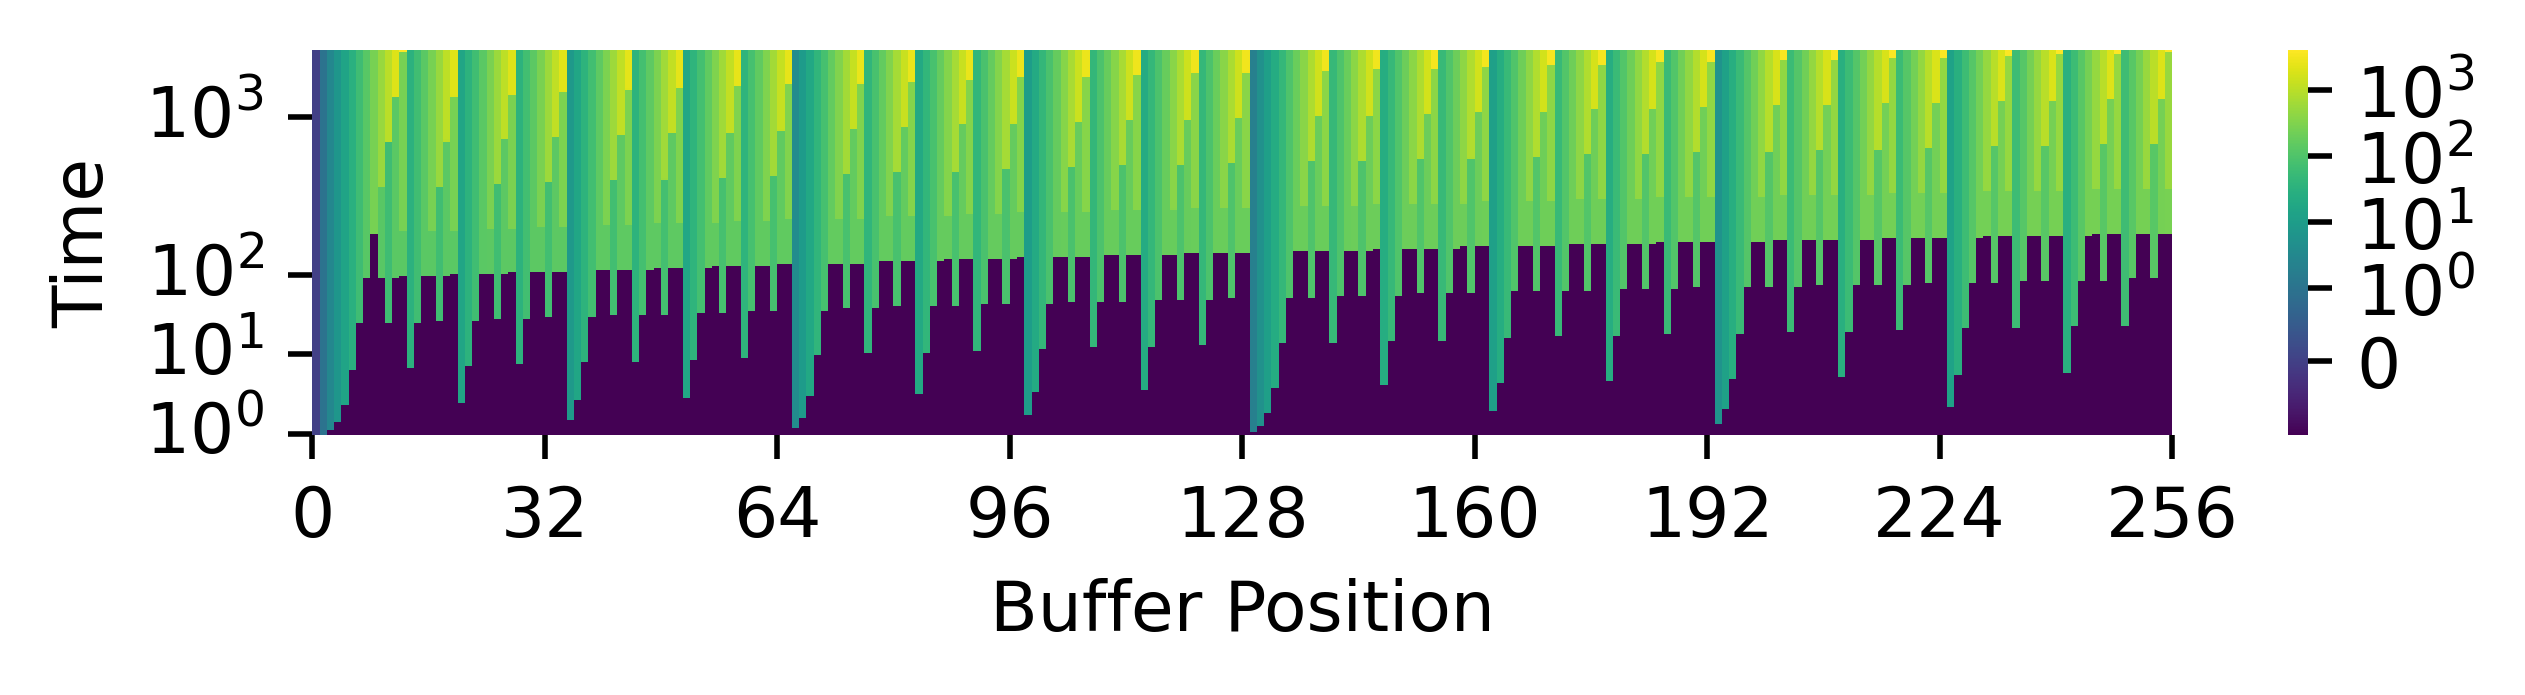

teeplots/40/cnorm=None+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=None+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


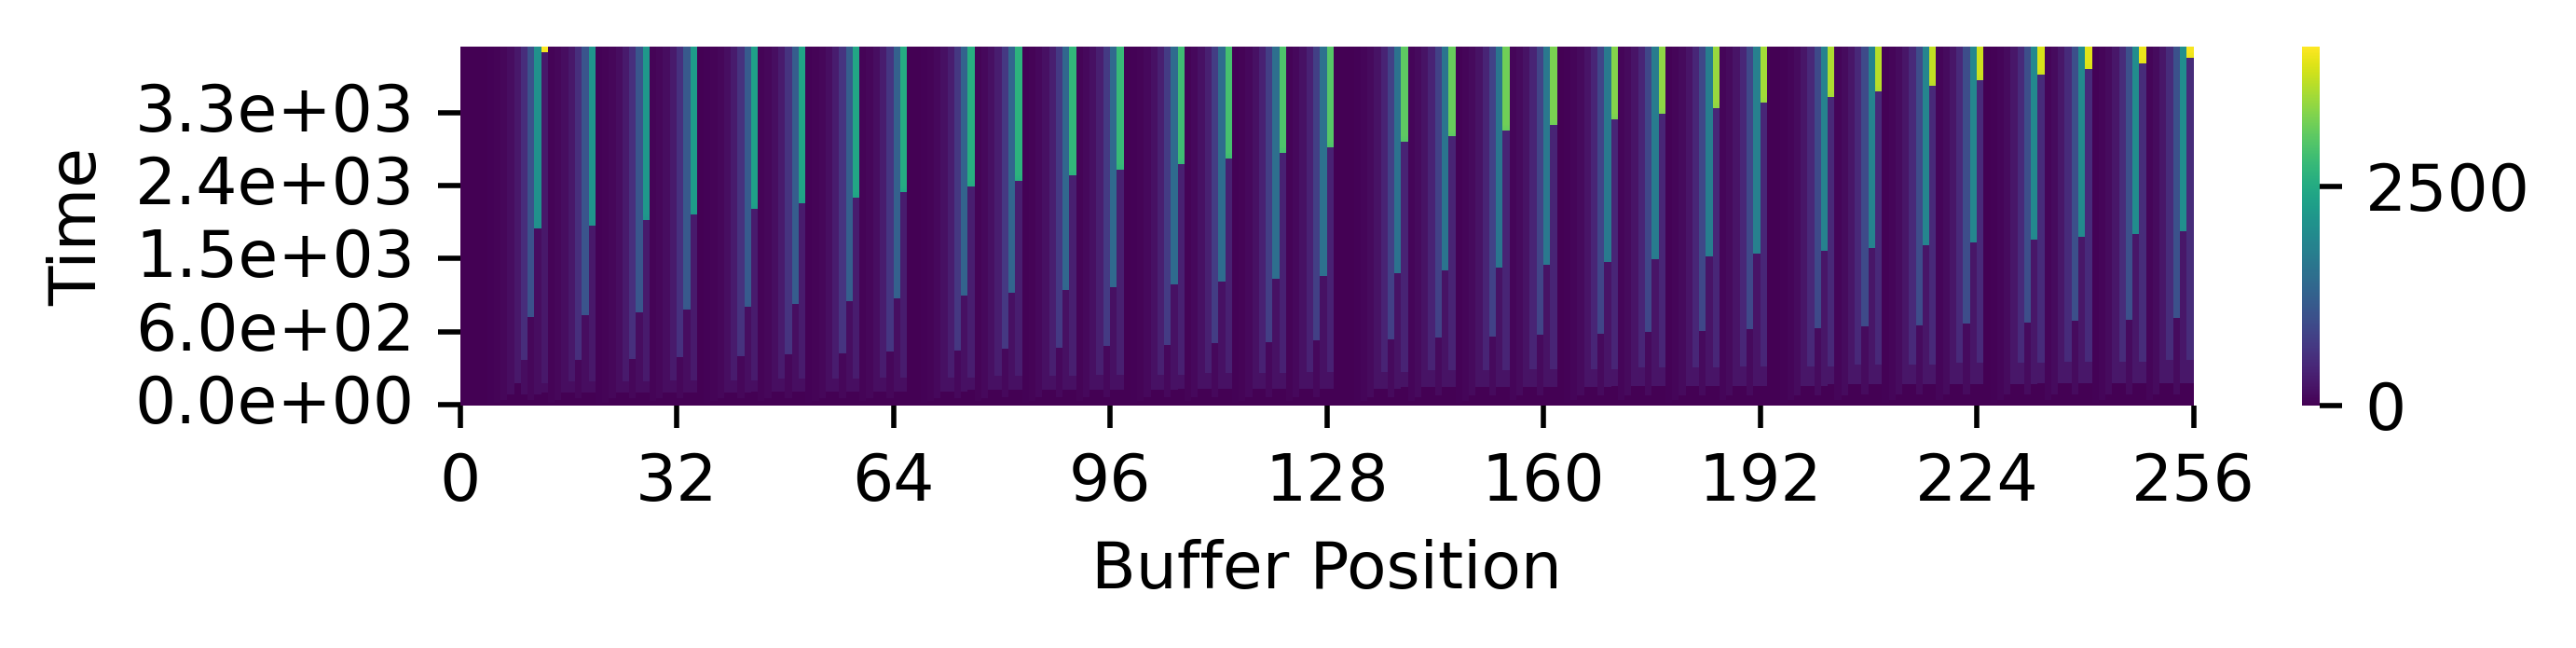

teeplots/40/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/40/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ext=.png


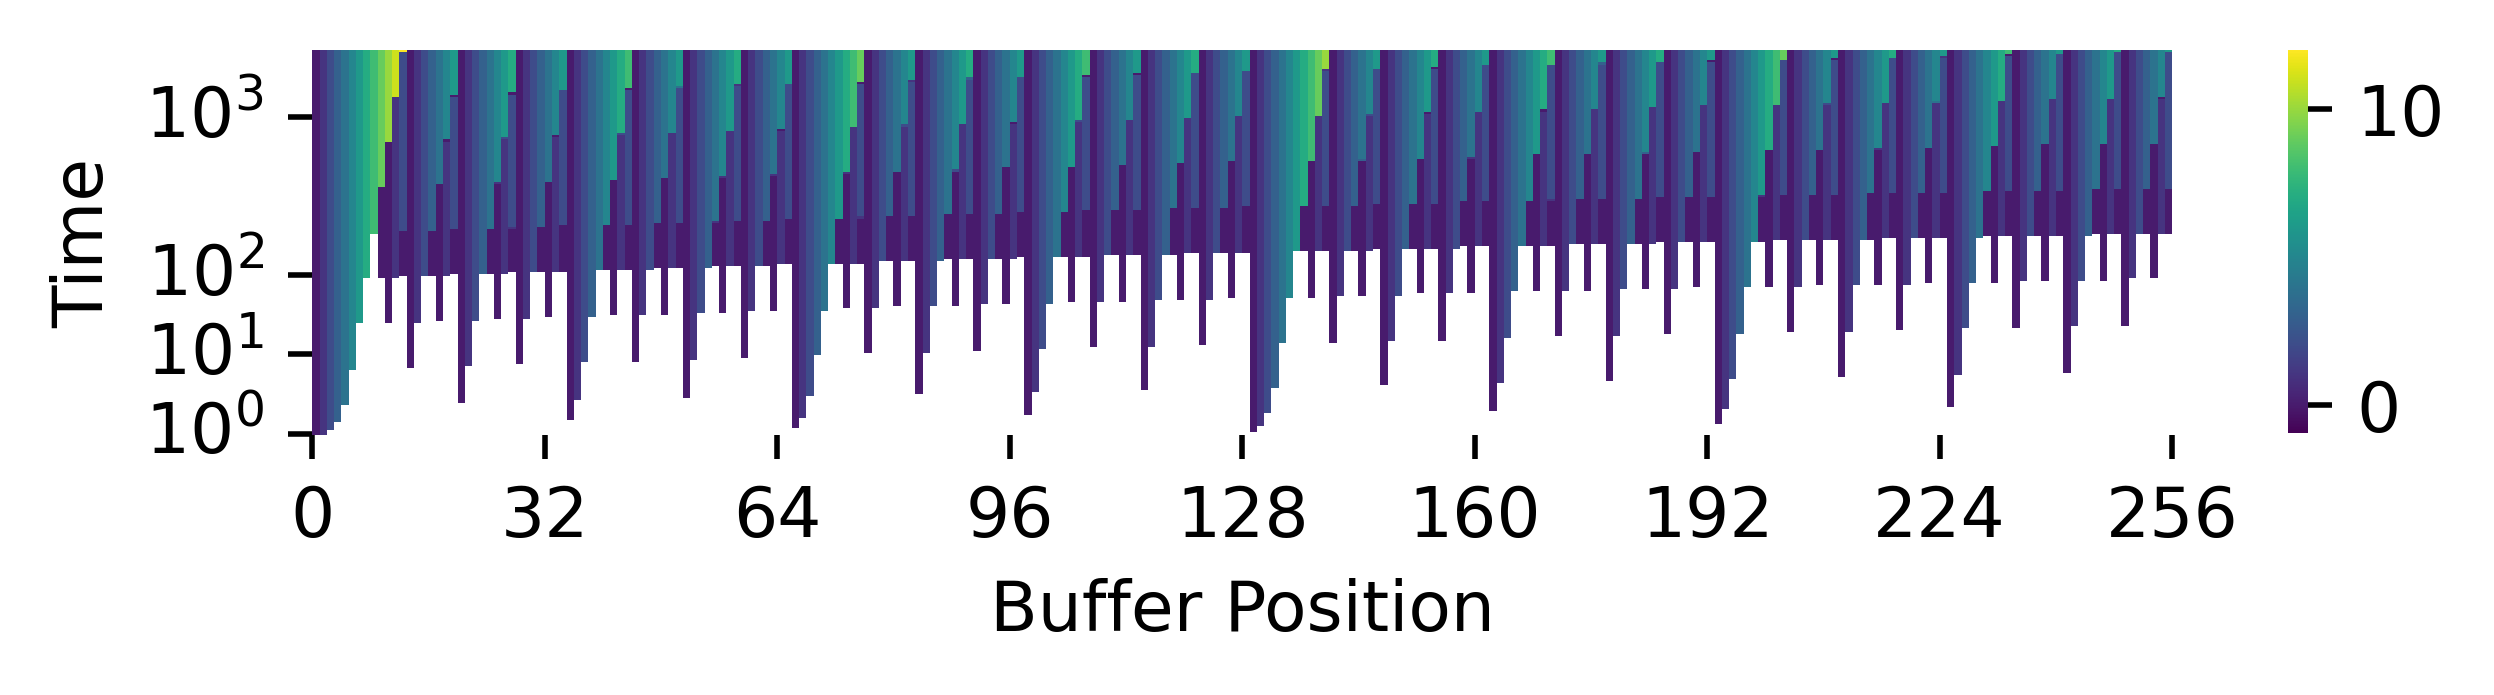

teeplots/40/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


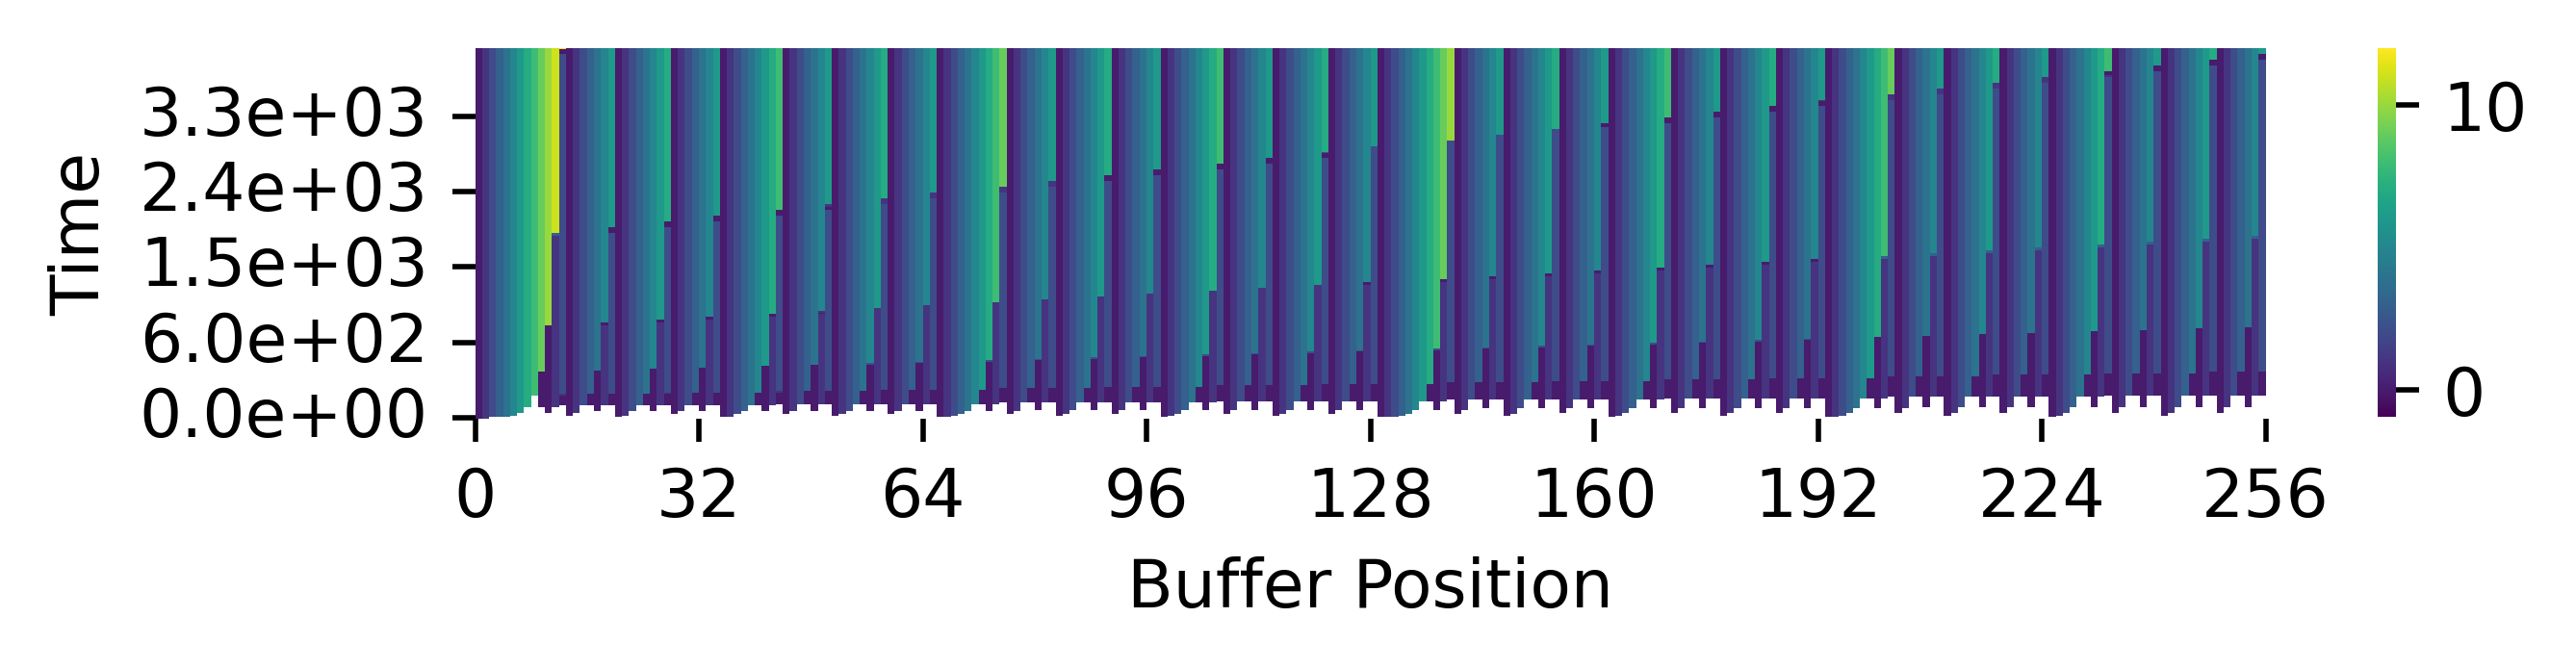

teeplots/40/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


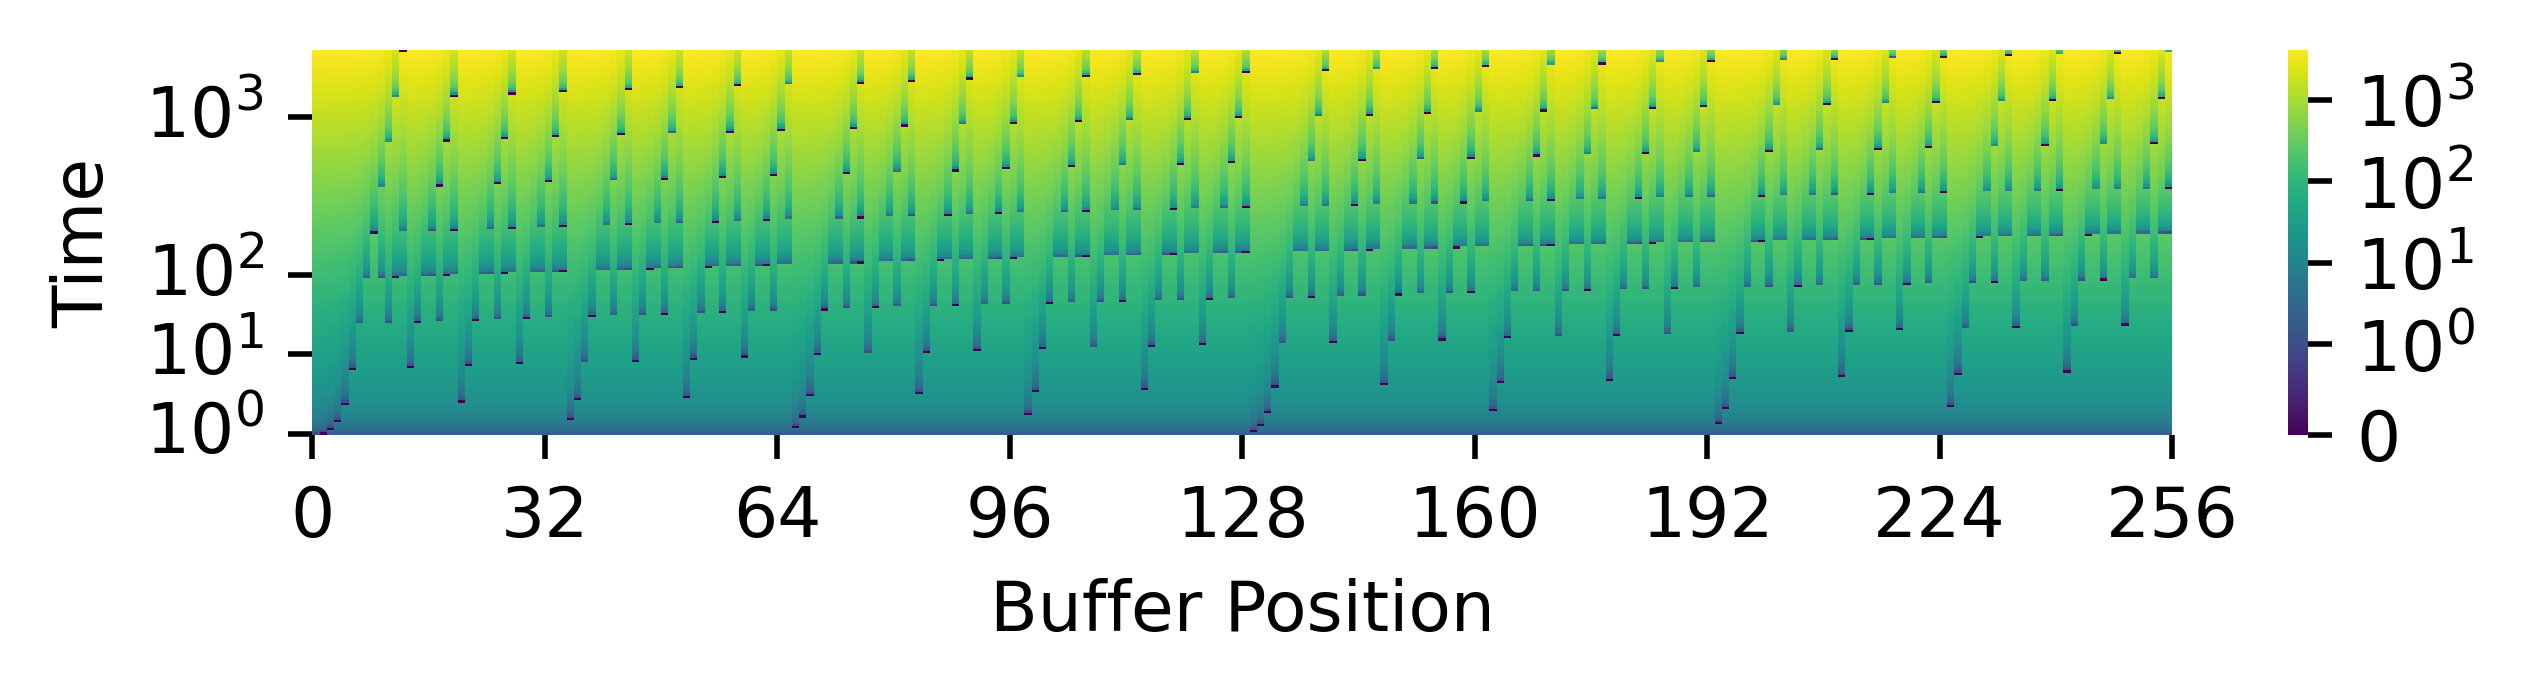

teeplots/40/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/40/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


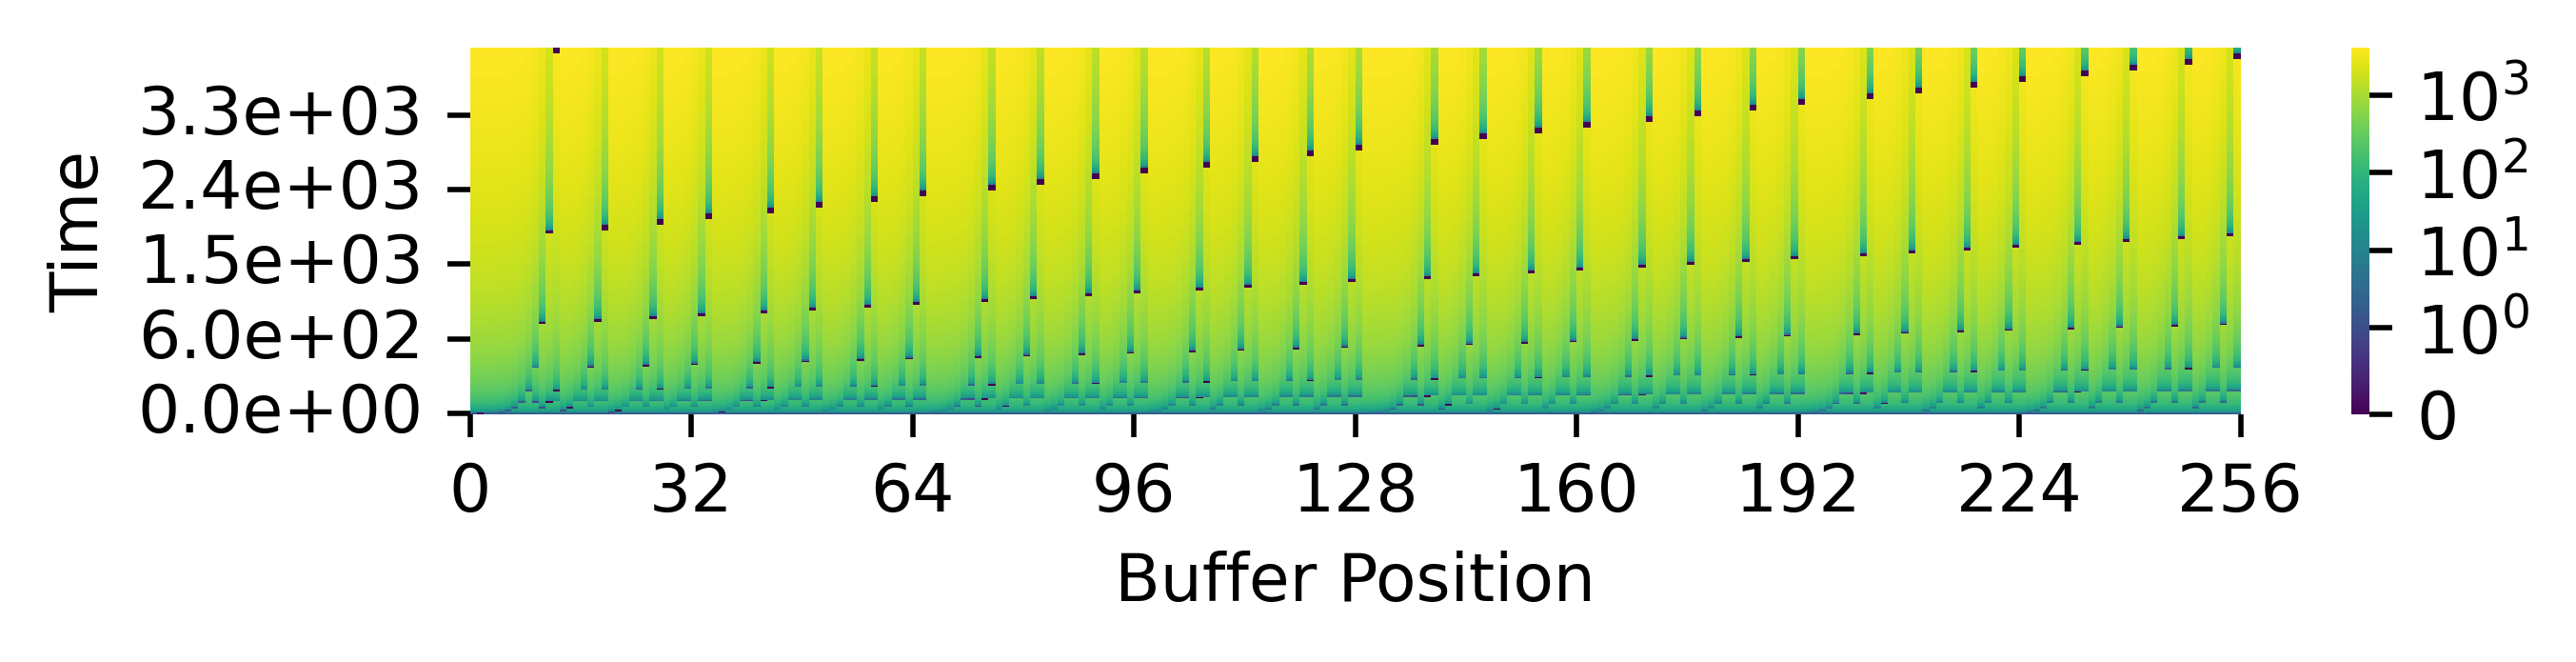

100%|██████████| 2998/2998 [00:10<00:00, 276.26it/s]


teeplots/40/num-generations=4096+surface-size=256+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/40/num-generations=4096+surface-size=256+viz=stratum-persistence-dripplot+ext=.png


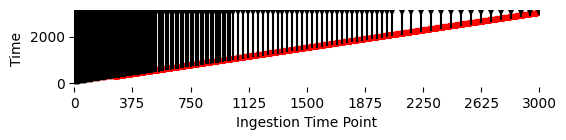

In [8]:
for surface_size_exp in range(4, 9):
    surface_size = 2**surface_size_exp
    display(HTML(f"<h3>surface size {surface_size}</h3>"))

    # don't run out of memory
    num_generations = 2**18 if surface_size_exp < 6 else 2**12

    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        stretched_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=min(num_generations, stretched_algo.get_ingest_capacity(surface_size)),
        progress_wrap=tqdm,
    )

    # ========================
    kwargs = dict(
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    kwargs = dict(
        cnorm=None,
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="40",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="40",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.stratum_persistence_dripplot,
        surface_history_df[surface_history_df["rank"] < 3000],
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="40",
        progress_wrap=tqdm,
    )


100%|██████████| 300/300 [00:00<00:00, 31407.81it/s]


teeplots/40/hue=ingest-rank+num-generations=300+surface-size=32+viz=scatter-move-legend+x=rank+y=site+ext=.pdf
teeplots/40/hue=ingest-rank+num-generations=300+surface-size=32+viz=scatter-move-legend+x=rank+y=site+ext=.png


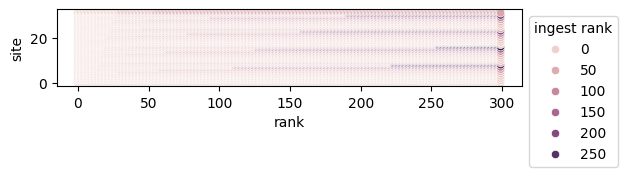

teeplots/40/hue=site+num-generations=300+surface-size=32+viz=scatter-invert+x=ingest-rank+y=rank+ext=.pdf
teeplots/40/hue=site+num-generations=300+surface-size=32+viz=scatter-invert+x=ingest-rank+y=rank+ext=.png


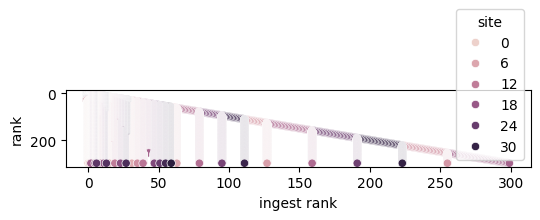

teeplots/40/hue=site+num-generations=300+surface-size=32+viz=scatter-invert-zoom+x=ingest-rank+y=rank+ext=.pdf
teeplots/40/hue=site+num-generations=300+surface-size=32+viz=scatter-invert-zoom+x=ingest-rank+y=rank+ext=.png


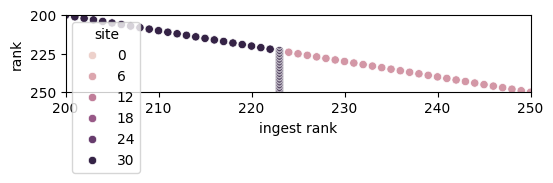

In [9]:
surface_size = 32
num_generations = 300

surface_history_df = pylib.site_selection_eval.make_surface_history_df(
    stretched_algo.pick_ingest_site,
    surface_size,
    num_generations,
    tqdm,
)


# ========================
def scatter_move_legend(*args, **kwargs) -> None:
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


pylib.tee_release(
    scatter_move_legend,
    data=surface_history_df,
    x="rank",
    y="site",
    hue="ingest rank",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
    teeplot_subdir="40",
)


# ========================
def scatter_invert(*args, **kwargs) -> None:
    sns.scatterplot(
        *args,
        **kwargs,
    ).invert_yaxis()


pylib.tee_release(
    scatter_invert,
    data=surface_history_df,
    x="ingest rank",
    y="rank",
    hue="site",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
    teeplot_subdir="40",
)


# ========================
def scatter_invert_zoom(*args, **kwargs) -> None:
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    ax.set_xlim([200, 250])
    ax.set_ylim([200, 250])
    ax.invert_yaxis()


pylib.tee_release(
    scatter_invert_zoom,
    data=surface_history_df,
    x="ingest rank",
    y="rank",
    hue="site",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
    teeplot_subdir="40",
)
